## TODO Recording

- Please do this in a terminal window on your local machine

`python --version`

`jupyter --version`

`mkdir gans_mnist`

`cd gans_mnist`

`python3 -m venv gans_venv`

`ls -l`

`source gans_venv/bin/activate`

#### Environment activation for Windows (FYI nothing for the recording)

`gans_venv\Scripts\activate.bat`

Setting up Kernel specific to pytorch_venv

## TODO Recording

- IPython kernel (ipykernel) is a Python package that provides the communication between the Jupyter Notebook or JupyterLab interface and the Python kernel. It enables you to run Python code interactively and display the output within the notebook environment.

`pip install ipykernel`


- This will list the kernels available (only one Python3 kernel - remove all others)

`jupyter kernelspec list`

- Install and make the pytorch_venv kernel available to Jupyter Notebooks

`python -m ipykernel install --user --name=gans_venv`

- Now we have 2 kernels available

`jupyter kernelspec list`

- Upgrade pip

`pip install --upgrade pip`

- Required libraries in virtual environment

`pip install torch torchvision matplotlib pandas tqdm`

- Start jupyter notebook

`jupyter notebook`

- Create a new notebook
- IMPORTANT: Make sure the notebooks is using the gans_venv virtual environment


Importing required packages

In [ ]:
import os
import torch
import torchvision
import torch.nn as nn

from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [ ]:
# Create a directory if not exists
if not os.path.exists('data'):
    os.makedirs('data')

batch_size = 16

# Image processing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5], std = [0.5])
])

# Downloading MNIST dataset
mnist_data = datasets.MNIST(
    root = 'data/',
    train = True,
    transform = transform,
    download = True
)

# Data loader
mnist_dataloader = DataLoader(
    dataset = mnist_data, batch_size = batch_size,
    shuffle = True, drop_last = True
)

In [ ]:
len(mnist_data)

60000

In [ ]:
len(mnist_dataloader)

3750

Extracting some random batch of training images

In [ ]:
dataiter = iter(mnist_dataloader)

images, labels = next(dataiter)

images.shape

torch.Size([16, 1, 28, 28])

Defining functions to display few images from the dataset

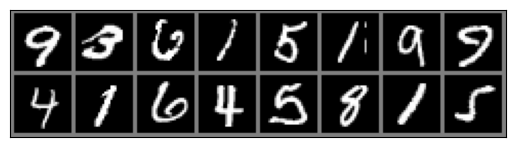

In [ ]:
def display(img):

    img = img / 2 + 0.5
    img = img.permute(1, 2, 0)
    npimg = img.numpy()

    plt.imshow(npimg)
    plt.xticks([])
    plt.yticks([])
    plt.show()

display(make_grid(images, 8))


Defining Hyperparameters for Generator and Discriminator Network

In [ ]:
latent_noise_size = 128

# 28 x 28
image_size = 784

The generator is designed to map the latent space vector (z) to data-space. Since our data comprises of images, converting z to data-space means ultimately creating a grey scale image with the same size as the training images (i.e. 1x28x28). The output of the generator is fed through a tanh function to return it to the input data range of [-1, 1]

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.main = nn.Sequential(
            nn.Linear(latent_noise_size, 64),
            nn.ReLU(),

            nn.Linear(64, 128),
            nn.ReLU(),

            nn.Linear(128, 256),
            nn.ReLU(),

            nn.Linear(256, image_size),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

Instantiating Generator network and display the network

In [ ]:
generator = Generator()

print(generator)

Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=784, bias=True)
    (7): Tanh()
  )
)


The discriminator, is a binary classification network that takes an image as input and outputs a scalar probability that the input image is real (as opposed to fake). Here,it takes a 1x28x28 input image, processes it through a series of Linear, and LeakyReLU layers, and outputs the final probability through a Sigmoid activation function.

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.main = nn.Sequential(
            nn.Linear(image_size, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(p = 0.2),

            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(p = 0.2),

            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Dropout(p = 0.2),

            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

In [ ]:
discriminator = Discriminator()

print(discriminator)

Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
    (10): Sigmoid()
  )
)


Random value inputs (batch size 64) as Input to Generator

In [ ]:
z = torch.randn(32, latent_noise_size)

# Generator network output
sample_generated_output = generator(z)

sample_generated_output

tensor([[ 0.0906,  0.0174, -0.0566,  ...,  0.0293,  0.0844, -0.0872],
        [ 0.0958, -0.0420, -0.0222,  ...,  0.0461,  0.0947, -0.0381],
        [ 0.0932, -0.0154, -0.0977,  ...,  0.0488,  0.0578, -0.0640],
        ...,
        [ 0.1335, -0.0130, -0.0740,  ...,  0.0408,  0.0760, -0.0412],
        [ 0.0620, -0.0390, -0.0480,  ...,  0.0691,  0.0499, -0.0557],
        [ 0.0776, -0.0316, -0.0778,  ...,  0.0043,  0.0941, -0.0304]],
       grad_fn=<TanhBackward0>)

In [ ]:
sample_generated_output.shape

torch.Size([32, 784])

Minimum and maximum values of pixel output from Generator are obtained which are well within the range of TanH output range of  -1 to 1

In [ ]:
torch.min(sample_generated_output).item(), torch.max(sample_generated_output).item()

(-0.256765216588974, 0.2359154373407364)

Reshape the output into 64 images of 28 X 28  and plotting an instance, Random noise is generated

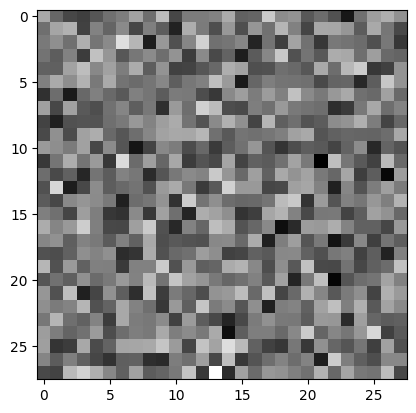

In [ ]:
generated_images = sample_generated_output.reshape(32, 1, 28, 28)

random_image = generated_images[16, 0, :, :]

plt.imshow(random_image.detach().numpy(), cmap = 'gray')

Display images in a grid layout.Generated images are entirely random since we have not trained the generator network, and its parameters (weights and biases) are completely random at this stage.

In [ ]:
generated_images.shape

torch.Size([32, 1, 28, 28])

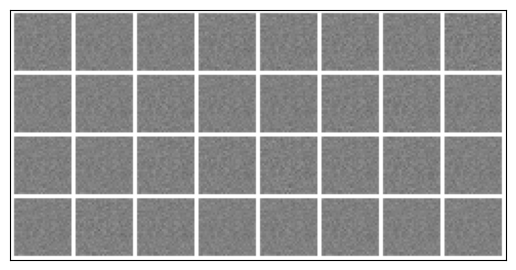

In [ ]:
display(make_grid(generated_images, nrow = 8, pad_value = 1.0))

Let’s feed an batch of  image generated by the untrained generator network into the discriminator: Predictions are random

In [ ]:
discriminator.eval()

with torch.no_grad():
    prediction = discriminator(generated_images.reshape(-1, 784))

print(prediction[:15])

tensor([[0.4821],
        [0.4819],
        [0.4826],
        [0.4817],
        [0.4822],
        [0.4824],
        [0.4825],
        [0.4827],
        [0.4824],
        [0.4821],
        [0.4829],
        [0.4822],
        [0.4820],
        [0.4818],
        [0.4824]])


Let’s feed an batch of real images into the discriminator: Predictions are random

In [ ]:
discriminator.eval()
with torch.no_grad():
    prediction_real = discriminator(images.reshape(-1, 784))

print(prediction_real[:15])

tensor([[0.4755],
        [0.4825],
        [0.4710],
        [0.4778],
        [0.4688],
        [0.4741],
        [0.4716],
        [0.4678],
        [0.4820],
        [0.4711],
        [0.4664],
        [0.4715],
        [0.4751],
        [0.4727],
        [0.4798]])


With D and G setup, we can specify how they learn through the loss functions and optimizers. We will use the Binary Cross Entropy loss (BCELoss) function which is defined in PyTorch as:

In [ ]:
criterion = nn.BCELoss()

During training, the discriminator predicts whether an input image is real or fake. We calculate the loss value and apply back-propagation so that the optimizer can adjust network parameters (weights and biases).

In [ ]:
import torch.optim as optim

optimizer_D = optim.Adam(discriminator.parameters(), lr = 0.0002)
optimizer_G = optim.Adam(generator.parameters(), lr = 0.0002)

print(optimizer_D), print(optimizer_G)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0002
    maximize: False
    weight_decay: 0
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0002
    maximize: False
    weight_decay: 0
)


(None, None)

In [ ]:
# Labels for real and fake data
real_image_labels = torch.full((batch_size,), 1., dtype = torch.float)

fake_image_labels = torch.full((batch_size,), 0., dtype = torch.float)

In [ ]:
# Fixed noise for image generation at the end of every epoch
fixed_noise = torch.randn(batch_size, latent_noise_size)

  0%|                                                     | 0/50 [00:00<?, ?it/s]

-------------------------------------
                Epoch 1: 
                Step: 0 | 
                D_real Loss: 0.7516 | 
                D_fake Loss: 0.6571 | 
                D_total Loss: 1.4087 | 
                G_Loss: 0.733 |
                Real_score 0.472 | 
                Fake_score 0.482 
            


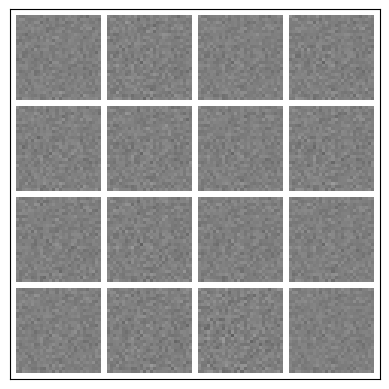

-------------------------------------
                Epoch 1: 
                Step: 500 | 
                D_real Loss: 0.0517 | 
                D_fake Loss: 0.0357 | 
                D_total Loss: 0.0874 | 
                G_Loss: 4.935 |
                Real_score 0.951 | 
                Fake_score 0.033 
            


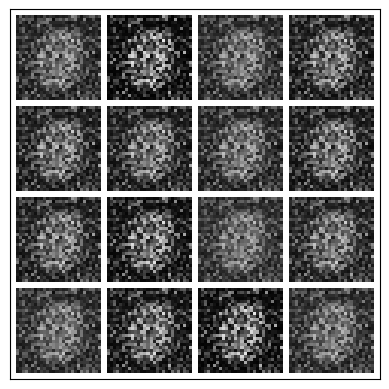

-------------------------------------
                Epoch 1: 
                Step: 1000 | 
                D_real Loss: 0.5376 | 
                D_fake Loss: 0.1775 | 
                D_total Loss: 0.7151 | 
                G_Loss: 1.765 |
                Real_score 0.631 | 
                Fake_score 0.148 
            


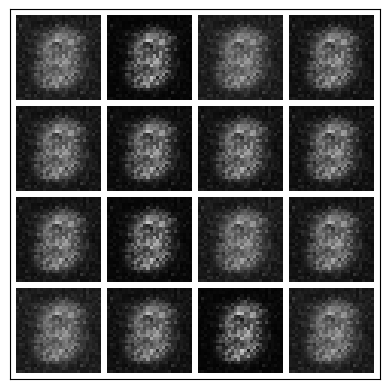

-------------------------------------
                Epoch 1: 
                Step: 1500 | 
                D_real Loss: 0.3761 | 
                D_fake Loss: 0.2671 | 
                D_total Loss: 0.6432 | 
                G_Loss: 2.085 |
                Real_score 0.773 | 
                Fake_score 0.221 
            


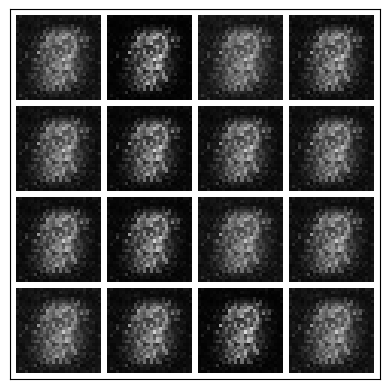

-------------------------------------
                Epoch 1: 
                Step: 2000 | 
                D_real Loss: 0.0069 | 
                D_fake Loss: 0.3133 | 
                D_total Loss: 0.3202 | 
                G_Loss: 3.559 |
                Real_score 0.993 | 
                Fake_score 0.192 
            


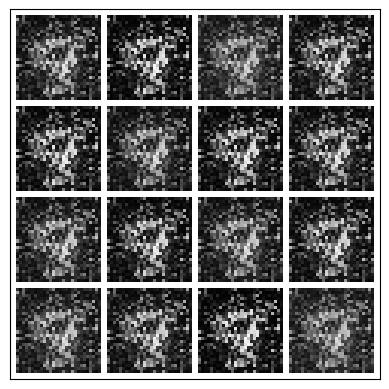

-------------------------------------
                Epoch 1: 
                Step: 2500 | 
                D_real Loss: 0.0007 | 
                D_fake Loss: 0.1833 | 
                D_total Loss: 0.1840 | 
                G_Loss: 4.382 |
                Real_score 0.999 | 
                Fake_score 0.120 
            


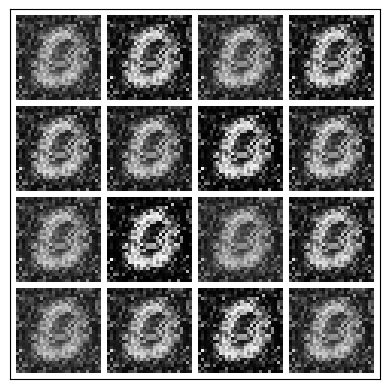

-------------------------------------
                Epoch 1: 
                Step: 3000 | 
                D_real Loss: 0.6596 | 
                D_fake Loss: 0.0502 | 
                D_total Loss: 0.7098 | 
                G_Loss: 3.356 |
                Real_score 0.782 | 
                Fake_score 0.043 
            


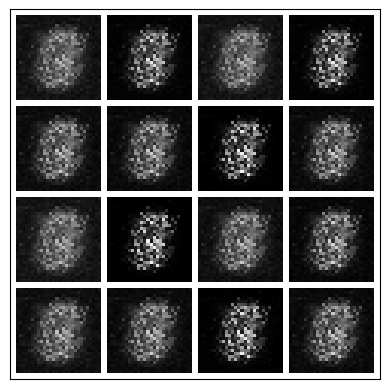

-------------------------------------
                Epoch 1: 
                Step: 3500 | 
                D_real Loss: 0.0096 | 
                D_fake Loss: 0.0566 | 
                D_total Loss: 0.0662 | 
                G_Loss: 3.561 |
                Real_score 0.991 | 
                Fake_score 0.052 
            


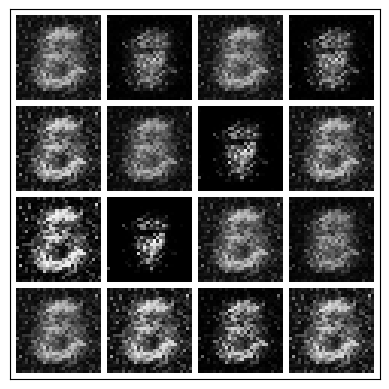

  2%|▉                                            | 1/50 [01:02<50:59, 62.45s/it]

-------------------------------------
                Epoch 2: 
                Step: 0 | 
                D_real Loss: 0.0085 | 
                D_fake Loss: 0.0137 | 
                D_total Loss: 0.0222 | 
                G_Loss: 5.137 |
                Real_score 0.992 | 
                Fake_score 0.013 
            


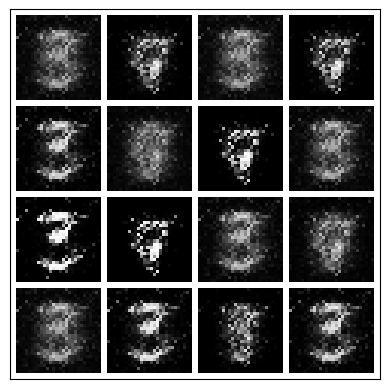

-------------------------------------
                Epoch 2: 
                Step: 500 | 
                D_real Loss: 0.0101 | 
                D_fake Loss: 0.3038 | 
                D_total Loss: 0.3140 | 
                G_Loss: 2.904 |
                Real_score 0.990 | 
                Fake_score 0.190 
            


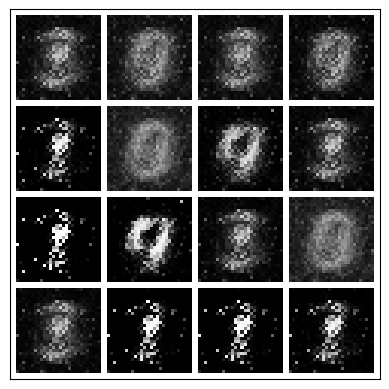

-------------------------------------
                Epoch 2: 
                Step: 1000 | 
                D_real Loss: 0.0224 | 
                D_fake Loss: 0.0754 | 
                D_total Loss: 0.0979 | 
                G_Loss: 3.505 |
                Real_score 0.979 | 
                Fake_score 0.069 
            


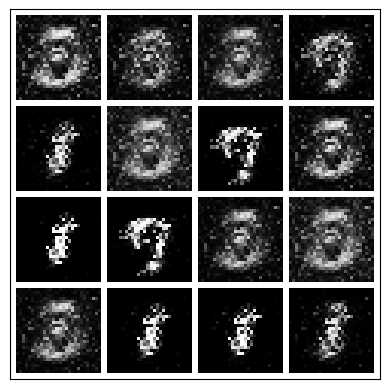

-------------------------------------
                Epoch 2: 
                Step: 1500 | 
                D_real Loss: 0.0461 | 
                D_fake Loss: 0.0647 | 
                D_total Loss: 0.1108 | 
                G_Loss: 4.099 |
                Real_score 0.962 | 
                Fake_score 0.051 
            


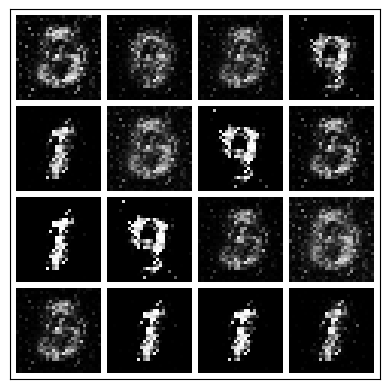

-------------------------------------
                Epoch 2: 
                Step: 2000 | 
                D_real Loss: 0.0244 | 
                D_fake Loss: 0.0271 | 
                D_total Loss: 0.0515 | 
                G_Loss: 4.064 |
                Real_score 0.977 | 
                Fake_score 0.026 
            


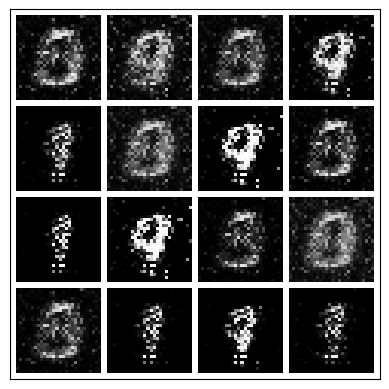

-------------------------------------
                Epoch 2: 
                Step: 2500 | 
                D_real Loss: 0.4071 | 
                D_fake Loss: 0.0292 | 
                D_total Loss: 0.4362 | 
                G_Loss: 4.926 |
                Real_score 0.816 | 
                Fake_score 0.028 
            


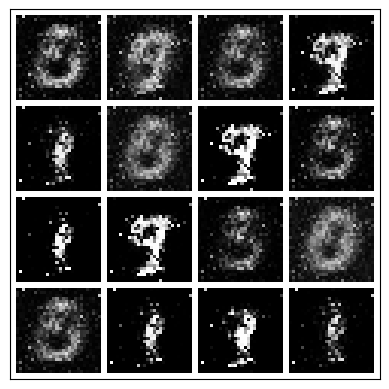

-------------------------------------
                Epoch 2: 
                Step: 3000 | 
                D_real Loss: 0.0624 | 
                D_fake Loss: 0.0936 | 
                D_total Loss: 0.1560 | 
                G_Loss: 2.502 |
                Real_score 0.952 | 
                Fake_score 0.081 
            


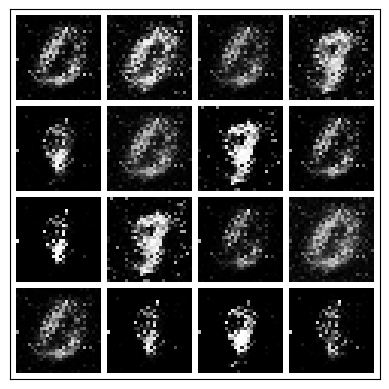

-------------------------------------
                Epoch 2: 
                Step: 3500 | 
                D_real Loss: 0.1644 | 
                D_fake Loss: 0.2141 | 
                D_total Loss: 0.3785 | 
                G_Loss: 3.232 |
                Real_score 0.875 | 
                Fake_score 0.162 
            


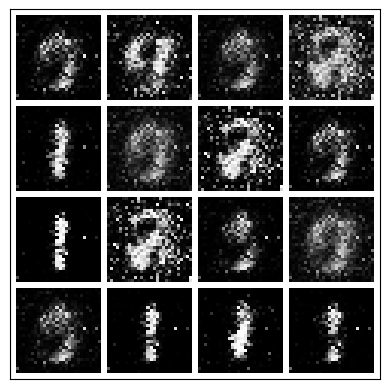

  4%|█▊                                           | 2/50 [02:03<49:08, 61.43s/it]

-------------------------------------
                Epoch 3: 
                Step: 0 | 
                D_real Loss: 0.1606 | 
                D_fake Loss: 0.2420 | 
                D_total Loss: 0.4027 | 
                G_Loss: 2.099 |
                Real_score 0.883 | 
                Fake_score 0.190 
            


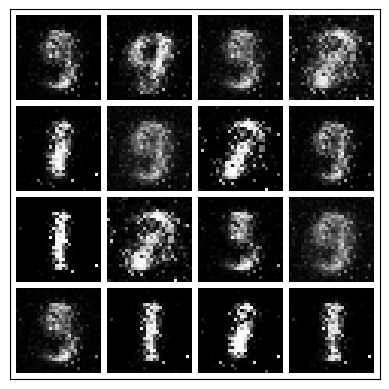

-------------------------------------
                Epoch 3: 
                Step: 500 | 
                D_real Loss: 0.3251 | 
                D_fake Loss: 0.4149 | 
                D_total Loss: 0.7400 | 
                G_Loss: 2.860 |
                Real_score 0.836 | 
                Fake_score 0.260 
            


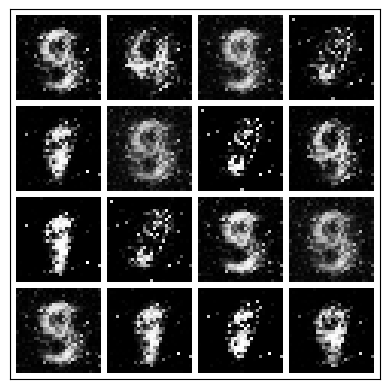

-------------------------------------
                Epoch 3: 
                Step: 1000 | 
                D_real Loss: 0.0405 | 
                D_fake Loss: 0.0360 | 
                D_total Loss: 0.0764 | 
                G_Loss: 4.095 |
                Real_score 0.968 | 
                Fake_score 0.034 
            


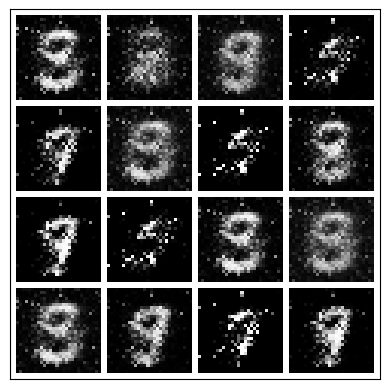

-------------------------------------
                Epoch 3: 
                Step: 1500 | 
                D_real Loss: 0.1649 | 
                D_fake Loss: 0.1283 | 
                D_total Loss: 0.2932 | 
                G_Loss: 3.077 |
                Real_score 0.905 | 
                Fake_score 0.115 
            


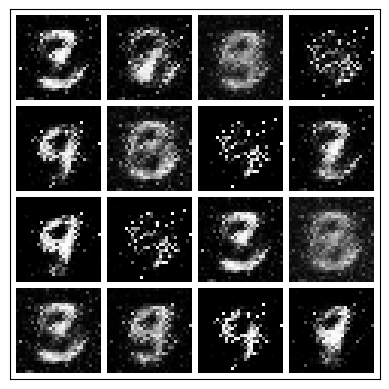

-------------------------------------
                Epoch 3: 
                Step: 2000 | 
                D_real Loss: 0.3314 | 
                D_fake Loss: 0.0243 | 
                D_total Loss: 0.3557 | 
                G_Loss: 3.827 |
                Real_score 0.854 | 
                Fake_score 0.024 
            


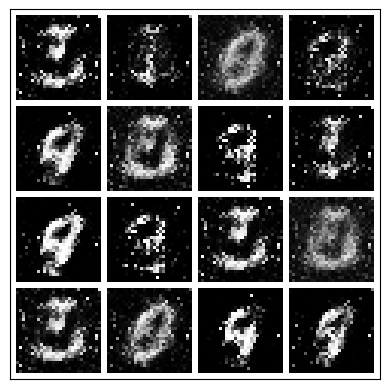

-------------------------------------
                Epoch 3: 
                Step: 2500 | 
                D_real Loss: 0.4173 | 
                D_fake Loss: 0.2902 | 
                D_total Loss: 0.7075 | 
                G_Loss: 2.245 |
                Real_score 0.804 | 
                Fake_score 0.219 
            


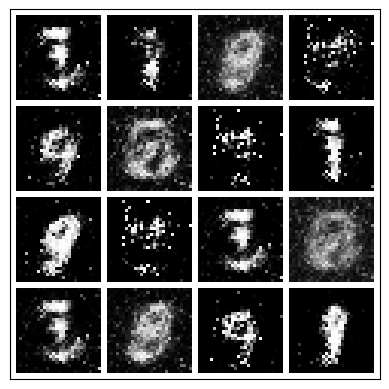

-------------------------------------
                Epoch 3: 
                Step: 3000 | 
                D_real Loss: 0.3219 | 
                D_fake Loss: 0.1107 | 
                D_total Loss: 0.4325 | 
                G_Loss: 3.224 |
                Real_score 0.786 | 
                Fake_score 0.093 
            


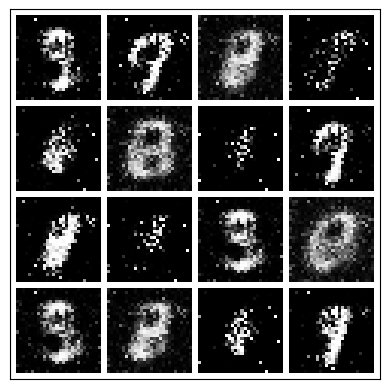

-------------------------------------
                Epoch 3: 
                Step: 3500 | 
                D_real Loss: 0.3067 | 
                D_fake Loss: 0.0558 | 
                D_total Loss: 0.3625 | 
                G_Loss: 3.465 |
                Real_score 0.832 | 
                Fake_score 0.050 
            


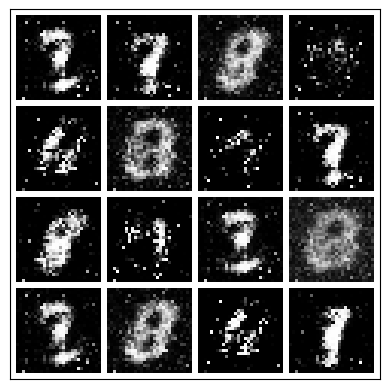

  6%|██▋                                          | 3/50 [03:02<47:14, 60.32s/it]

-------------------------------------
                Epoch 4: 
                Step: 0 | 
                D_real Loss: 0.1940 | 
                D_fake Loss: 0.0464 | 
                D_total Loss: 0.2404 | 
                G_Loss: 3.856 |
                Real_score 0.866 | 
                Fake_score 0.044 
            


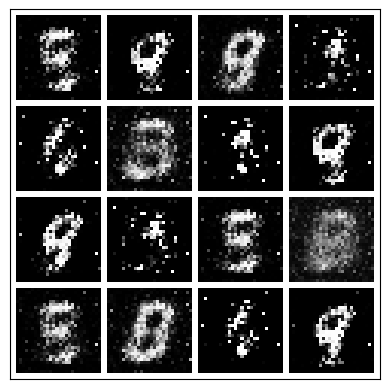

-------------------------------------
                Epoch 4: 
                Step: 500 | 
                D_real Loss: 0.1238 | 
                D_fake Loss: 0.5364 | 
                D_total Loss: 0.6602 | 
                G_Loss: 2.438 |
                Real_score 0.933 | 
                Fake_score 0.342 
            


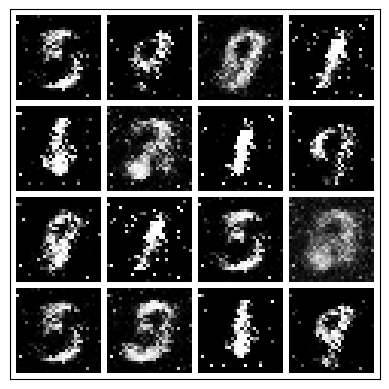

-------------------------------------
                Epoch 4: 
                Step: 1000 | 
                D_real Loss: 0.1643 | 
                D_fake Loss: 0.0936 | 
                D_total Loss: 0.2579 | 
                G_Loss: 2.478 |
                Real_score 0.895 | 
                Fake_score 0.085 
            


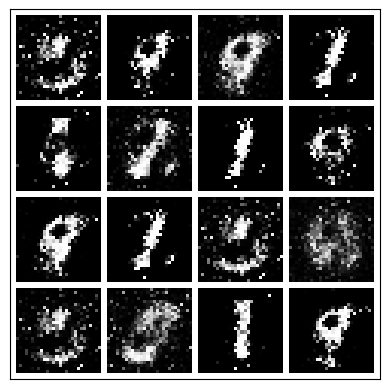

-------------------------------------
                Epoch 4: 
                Step: 1500 | 
                D_real Loss: 0.6458 | 
                D_fake Loss: 0.0724 | 
                D_total Loss: 0.7182 | 
                G_Loss: 3.834 |
                Real_score 0.708 | 
                Fake_score 0.067 
            


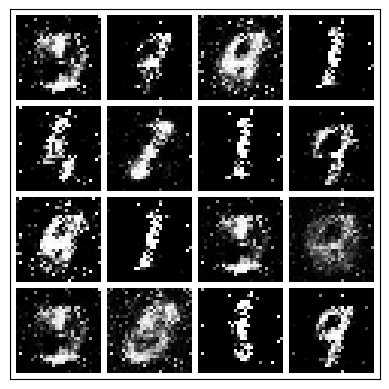

-------------------------------------
                Epoch 4: 
                Step: 2000 | 
                D_real Loss: 0.1580 | 
                D_fake Loss: 0.1577 | 
                D_total Loss: 0.3158 | 
                G_Loss: 2.315 |
                Real_score 0.912 | 
                Fake_score 0.140 
            


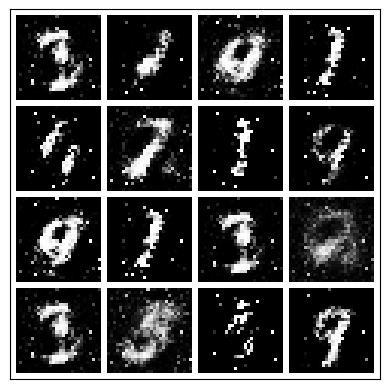

-------------------------------------
                Epoch 4: 
                Step: 2500 | 
                D_real Loss: 0.5235 | 
                D_fake Loss: 0.0621 | 
                D_total Loss: 0.5856 | 
                G_Loss: 3.031 |
                Real_score 0.747 | 
                Fake_score 0.058 
            


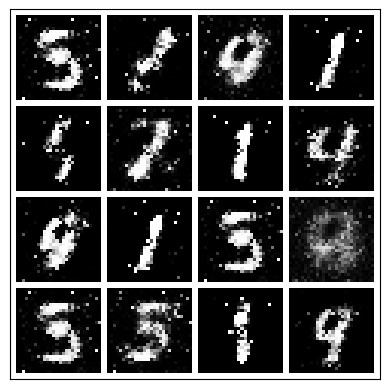

-------------------------------------
                Epoch 4: 
                Step: 3000 | 
                D_real Loss: 0.6119 | 
                D_fake Loss: 0.4617 | 
                D_total Loss: 1.0736 | 
                G_Loss: 1.583 |
                Real_score 0.733 | 
                Fake_score 0.327 
            


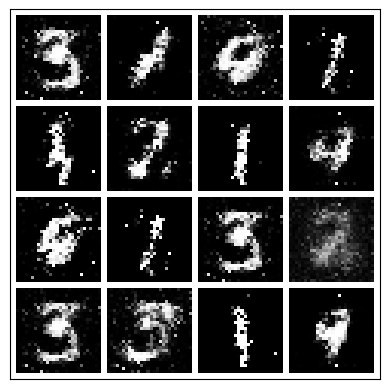

-------------------------------------
                Epoch 4: 
                Step: 3500 | 
                D_real Loss: 0.6153 | 
                D_fake Loss: 0.1794 | 
                D_total Loss: 0.7947 | 
                G_Loss: 2.451 |
                Real_score 0.699 | 
                Fake_score 0.153 
            


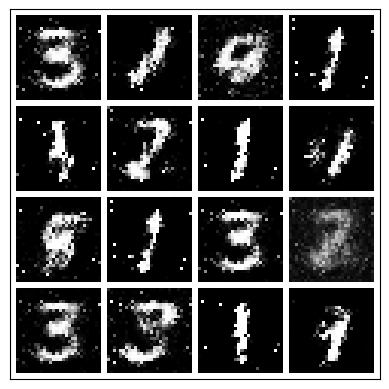

  8%|███▌                                         | 4/50 [03:50<42:38, 55.62s/it]

-------------------------------------
                Epoch 5: 
                Step: 0 | 
                D_real Loss: 0.2714 | 
                D_fake Loss: 0.1381 | 
                D_total Loss: 0.4095 | 
                G_Loss: 2.801 |
                Real_score 0.811 | 
                Fake_score 0.121 
            


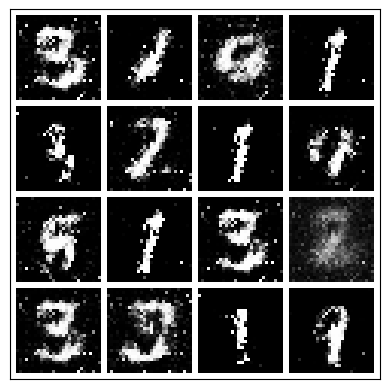

-------------------------------------
                Epoch 5: 
                Step: 500 | 
                D_real Loss: 0.3333 | 
                D_fake Loss: 0.1488 | 
                D_total Loss: 0.4821 | 
                G_Loss: 2.151 |
                Real_score 0.824 | 
                Fake_score 0.131 
            


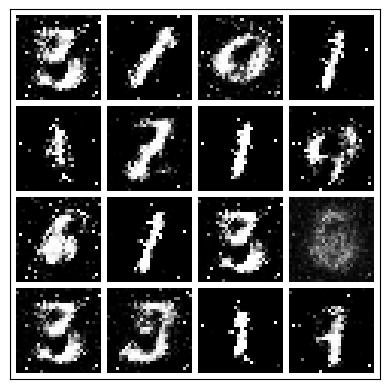

-------------------------------------
                Epoch 5: 
                Step: 1000 | 
                D_real Loss: 0.0842 | 
                D_fake Loss: 0.2175 | 
                D_total Loss: 0.3016 | 
                G_Loss: 1.863 |
                Real_score 0.948 | 
                Fake_score 0.183 
            


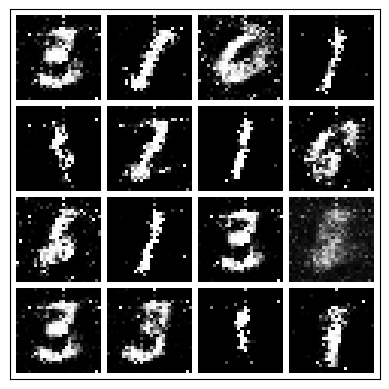

-------------------------------------
                Epoch 5: 
                Step: 1500 | 
                D_real Loss: 0.5111 | 
                D_fake Loss: 0.1405 | 
                D_total Loss: 0.6516 | 
                G_Loss: 2.183 |
                Real_score 0.731 | 
                Fake_score 0.128 
            


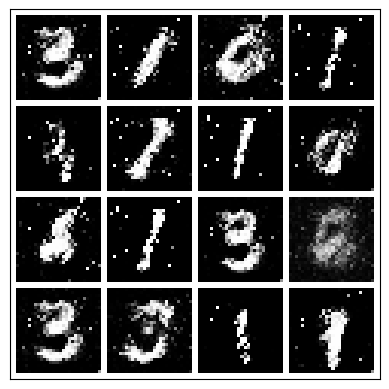

-------------------------------------
                Epoch 5: 
                Step: 2000 | 
                D_real Loss: 0.3903 | 
                D_fake Loss: 0.2741 | 
                D_total Loss: 0.6643 | 
                G_Loss: 1.841 |
                Real_score 0.795 | 
                Fake_score 0.225 
            


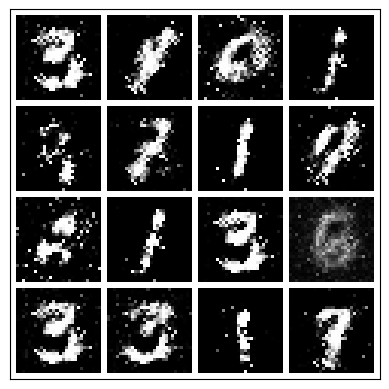

-------------------------------------
                Epoch 5: 
                Step: 2500 | 
                D_real Loss: 0.4278 | 
                D_fake Loss: 0.1060 | 
                D_total Loss: 0.5338 | 
                G_Loss: 2.286 |
                Real_score 0.740 | 
                Fake_score 0.096 
            


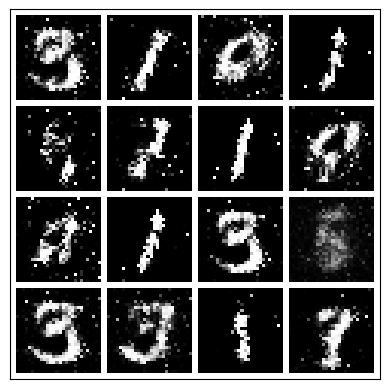

-------------------------------------
                Epoch 5: 
                Step: 3000 | 
                D_real Loss: 0.3212 | 
                D_fake Loss: 0.5465 | 
                D_total Loss: 0.8678 | 
                G_Loss: 1.865 |
                Real_score 0.803 | 
                Fake_score 0.343 
            


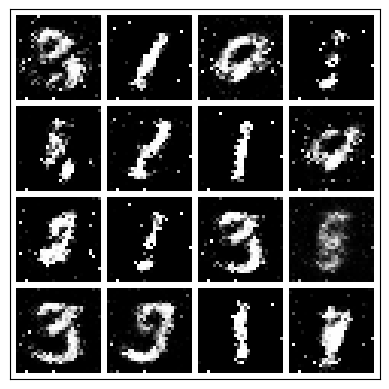

-------------------------------------
                Epoch 5: 
                Step: 3500 | 
                D_real Loss: 0.1828 | 
                D_fake Loss: 0.1971 | 
                D_total Loss: 0.3799 | 
                G_Loss: 2.714 |
                Real_score 0.895 | 
                Fake_score 0.167 
            


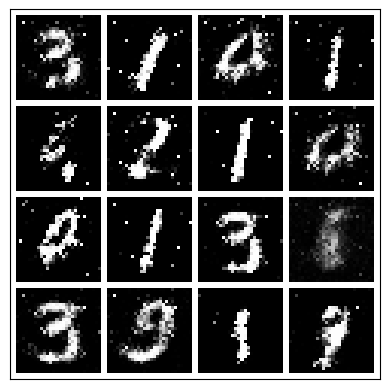

 10%|████▌                                        | 5/50 [04:41<40:21, 53.81s/it]

-------------------------------------
                Epoch 6: 
                Step: 0 | 
                D_real Loss: 0.1644 | 
                D_fake Loss: 0.2135 | 
                D_total Loss: 0.3779 | 
                G_Loss: 2.396 |
                Real_score 0.891 | 
                Fake_score 0.166 
            


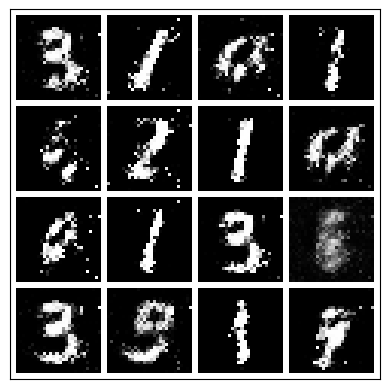

-------------------------------------
                Epoch 6: 
                Step: 500 | 
                D_real Loss: 0.3475 | 
                D_fake Loss: 0.1961 | 
                D_total Loss: 0.5436 | 
                G_Loss: 2.636 |
                Real_score 0.797 | 
                Fake_score 0.167 
            


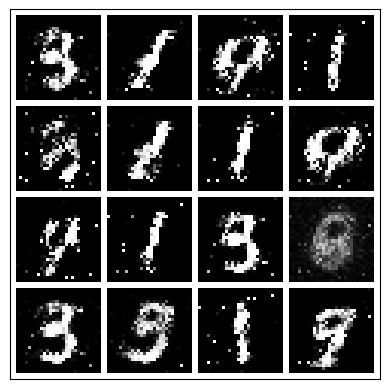

-------------------------------------
                Epoch 6: 
                Step: 1000 | 
                D_real Loss: 0.4063 | 
                D_fake Loss: 0.2345 | 
                D_total Loss: 0.6408 | 
                G_Loss: 1.597 |
                Real_score 0.730 | 
                Fake_score 0.196 
            


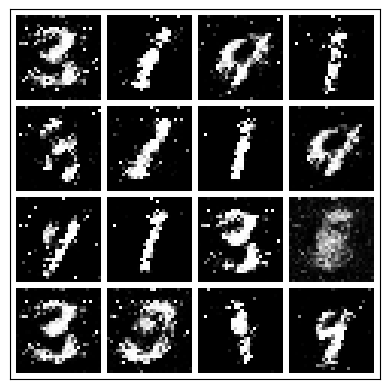

-------------------------------------
                Epoch 6: 
                Step: 1500 | 
                D_real Loss: 0.0985 | 
                D_fake Loss: 0.2784 | 
                D_total Loss: 0.3769 | 
                G_Loss: 2.036 |
                Real_score 0.924 | 
                Fake_score 0.189 
            


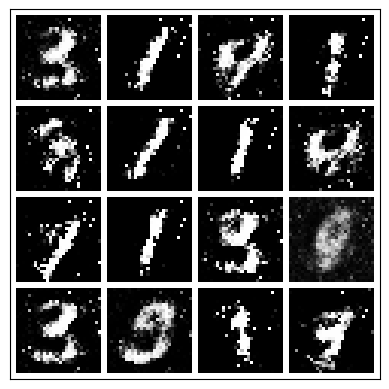

-------------------------------------
                Epoch 6: 
                Step: 2000 | 
                D_real Loss: 0.5433 | 
                D_fake Loss: 0.2629 | 
                D_total Loss: 0.8062 | 
                G_Loss: 2.249 |
                Real_score 0.710 | 
                Fake_score 0.210 
            


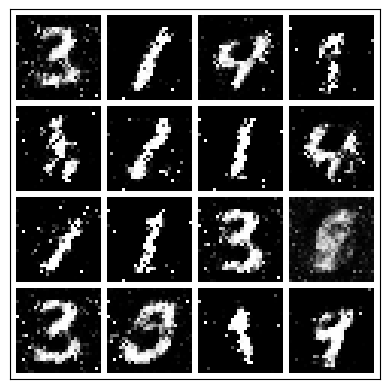

-------------------------------------
                Epoch 6: 
                Step: 2500 | 
                D_real Loss: 0.3418 | 
                D_fake Loss: 0.1892 | 
                D_total Loss: 0.5311 | 
                G_Loss: 2.331 |
                Real_score 0.766 | 
                Fake_score 0.151 
            


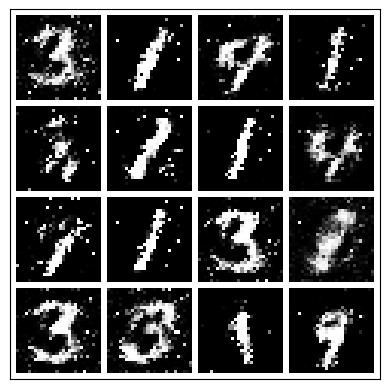

-------------------------------------
                Epoch 6: 
                Step: 3000 | 
                D_real Loss: 0.3832 | 
                D_fake Loss: 0.4398 | 
                D_total Loss: 0.8231 | 
                G_Loss: 2.344 |
                Real_score 0.758 | 
                Fake_score 0.287 
            


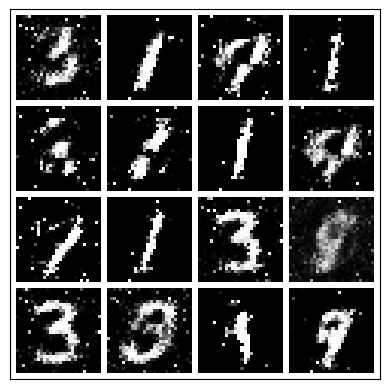

-------------------------------------
                Epoch 6: 
                Step: 3500 | 
                D_real Loss: 0.3582 | 
                D_fake Loss: 0.3083 | 
                D_total Loss: 0.6664 | 
                G_Loss: 1.733 |
                Real_score 0.802 | 
                Fake_score 0.228 
            


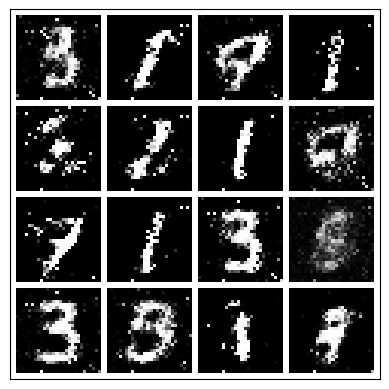

 12%|█████▍                                       | 6/50 [05:32<38:55, 53.08s/it]

-------------------------------------
                Epoch 7: 
                Step: 0 | 
                D_real Loss: 0.1277 | 
                D_fake Loss: 0.3426 | 
                D_total Loss: 0.4703 | 
                G_Loss: 1.650 |
                Real_score 0.909 | 
                Fake_score 0.263 
            


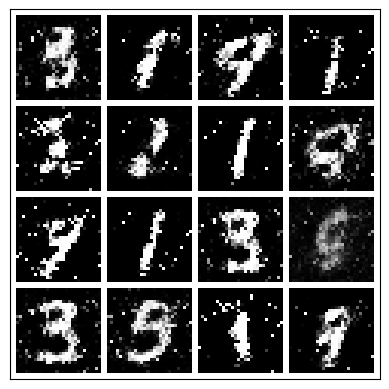

-------------------------------------
                Epoch 7: 
                Step: 500 | 
                D_real Loss: 0.2537 | 
                D_fake Loss: 0.4187 | 
                D_total Loss: 0.6724 | 
                G_Loss: 1.826 |
                Real_score 0.811 | 
                Fake_score 0.301 
            


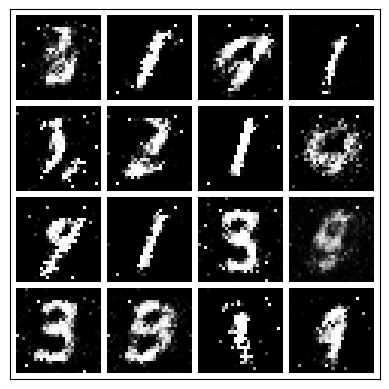

-------------------------------------
                Epoch 7: 
                Step: 1000 | 
                D_real Loss: 0.4664 | 
                D_fake Loss: 0.4814 | 
                D_total Loss: 0.9478 | 
                G_Loss: 1.422 |
                Real_score 0.741 | 
                Fake_score 0.325 
            


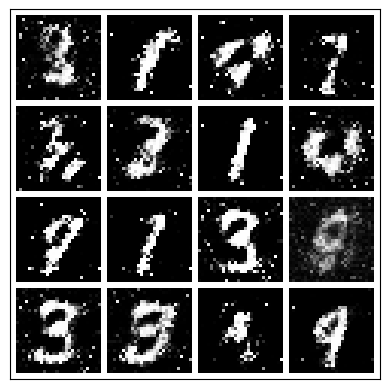

-------------------------------------
                Epoch 7: 
                Step: 1500 | 
                D_real Loss: 0.3436 | 
                D_fake Loss: 0.4097 | 
                D_total Loss: 0.7533 | 
                G_Loss: 1.565 |
                Real_score 0.768 | 
                Fake_score 0.287 
            


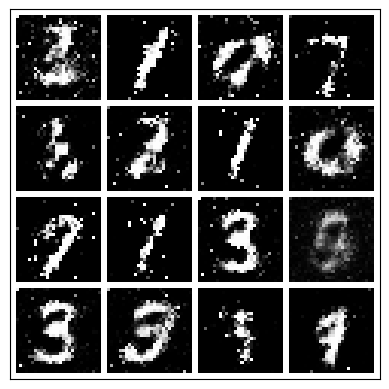

-------------------------------------
                Epoch 7: 
                Step: 2000 | 
                D_real Loss: 0.3840 | 
                D_fake Loss: 0.2314 | 
                D_total Loss: 0.6155 | 
                G_Loss: 2.393 |
                Real_score 0.785 | 
                Fake_score 0.193 
            


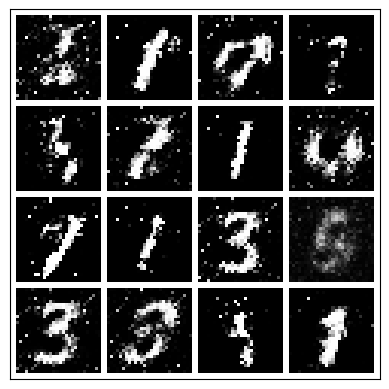

-------------------------------------
                Epoch 7: 
                Step: 2500 | 
                D_real Loss: 0.5498 | 
                D_fake Loss: 0.3060 | 
                D_total Loss: 0.8558 | 
                G_Loss: 1.825 |
                Real_score 0.724 | 
                Fake_score 0.246 
            


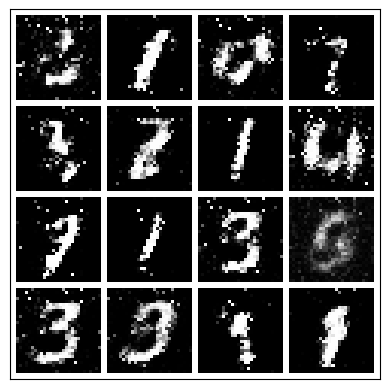

-------------------------------------
                Epoch 7: 
                Step: 3000 | 
                D_real Loss: 0.1453 | 
                D_fake Loss: 0.3974 | 
                D_total Loss: 0.5426 | 
                G_Loss: 1.804 |
                Real_score 0.882 | 
                Fake_score 0.264 
            


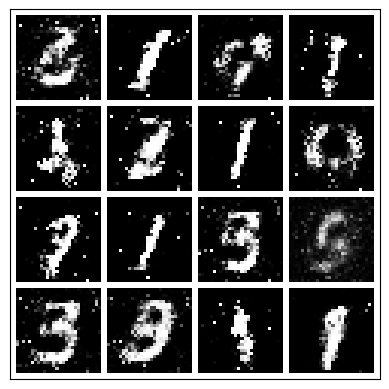

-------------------------------------
                Epoch 7: 
                Step: 3500 | 
                D_real Loss: 0.3072 | 
                D_fake Loss: 0.3844 | 
                D_total Loss: 0.6916 | 
                G_Loss: 1.876 |
                Real_score 0.818 | 
                Fake_score 0.271 
            


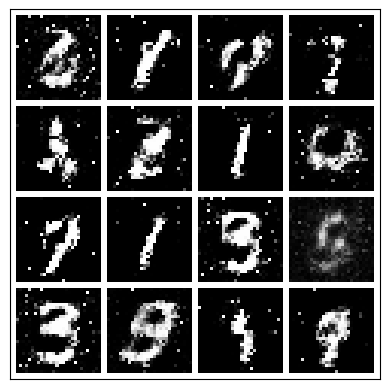

 14%|██████▎                                      | 7/50 [06:27<38:31, 53.76s/it]

-------------------------------------
                Epoch 8: 
                Step: 0 | 
                D_real Loss: 0.6139 | 
                D_fake Loss: 0.2798 | 
                D_total Loss: 0.8936 | 
                G_Loss: 1.800 |
                Real_score 0.676 | 
                Fake_score 0.229 
            


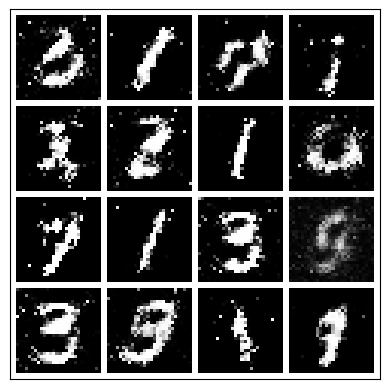

-------------------------------------
                Epoch 8: 
                Step: 500 | 
                D_real Loss: 0.3857 | 
                D_fake Loss: 0.0988 | 
                D_total Loss: 0.4845 | 
                G_Loss: 2.673 |
                Real_score 0.781 | 
                Fake_score 0.093 
            


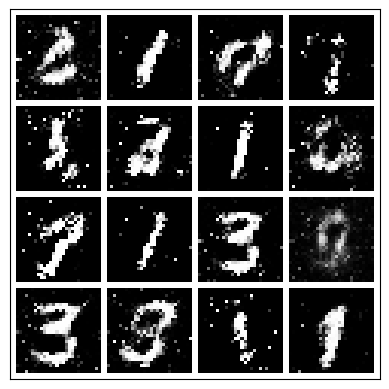

-------------------------------------
                Epoch 8: 
                Step: 1000 | 
                D_real Loss: 0.6003 | 
                D_fake Loss: 0.2881 | 
                D_total Loss: 0.8884 | 
                G_Loss: 1.824 |
                Real_score 0.601 | 
                Fake_score 0.232 
            


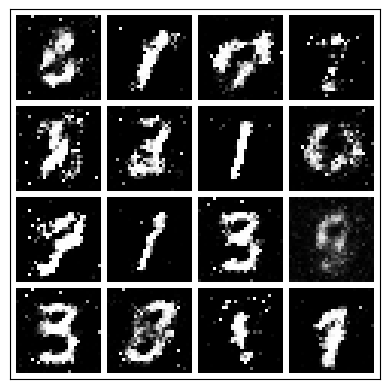

-------------------------------------
                Epoch 8: 
                Step: 1500 | 
                D_real Loss: 0.5173 | 
                D_fake Loss: 0.4307 | 
                D_total Loss: 0.9479 | 
                G_Loss: 1.378 |
                Real_score 0.673 | 
                Fake_score 0.296 
            


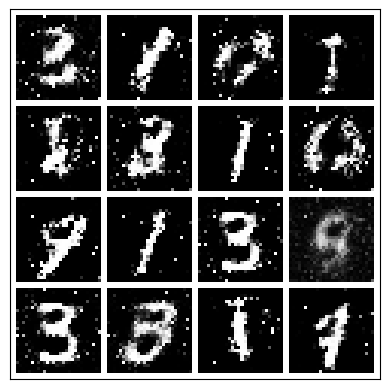

-------------------------------------
                Epoch 8: 
                Step: 2000 | 
                D_real Loss: 0.5366 | 
                D_fake Loss: 0.2873 | 
                D_total Loss: 0.8239 | 
                G_Loss: 1.527 |
                Real_score 0.672 | 
                Fake_score 0.237 
            


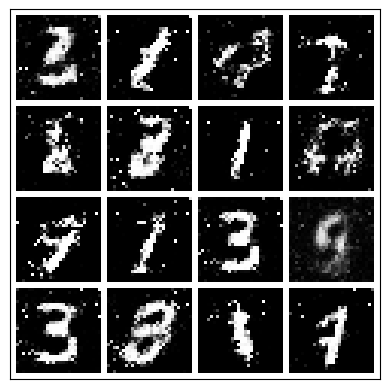

-------------------------------------
                Epoch 8: 
                Step: 2500 | 
                D_real Loss: 0.8645 | 
                D_fake Loss: 0.2466 | 
                D_total Loss: 1.1111 | 
                G_Loss: 1.853 |
                Real_score 0.604 | 
                Fake_score 0.206 
            


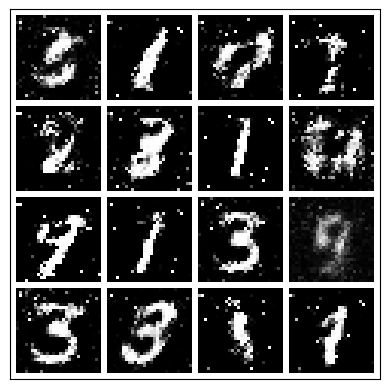

-------------------------------------
                Epoch 8: 
                Step: 3000 | 
                D_real Loss: 0.4983 | 
                D_fake Loss: 0.4816 | 
                D_total Loss: 0.9800 | 
                G_Loss: 1.598 |
                Real_score 0.669 | 
                Fake_score 0.323 
            


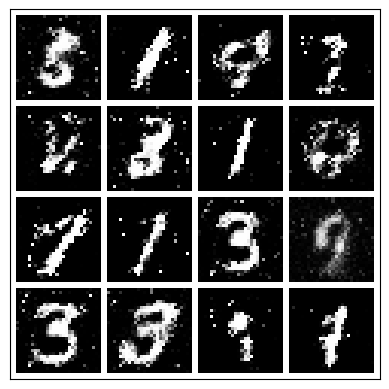

-------------------------------------
                Epoch 8: 
                Step: 3500 | 
                D_real Loss: 0.3675 | 
                D_fake Loss: 0.3837 | 
                D_total Loss: 0.7513 | 
                G_Loss: 1.364 |
                Real_score 0.760 | 
                Fake_score 0.296 
            


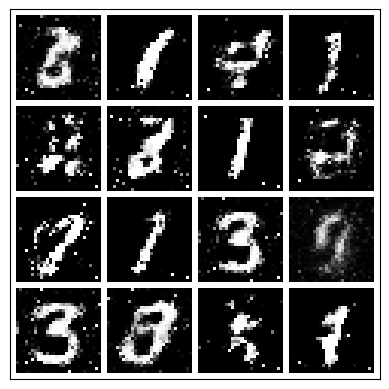

 16%|███████▏                                     | 8/50 [07:17<36:46, 52.53s/it]

-------------------------------------
                Epoch 9: 
                Step: 0 | 
                D_real Loss: 0.4680 | 
                D_fake Loss: 0.2910 | 
                D_total Loss: 0.7590 | 
                G_Loss: 1.905 |
                Real_score 0.695 | 
                Fake_score 0.206 
            


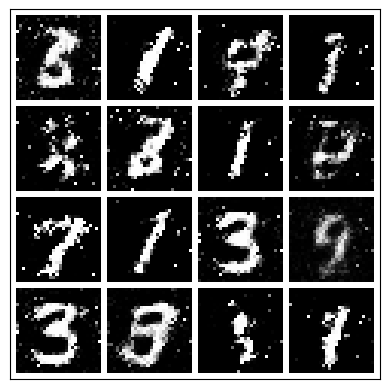

-------------------------------------
                Epoch 9: 
                Step: 500 | 
                D_real Loss: 0.6937 | 
                D_fake Loss: 0.2951 | 
                D_total Loss: 0.9889 | 
                G_Loss: 2.309 |
                Real_score 0.589 | 
                Fake_score 0.233 
            


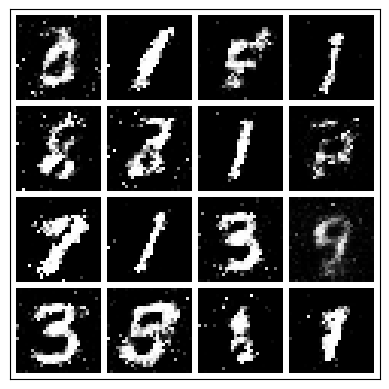

-------------------------------------
                Epoch 9: 
                Step: 1000 | 
                D_real Loss: 0.4376 | 
                D_fake Loss: 0.1812 | 
                D_total Loss: 0.6188 | 
                G_Loss: 2.022 |
                Real_score 0.712 | 
                Fake_score 0.159 
            


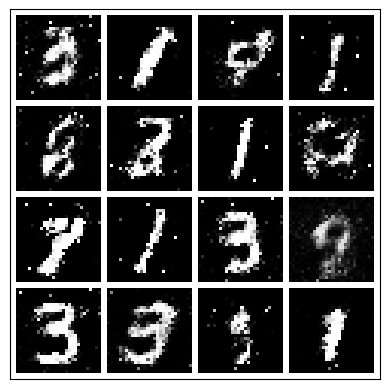

-------------------------------------
                Epoch 9: 
                Step: 1500 | 
                D_real Loss: 0.3390 | 
                D_fake Loss: 0.4346 | 
                D_total Loss: 0.7737 | 
                G_Loss: 1.717 |
                Real_score 0.755 | 
                Fake_score 0.278 
            


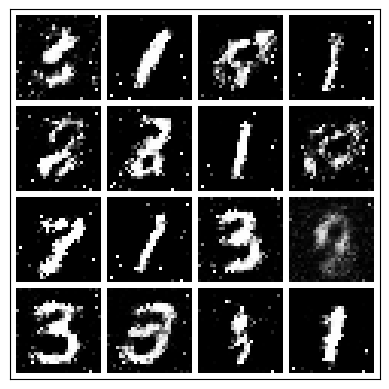

-------------------------------------
                Epoch 9: 
                Step: 2000 | 
                D_real Loss: 0.4732 | 
                D_fake Loss: 0.7136 | 
                D_total Loss: 1.1868 | 
                G_Loss: 1.417 |
                Real_score 0.712 | 
                Fake_score 0.435 
            


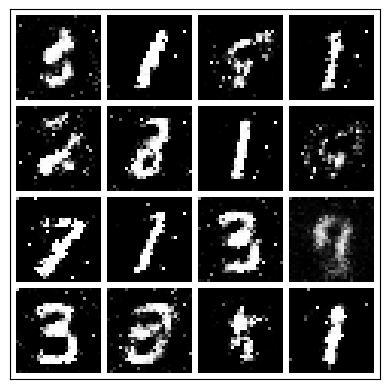

-------------------------------------
                Epoch 9: 
                Step: 2500 | 
                D_real Loss: 0.4375 | 
                D_fake Loss: 0.2488 | 
                D_total Loss: 0.6864 | 
                G_Loss: 1.750 |
                Real_score 0.741 | 
                Fake_score 0.210 
            


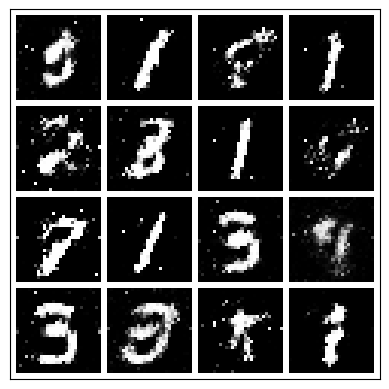

-------------------------------------
                Epoch 9: 
                Step: 3000 | 
                D_real Loss: 0.3566 | 
                D_fake Loss: 0.2981 | 
                D_total Loss: 0.6547 | 
                G_Loss: 1.557 |
                Real_score 0.761 | 
                Fake_score 0.232 
            


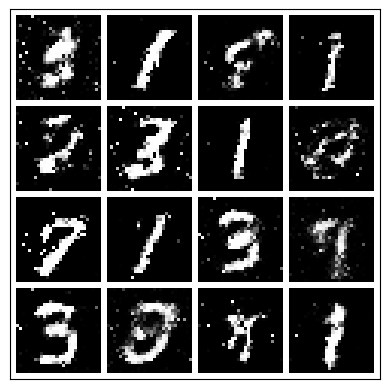

-------------------------------------
                Epoch 9: 
                Step: 3500 | 
                D_real Loss: 0.1150 | 
                D_fake Loss: 0.3985 | 
                D_total Loss: 0.5135 | 
                G_Loss: 1.632 |
                Real_score 0.902 | 
                Fake_score 0.288 
            


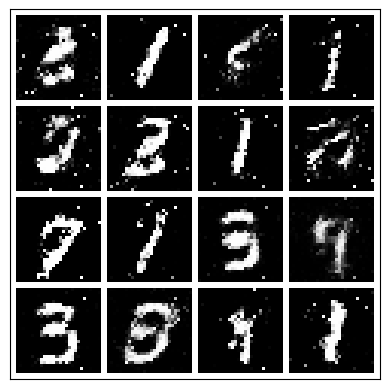

 18%|████████                                     | 9/50 [08:09<35:37, 52.13s/it]

-------------------------------------
                Epoch 10: 
                Step: 0 | 
                D_real Loss: 0.6442 | 
                D_fake Loss: 0.4652 | 
                D_total Loss: 1.1094 | 
                G_Loss: 1.367 |
                Real_score 0.656 | 
                Fake_score 0.343 
            


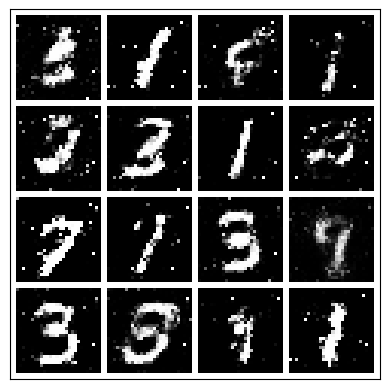

-------------------------------------
                Epoch 10: 
                Step: 500 | 
                D_real Loss: 0.6467 | 
                D_fake Loss: 0.2835 | 
                D_total Loss: 0.9302 | 
                G_Loss: 1.965 |
                Real_score 0.595 | 
                Fake_score 0.220 
            


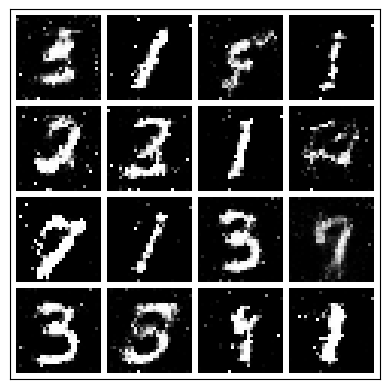

-------------------------------------
                Epoch 10: 
                Step: 1000 | 
                D_real Loss: 0.6105 | 
                D_fake Loss: 0.5465 | 
                D_total Loss: 1.1569 | 
                G_Loss: 1.253 |
                Real_score 0.642 | 
                Fake_score 0.370 
            


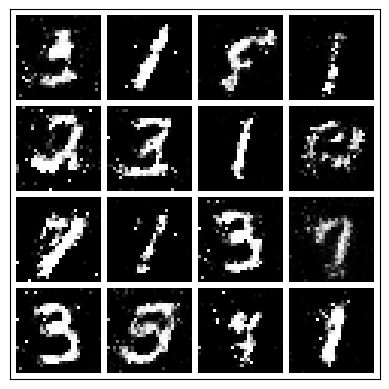

-------------------------------------
                Epoch 10: 
                Step: 1500 | 
                D_real Loss: 0.4189 | 
                D_fake Loss: 0.6044 | 
                D_total Loss: 1.0233 | 
                G_Loss: 1.115 |
                Real_score 0.711 | 
                Fake_score 0.396 
            


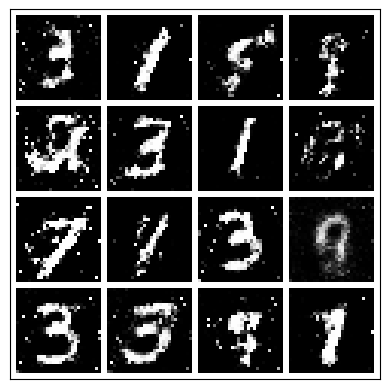

-------------------------------------
                Epoch 10: 
                Step: 2000 | 
                D_real Loss: 0.2352 | 
                D_fake Loss: 0.5671 | 
                D_total Loss: 0.8023 | 
                G_Loss: 1.398 |
                Real_score 0.823 | 
                Fake_score 0.341 
            


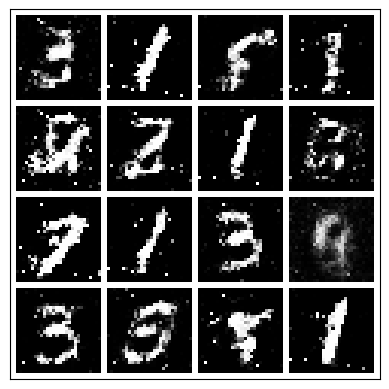

-------------------------------------
                Epoch 10: 
                Step: 2500 | 
                D_real Loss: 0.8314 | 
                D_fake Loss: 0.4548 | 
                D_total Loss: 1.2862 | 
                G_Loss: 1.495 |
                Real_score 0.554 | 
                Fake_score 0.316 
            


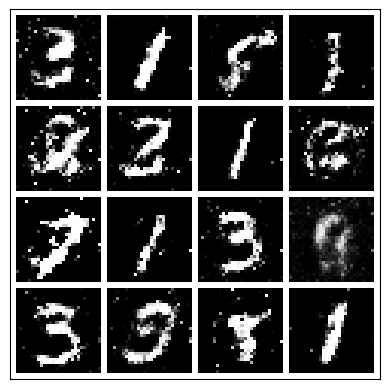

-------------------------------------
                Epoch 10: 
                Step: 3000 | 
                D_real Loss: 0.5512 | 
                D_fake Loss: 0.4337 | 
                D_total Loss: 0.9848 | 
                G_Loss: 1.541 |
                Real_score 0.667 | 
                Fake_score 0.334 
            


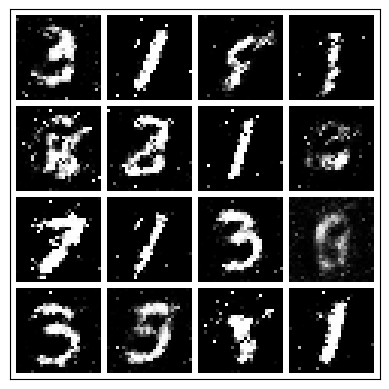

-------------------------------------
                Epoch 10: 
                Step: 3500 | 
                D_real Loss: 0.3718 | 
                D_fake Loss: 0.4938 | 
                D_total Loss: 0.8656 | 
                G_Loss: 1.255 |
                Real_score 0.737 | 
                Fake_score 0.358 
            


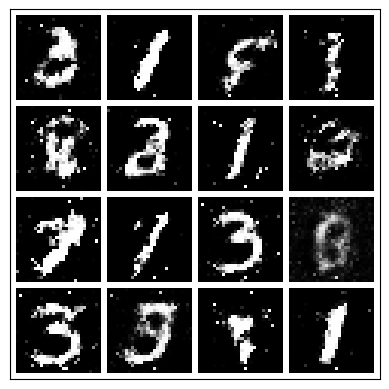

 20%|████████▊                                   | 10/50 [09:03<35:14, 52.87s/it]

-------------------------------------
                Epoch 11: 
                Step: 0 | 
                D_real Loss: 0.6248 | 
                D_fake Loss: 0.3469 | 
                D_total Loss: 0.9718 | 
                G_Loss: 1.340 |
                Real_score 0.631 | 
                Fake_score 0.277 
            


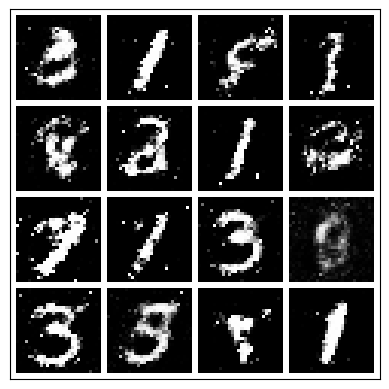

-------------------------------------
                Epoch 11: 
                Step: 500 | 
                D_real Loss: 0.2492 | 
                D_fake Loss: 0.6327 | 
                D_total Loss: 0.8820 | 
                G_Loss: 1.089 |
                Real_score 0.826 | 
                Fake_score 0.398 
            


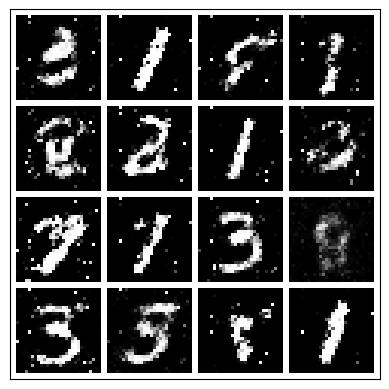

-------------------------------------
                Epoch 11: 
                Step: 1000 | 
                D_real Loss: 0.5203 | 
                D_fake Loss: 0.3342 | 
                D_total Loss: 0.8545 | 
                G_Loss: 1.834 |
                Real_score 0.671 | 
                Fake_score 0.249 
            


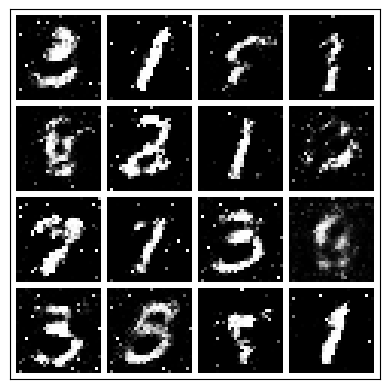

-------------------------------------
                Epoch 11: 
                Step: 1500 | 
                D_real Loss: 0.4367 | 
                D_fake Loss: 0.4628 | 
                D_total Loss: 0.8995 | 
                G_Loss: 1.361 |
                Real_score 0.758 | 
                Fake_score 0.304 
            


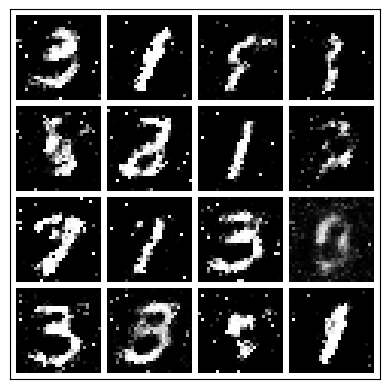

-------------------------------------
                Epoch 11: 
                Step: 2000 | 
                D_real Loss: 0.5161 | 
                D_fake Loss: 0.4170 | 
                D_total Loss: 0.9331 | 
                G_Loss: 1.424 |
                Real_score 0.695 | 
                Fake_score 0.312 
            


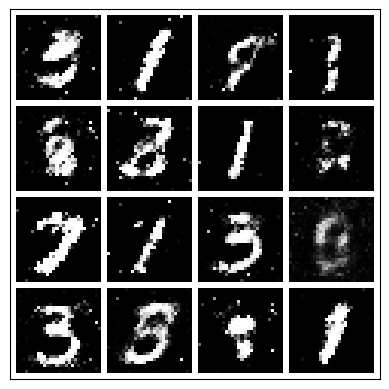

-------------------------------------
                Epoch 11: 
                Step: 2500 | 
                D_real Loss: 0.7819 | 
                D_fake Loss: 0.2791 | 
                D_total Loss: 1.0610 | 
                G_Loss: 1.951 |
                Real_score 0.574 | 
                Fake_score 0.228 
            


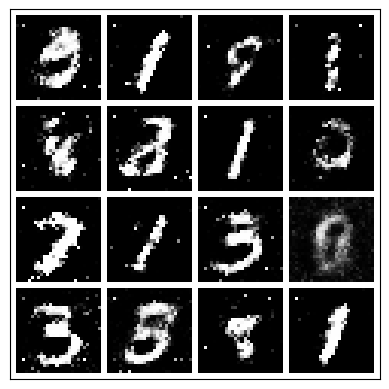

-------------------------------------
                Epoch 11: 
                Step: 3000 | 
                D_real Loss: 0.8496 | 
                D_fake Loss: 0.2744 | 
                D_total Loss: 1.1239 | 
                G_Loss: 1.612 |
                Real_score 0.544 | 
                Fake_score 0.218 
            


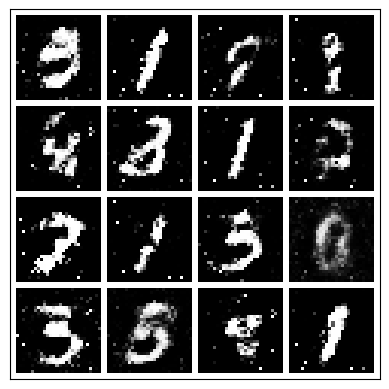

-------------------------------------
                Epoch 11: 
                Step: 3500 | 
                D_real Loss: 0.2378 | 
                D_fake Loss: 0.2546 | 
                D_total Loss: 0.4924 | 
                G_Loss: 1.893 |
                Real_score 0.822 | 
                Fake_score 0.198 
            


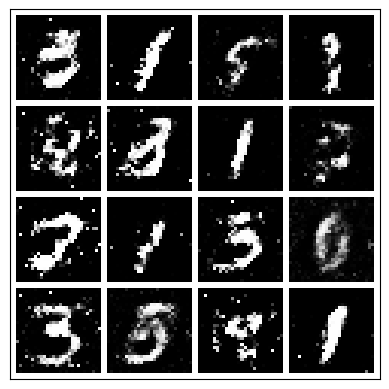

 22%|█████████▋                                  | 11/50 [09:54<34:03, 52.39s/it]

-------------------------------------
                Epoch 12: 
                Step: 0 | 
                D_real Loss: 0.2713 | 
                D_fake Loss: 0.4670 | 
                D_total Loss: 0.7383 | 
                G_Loss: 1.517 |
                Real_score 0.806 | 
                Fake_score 0.306 
            


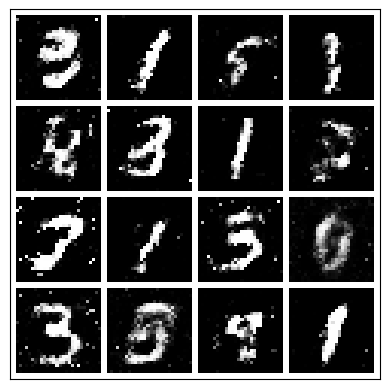

-------------------------------------
                Epoch 12: 
                Step: 500 | 
                D_real Loss: 0.2293 | 
                D_fake Loss: 0.3590 | 
                D_total Loss: 0.5883 | 
                G_Loss: 1.310 |
                Real_score 0.850 | 
                Fake_score 0.279 
            


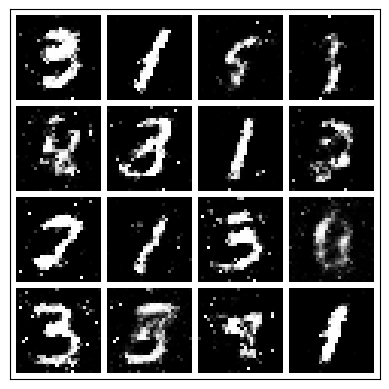

-------------------------------------
                Epoch 12: 
                Step: 1000 | 
                D_real Loss: 0.3941 | 
                D_fake Loss: 0.4707 | 
                D_total Loss: 0.8649 | 
                G_Loss: 1.276 |
                Real_score 0.711 | 
                Fake_score 0.350 
            


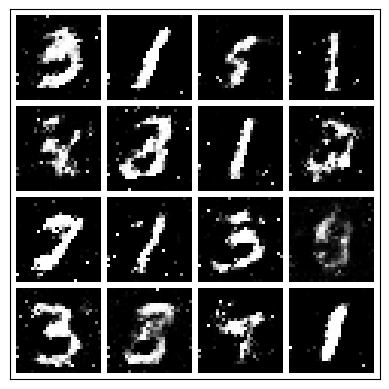

-------------------------------------
                Epoch 12: 
                Step: 1500 | 
                D_real Loss: 0.4003 | 
                D_fake Loss: 0.9374 | 
                D_total Loss: 1.3377 | 
                G_Loss: 1.173 |
                Real_score 0.760 | 
                Fake_score 0.408 
            


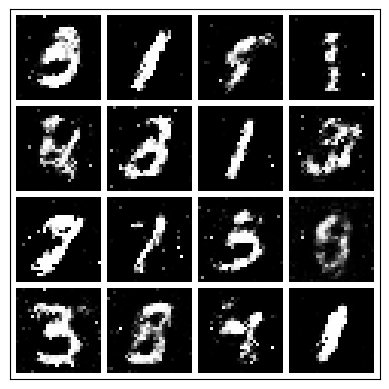

-------------------------------------
                Epoch 12: 
                Step: 2000 | 
                D_real Loss: 0.5756 | 
                D_fake Loss: 0.3919 | 
                D_total Loss: 0.9675 | 
                G_Loss: 1.371 |
                Real_score 0.642 | 
                Fake_score 0.302 
            


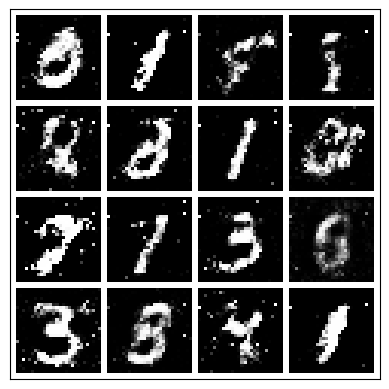

-------------------------------------
                Epoch 12: 
                Step: 2500 | 
                D_real Loss: 0.4220 | 
                D_fake Loss: 0.5309 | 
                D_total Loss: 0.9529 | 
                G_Loss: 1.469 |
                Real_score 0.740 | 
                Fake_score 0.332 
            


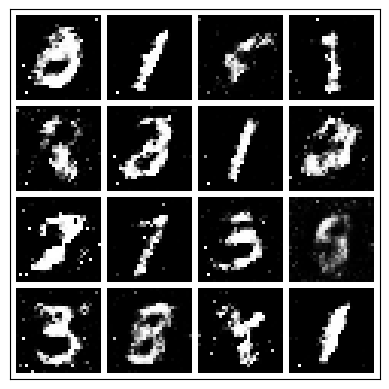

-------------------------------------
                Epoch 12: 
                Step: 3000 | 
                D_real Loss: 0.5307 | 
                D_fake Loss: 0.4442 | 
                D_total Loss: 0.9749 | 
                G_Loss: 1.791 |
                Real_score 0.681 | 
                Fake_score 0.295 
            


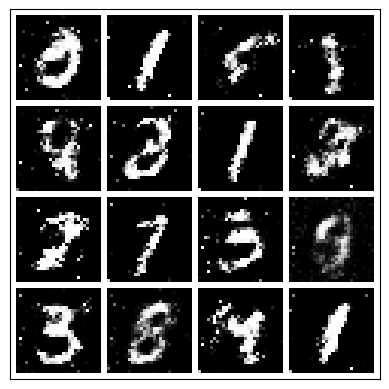

-------------------------------------
                Epoch 12: 
                Step: 3500 | 
                D_real Loss: 0.5231 | 
                D_fake Loss: 0.3943 | 
                D_total Loss: 0.9174 | 
                G_Loss: 1.595 |
                Real_score 0.674 | 
                Fake_score 0.291 
            


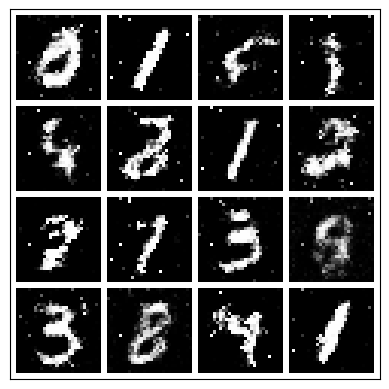

 24%|██████████▌                                 | 12/50 [10:45<32:54, 51.96s/it]

-------------------------------------
                Epoch 13: 
                Step: 0 | 
                D_real Loss: 0.5320 | 
                D_fake Loss: 0.4100 | 
                D_total Loss: 0.9421 | 
                G_Loss: 1.421 |
                Real_score 0.712 | 
                Fake_score 0.281 
            


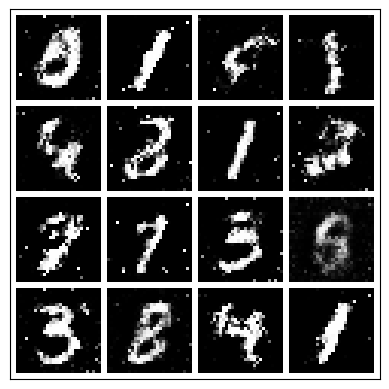

-------------------------------------
                Epoch 13: 
                Step: 500 | 
                D_real Loss: 0.4683 | 
                D_fake Loss: 0.5902 | 
                D_total Loss: 1.0585 | 
                G_Loss: 0.913 |
                Real_score 0.694 | 
                Fake_score 0.419 
            


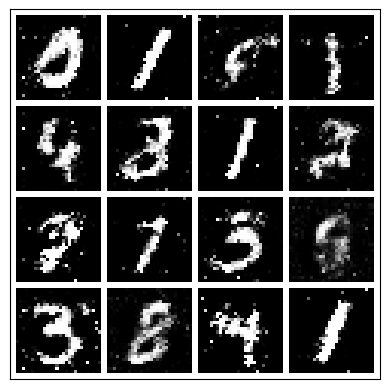

-------------------------------------
                Epoch 13: 
                Step: 1000 | 
                D_real Loss: 0.5591 | 
                D_fake Loss: 0.4544 | 
                D_total Loss: 1.0135 | 
                G_Loss: 1.482 |
                Real_score 0.641 | 
                Fake_score 0.322 
            


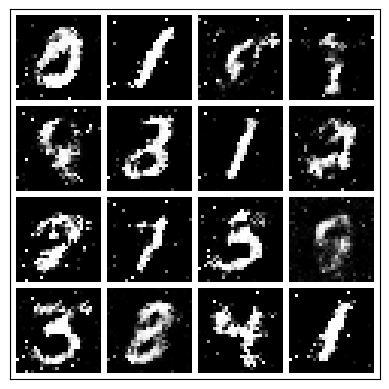

-------------------------------------
                Epoch 13: 
                Step: 1500 | 
                D_real Loss: 0.3796 | 
                D_fake Loss: 0.6157 | 
                D_total Loss: 0.9953 | 
                G_Loss: 1.363 |
                Real_score 0.725 | 
                Fake_score 0.300 
            


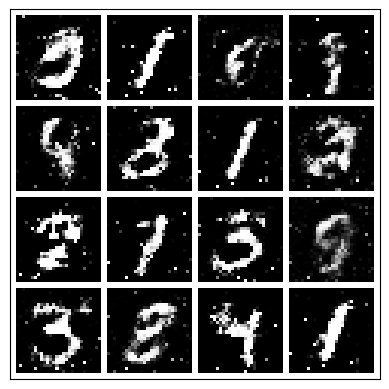

-------------------------------------
                Epoch 13: 
                Step: 2000 | 
                D_real Loss: 0.7397 | 
                D_fake Loss: 0.4169 | 
                D_total Loss: 1.1566 | 
                G_Loss: 1.810 |
                Real_score 0.614 | 
                Fake_score 0.287 
            


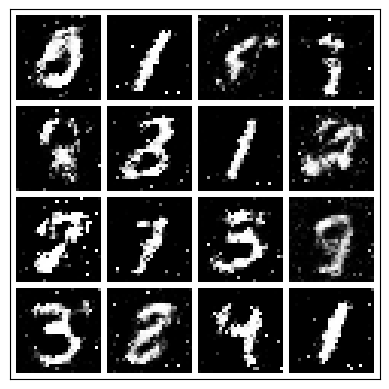

-------------------------------------
                Epoch 13: 
                Step: 2500 | 
                D_real Loss: 0.4408 | 
                D_fake Loss: 0.6304 | 
                D_total Loss: 1.0712 | 
                G_Loss: 1.586 |
                Real_score 0.734 | 
                Fake_score 0.374 
            


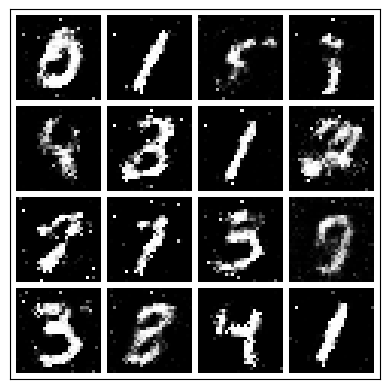

-------------------------------------
                Epoch 13: 
                Step: 3000 | 
                D_real Loss: 0.3229 | 
                D_fake Loss: 0.6721 | 
                D_total Loss: 0.9951 | 
                G_Loss: 1.125 |
                Real_score 0.763 | 
                Fake_score 0.453 
            


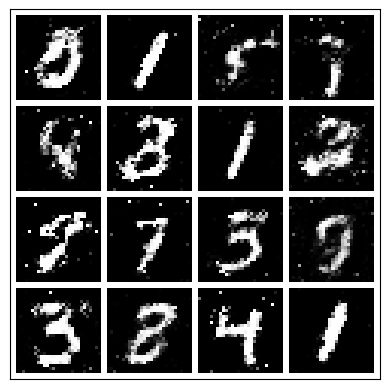

-------------------------------------
                Epoch 13: 
                Step: 3500 | 
                D_real Loss: 0.6012 | 
                D_fake Loss: 0.5441 | 
                D_total Loss: 1.1453 | 
                G_Loss: 1.198 |
                Real_score 0.639 | 
                Fake_score 0.364 
            


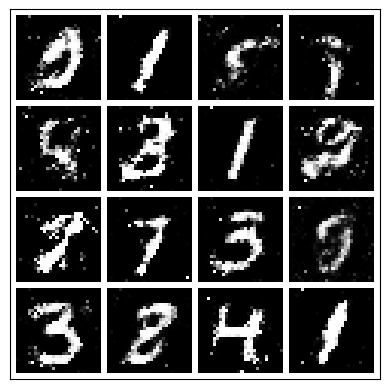

 26%|██████████▋                              | 13/50 [16:30<1:26:36, 140.46s/it]

-------------------------------------
                Epoch 14: 
                Step: 0 | 
                D_real Loss: 0.2740 | 
                D_fake Loss: 0.3551 | 
                D_total Loss: 0.6292 | 
                G_Loss: 1.501 |
                Real_score 0.799 | 
                Fake_score 0.279 
            


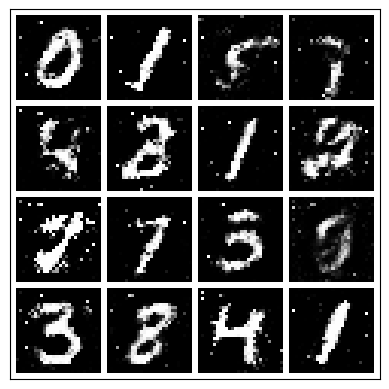

-------------------------------------
                Epoch 14: 
                Step: 500 | 
                D_real Loss: 0.4609 | 
                D_fake Loss: 0.3917 | 
                D_total Loss: 0.8526 | 
                G_Loss: 1.370 |
                Real_score 0.697 | 
                Fake_score 0.303 
            


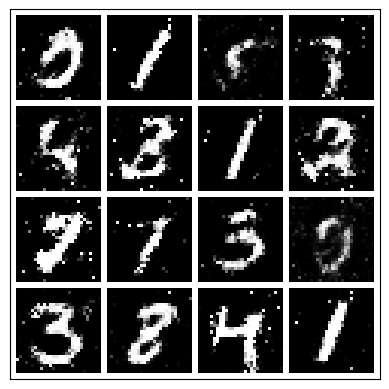

-------------------------------------
                Epoch 14: 
                Step: 1000 | 
                D_real Loss: 0.4612 | 
                D_fake Loss: 0.2495 | 
                D_total Loss: 0.7107 | 
                G_Loss: 1.816 |
                Real_score 0.689 | 
                Fake_score 0.214 
            


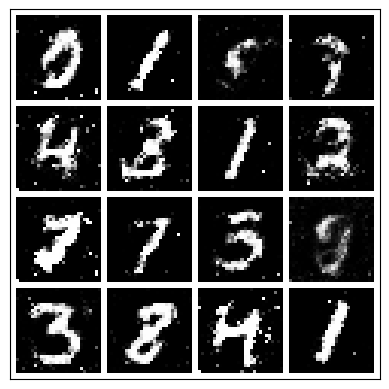

-------------------------------------
                Epoch 14: 
                Step: 1500 | 
                D_real Loss: 0.4224 | 
                D_fake Loss: 0.7124 | 
                D_total Loss: 1.1348 | 
                G_Loss: 0.777 |
                Real_score 0.702 | 
                Fake_score 0.438 
            


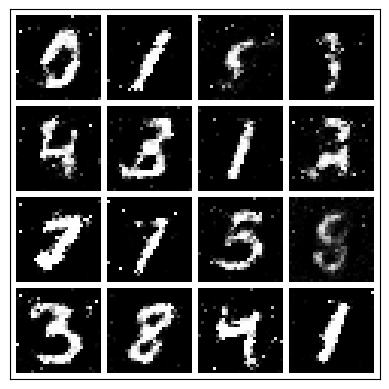

-------------------------------------
                Epoch 14: 
                Step: 2000 | 
                D_real Loss: 0.3426 | 
                D_fake Loss: 0.4578 | 
                D_total Loss: 0.8005 | 
                G_Loss: 1.361 |
                Real_score 0.734 | 
                Fake_score 0.344 
            


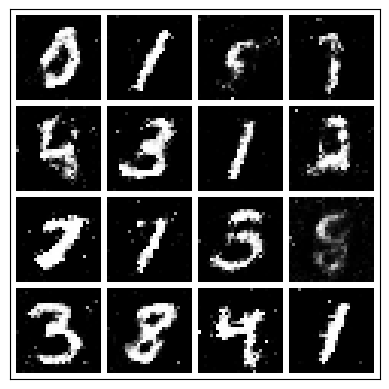

-------------------------------------
                Epoch 14: 
                Step: 2500 | 
                D_real Loss: 0.5532 | 
                D_fake Loss: 0.4183 | 
                D_total Loss: 0.9715 | 
                G_Loss: 1.447 |
                Real_score 0.617 | 
                Fake_score 0.297 
            


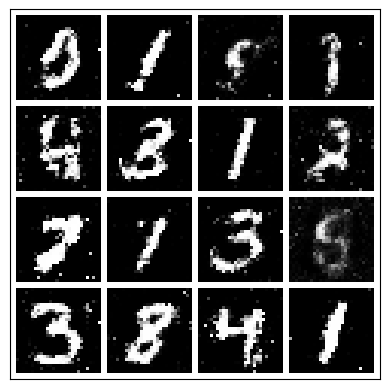

-------------------------------------
                Epoch 14: 
                Step: 3000 | 
                D_real Loss: 0.5431 | 
                D_fake Loss: 0.3712 | 
                D_total Loss: 0.9143 | 
                G_Loss: 1.495 |
                Real_score 0.658 | 
                Fake_score 0.287 
            


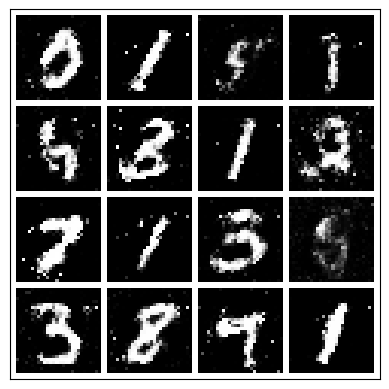

-------------------------------------
                Epoch 14: 
                Step: 3500 | 
                D_real Loss: 0.3335 | 
                D_fake Loss: 0.4140 | 
                D_total Loss: 0.7475 | 
                G_Loss: 1.236 |
                Real_score 0.749 | 
                Fake_score 0.306 
            


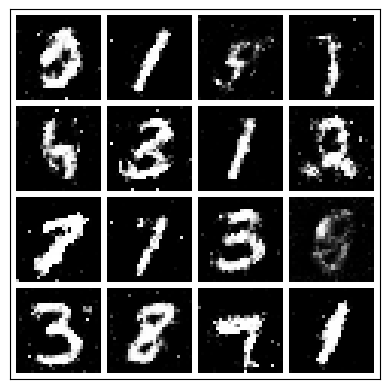

 28%|███████████▍                             | 14/50 [22:45<2:06:56, 211.57s/it]

-------------------------------------
                Epoch 15: 
                Step: 0 | 
                D_real Loss: 0.4777 | 
                D_fake Loss: 0.5107 | 
                D_total Loss: 0.9883 | 
                G_Loss: 1.418 |
                Real_score 0.656 | 
                Fake_score 0.352 
            


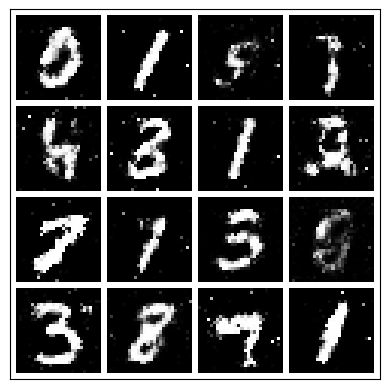

-------------------------------------
                Epoch 15: 
                Step: 500 | 
                D_real Loss: 0.5448 | 
                D_fake Loss: 0.7192 | 
                D_total Loss: 1.2640 | 
                G_Loss: 1.027 |
                Real_score 0.662 | 
                Fake_score 0.383 
            


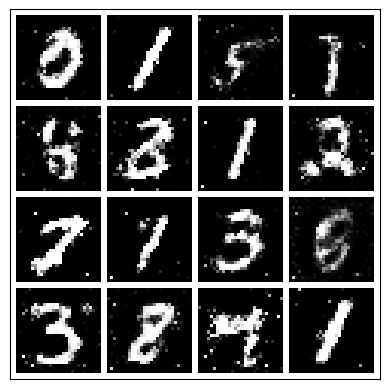

-------------------------------------
                Epoch 15: 
                Step: 1000 | 
                D_real Loss: 0.4142 | 
                D_fake Loss: 0.5905 | 
                D_total Loss: 1.0047 | 
                G_Loss: 1.223 |
                Real_score 0.706 | 
                Fake_score 0.389 
            


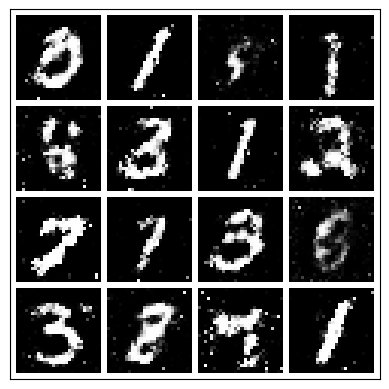

-------------------------------------
                Epoch 15: 
                Step: 1500 | 
                D_real Loss: 0.5782 | 
                D_fake Loss: 0.4089 | 
                D_total Loss: 0.9872 | 
                G_Loss: 1.748 |
                Real_score 0.640 | 
                Fake_score 0.288 
            


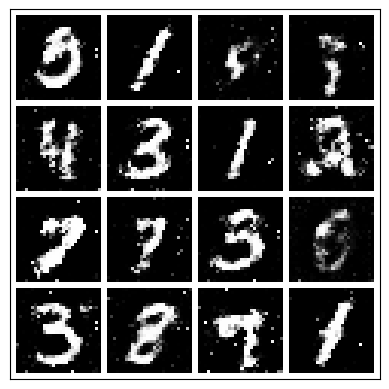

-------------------------------------
                Epoch 15: 
                Step: 2000 | 
                D_real Loss: 0.5927 | 
                D_fake Loss: 0.2090 | 
                D_total Loss: 0.8018 | 
                G_Loss: 1.635 |
                Real_score 0.649 | 
                Fake_score 0.184 
            


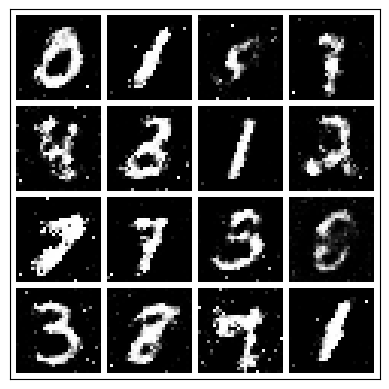

-------------------------------------
                Epoch 15: 
                Step: 2500 | 
                D_real Loss: 0.5136 | 
                D_fake Loss: 0.4332 | 
                D_total Loss: 0.9468 | 
                G_Loss: 0.974 |
                Real_score 0.660 | 
                Fake_score 0.334 
            


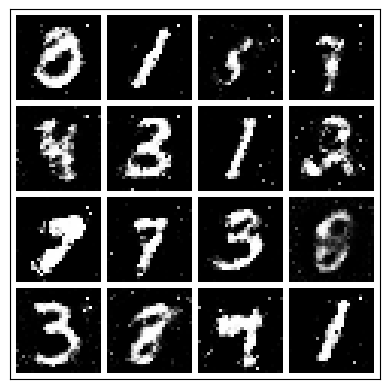

-------------------------------------
                Epoch 15: 
                Step: 3000 | 
                D_real Loss: 0.7909 | 
                D_fake Loss: 0.4242 | 
                D_total Loss: 1.2151 | 
                G_Loss: 1.173 |
                Real_score 0.528 | 
                Fake_score 0.330 
            


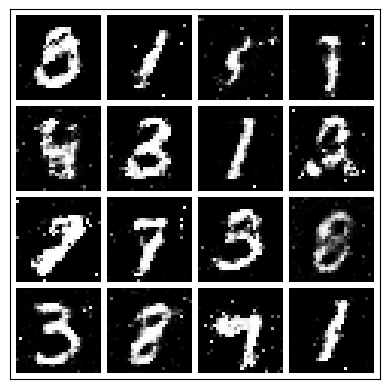

-------------------------------------
                Epoch 15: 
                Step: 3500 | 
                D_real Loss: 0.7718 | 
                D_fake Loss: 0.2894 | 
                D_total Loss: 1.0611 | 
                G_Loss: 1.375 |
                Real_score 0.590 | 
                Fake_score 0.240 
            


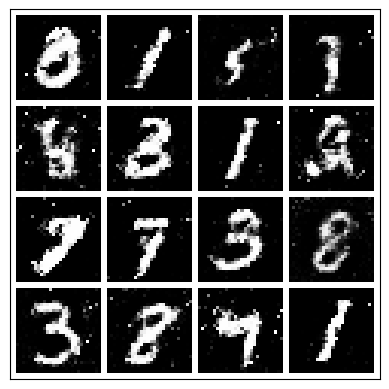

 30%|████████████▎                            | 15/50 [24:13<1:41:35, 174.15s/it]

-------------------------------------
                Epoch 16: 
                Step: 0 | 
                D_real Loss: 0.6067 | 
                D_fake Loss: 0.3597 | 
                D_total Loss: 0.9664 | 
                G_Loss: 1.557 |
                Real_score 0.587 | 
                Fake_score 0.250 
            


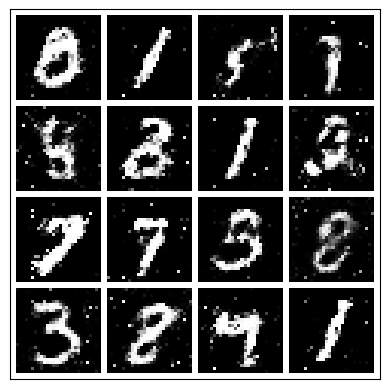

-------------------------------------
                Epoch 16: 
                Step: 500 | 
                D_real Loss: 0.3247 | 
                D_fake Loss: 0.3619 | 
                D_total Loss: 0.6866 | 
                G_Loss: 1.268 |
                Real_score 0.768 | 
                Fake_score 0.295 
            


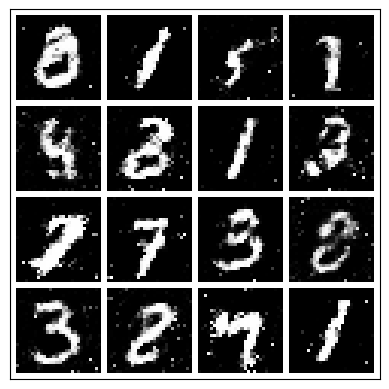

-------------------------------------
                Epoch 16: 
                Step: 1000 | 
                D_real Loss: 0.4799 | 
                D_fake Loss: 0.3831 | 
                D_total Loss: 0.8630 | 
                G_Loss: 1.832 |
                Real_score 0.693 | 
                Fake_score 0.292 
            


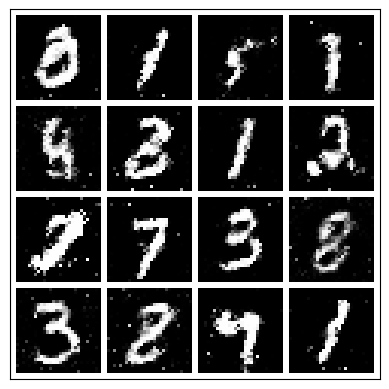

-------------------------------------
                Epoch 16: 
                Step: 1500 | 
                D_real Loss: 0.5529 | 
                D_fake Loss: 0.4769 | 
                D_total Loss: 1.0298 | 
                G_Loss: 1.360 |
                Real_score 0.638 | 
                Fake_score 0.363 
            


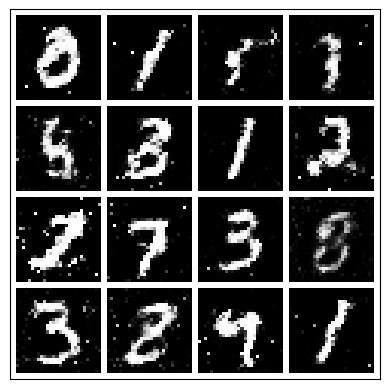

-------------------------------------
                Epoch 16: 
                Step: 2000 | 
                D_real Loss: 0.4997 | 
                D_fake Loss: 0.5758 | 
                D_total Loss: 1.0755 | 
                G_Loss: 0.983 |
                Real_score 0.637 | 
                Fake_score 0.399 
            


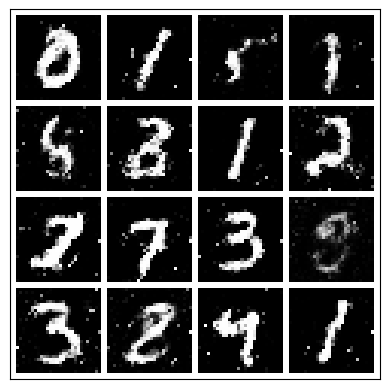

-------------------------------------
                Epoch 16: 
                Step: 2500 | 
                D_real Loss: 0.4989 | 
                D_fake Loss: 0.5786 | 
                D_total Loss: 1.0775 | 
                G_Loss: 1.312 |
                Real_score 0.698 | 
                Fake_score 0.376 
            


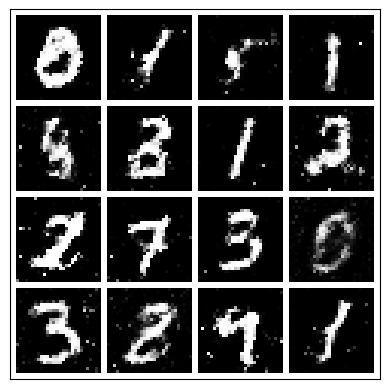

-------------------------------------
                Epoch 16: 
                Step: 3000 | 
                D_real Loss: 0.4055 | 
                D_fake Loss: 0.5684 | 
                D_total Loss: 0.9739 | 
                G_Loss: 1.170 |
                Real_score 0.706 | 
                Fake_score 0.386 
            


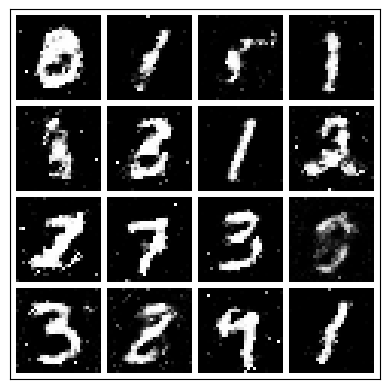

-------------------------------------
                Epoch 16: 
                Step: 3500 | 
                D_real Loss: 0.4353 | 
                D_fake Loss: 0.6454 | 
                D_total Loss: 1.0807 | 
                G_Loss: 1.380 |
                Real_score 0.692 | 
                Fake_score 0.384 
            


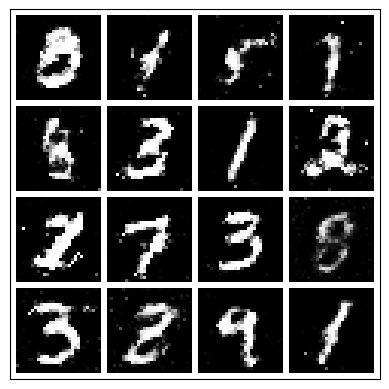

 32%|█████████████                            | 16/50 [25:42<1:24:07, 148.47s/it]

-------------------------------------
                Epoch 17: 
                Step: 0 | 
                D_real Loss: 0.3914 | 
                D_fake Loss: 0.5887 | 
                D_total Loss: 0.9801 | 
                G_Loss: 1.337 |
                Real_score 0.748 | 
                Fake_score 0.386 
            


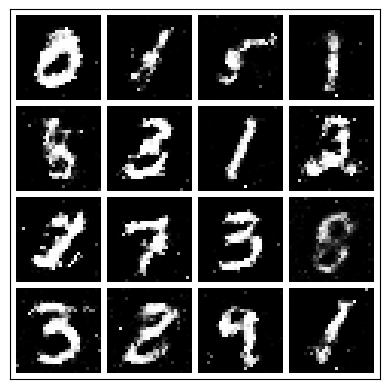

-------------------------------------
                Epoch 17: 
                Step: 500 | 
                D_real Loss: 0.3379 | 
                D_fake Loss: 0.6551 | 
                D_total Loss: 0.9930 | 
                G_Loss: 1.044 |
                Real_score 0.784 | 
                Fake_score 0.424 
            


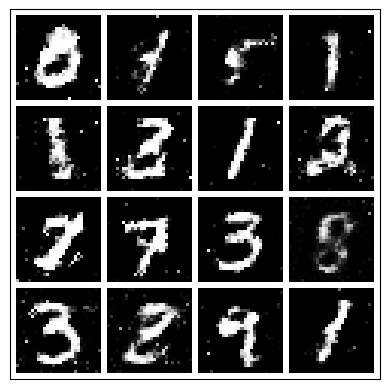

-------------------------------------
                Epoch 17: 
                Step: 1000 | 
                D_real Loss: 0.9940 | 
                D_fake Loss: 0.5315 | 
                D_total Loss: 1.5255 | 
                G_Loss: 1.531 |
                Real_score 0.447 | 
                Fake_score 0.327 
            


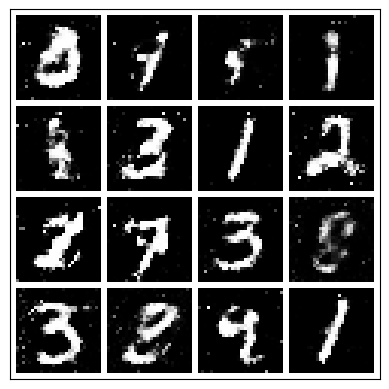

-------------------------------------
                Epoch 17: 
                Step: 1500 | 
                D_real Loss: 0.6117 | 
                D_fake Loss: 0.5266 | 
                D_total Loss: 1.1384 | 
                G_Loss: 1.655 |
                Real_score 0.589 | 
                Fake_score 0.340 
            


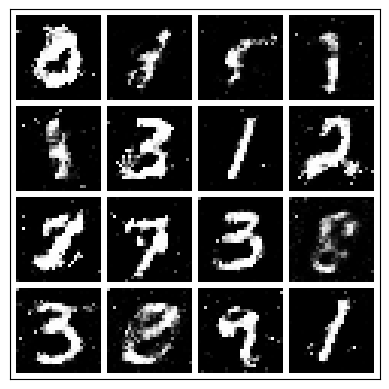

-------------------------------------
                Epoch 17: 
                Step: 2000 | 
                D_real Loss: 0.3418 | 
                D_fake Loss: 0.5774 | 
                D_total Loss: 0.9192 | 
                G_Loss: 1.179 |
                Real_score 0.770 | 
                Fake_score 0.377 
            


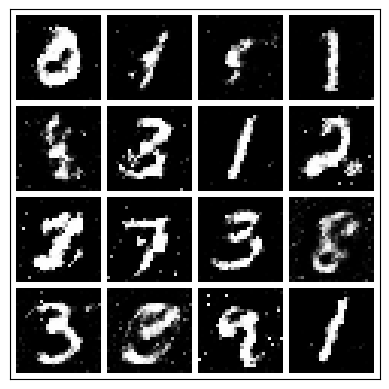

-------------------------------------
                Epoch 17: 
                Step: 2500 | 
                D_real Loss: 0.4984 | 
                D_fake Loss: 0.7552 | 
                D_total Loss: 1.2536 | 
                G_Loss: 1.177 |
                Real_score 0.654 | 
                Fake_score 0.431 
            


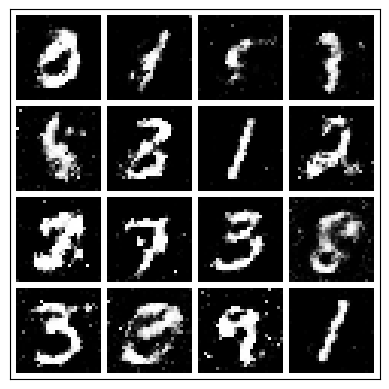

-------------------------------------
                Epoch 17: 
                Step: 3000 | 
                D_real Loss: 0.2256 | 
                D_fake Loss: 0.3777 | 
                D_total Loss: 0.6033 | 
                G_Loss: 1.738 |
                Real_score 0.828 | 
                Fake_score 0.292 
            


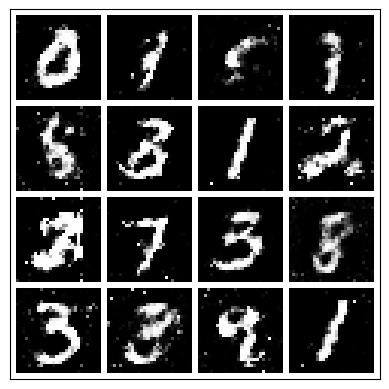

-------------------------------------
                Epoch 17: 
                Step: 3500 | 
                D_real Loss: 0.4367 | 
                D_fake Loss: 0.5749 | 
                D_total Loss: 1.0116 | 
                G_Loss: 1.072 |
                Real_score 0.688 | 
                Fake_score 0.367 
            


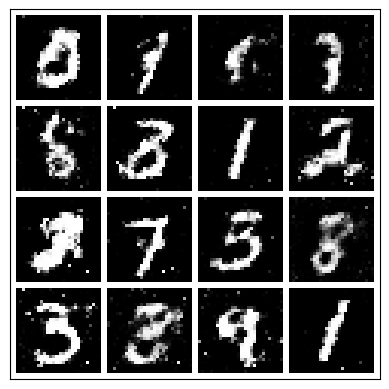

 34%|█████████████▉                           | 17/50 [27:15<1:12:35, 131.97s/it]

-------------------------------------
                Epoch 18: 
                Step: 0 | 
                D_real Loss: 0.4838 | 
                D_fake Loss: 0.5229 | 
                D_total Loss: 1.0066 | 
                G_Loss: 1.243 |
                Real_score 0.682 | 
                Fake_score 0.364 
            


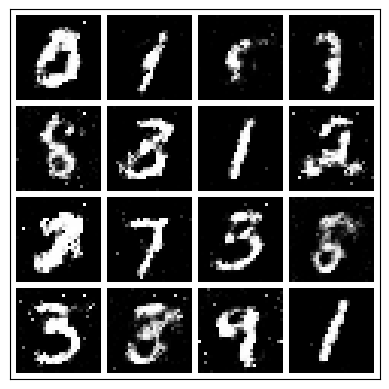

-------------------------------------
                Epoch 18: 
                Step: 500 | 
                D_real Loss: 0.4517 | 
                D_fake Loss: 0.3777 | 
                D_total Loss: 0.8294 | 
                G_Loss: 1.555 |
                Real_score 0.695 | 
                Fake_score 0.283 
            


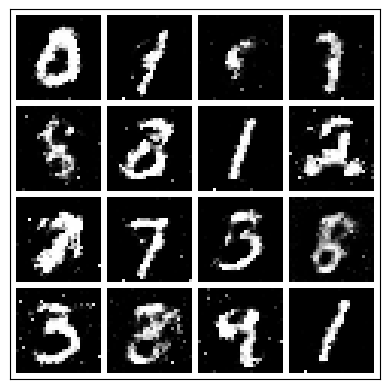

-------------------------------------
                Epoch 18: 
                Step: 1000 | 
                D_real Loss: 0.4659 | 
                D_fake Loss: 0.4760 | 
                D_total Loss: 0.9419 | 
                G_Loss: 1.348 |
                Real_score 0.694 | 
                Fake_score 0.318 
            


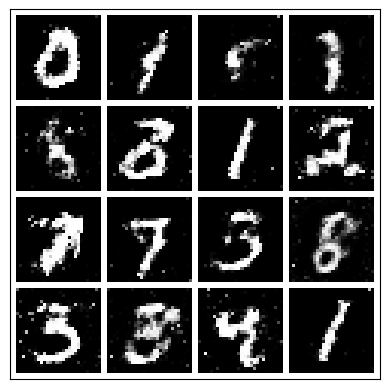

-------------------------------------
                Epoch 18: 
                Step: 1500 | 
                D_real Loss: 0.5266 | 
                D_fake Loss: 0.4473 | 
                D_total Loss: 0.9739 | 
                G_Loss: 1.372 |
                Real_score 0.700 | 
                Fake_score 0.331 
            


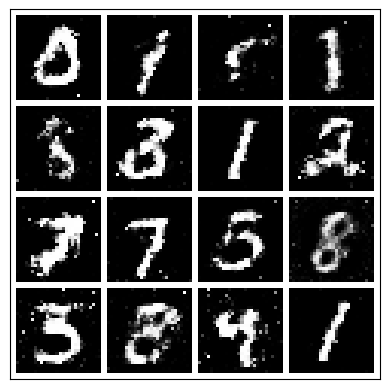

-------------------------------------
                Epoch 18: 
                Step: 2000 | 
                D_real Loss: 0.4488 | 
                D_fake Loss: 0.3854 | 
                D_total Loss: 0.8341 | 
                G_Loss: 1.294 |
                Real_score 0.681 | 
                Fake_score 0.303 
            


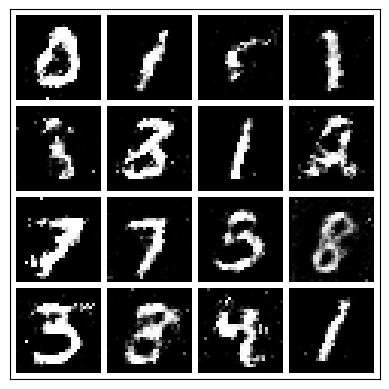

-------------------------------------
                Epoch 18: 
                Step: 2500 | 
                D_real Loss: 0.4820 | 
                D_fake Loss: 0.5072 | 
                D_total Loss: 0.9893 | 
                G_Loss: 1.191 |
                Real_score 0.642 | 
                Fake_score 0.369 
            


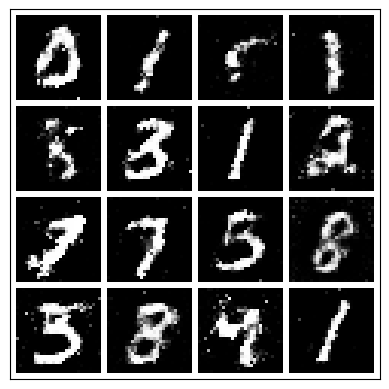

-------------------------------------
                Epoch 18: 
                Step: 3000 | 
                D_real Loss: 0.9156 | 
                D_fake Loss: 0.4256 | 
                D_total Loss: 1.3412 | 
                G_Loss: 1.483 |
                Real_score 0.467 | 
                Fake_score 0.321 
            


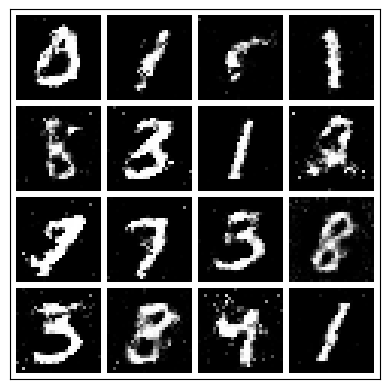

-------------------------------------
                Epoch 18: 
                Step: 3500 | 
                D_real Loss: 0.5116 | 
                D_fake Loss: 0.5693 | 
                D_total Loss: 1.0809 | 
                G_Loss: 1.306 |
                Real_score 0.669 | 
                Fake_score 0.395 
            


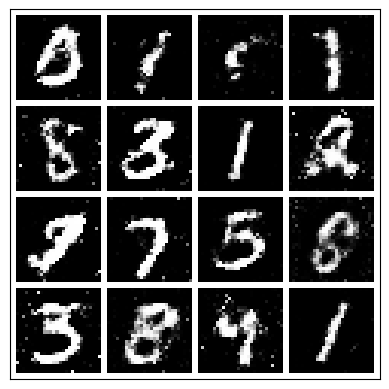

 36%|██████████████▊                          | 18/50 [28:35<1:01:59, 116.23s/it]

-------------------------------------
                Epoch 19: 
                Step: 0 | 
                D_real Loss: 0.4030 | 
                D_fake Loss: 0.6038 | 
                D_total Loss: 1.0068 | 
                G_Loss: 1.178 |
                Real_score 0.717 | 
                Fake_score 0.363 
            


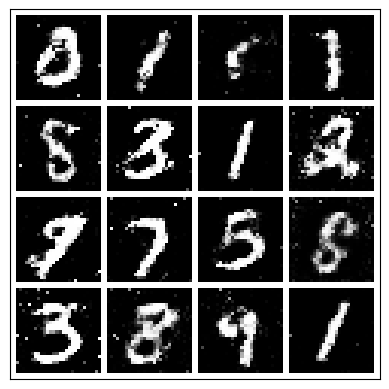

-------------------------------------
                Epoch 19: 
                Step: 500 | 
                D_real Loss: 0.2275 | 
                D_fake Loss: 0.4504 | 
                D_total Loss: 0.6778 | 
                G_Loss: 1.299 |
                Real_score 0.820 | 
                Fake_score 0.318 
            


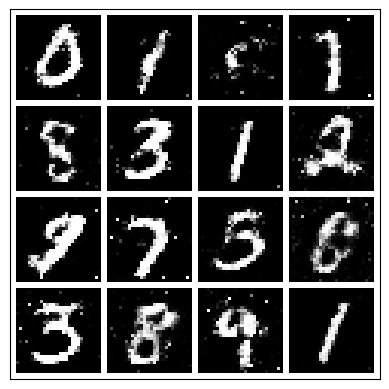

-------------------------------------
                Epoch 19: 
                Step: 1000 | 
                D_real Loss: 0.4187 | 
                D_fake Loss: 0.7579 | 
                D_total Loss: 1.1766 | 
                G_Loss: 1.057 |
                Real_score 0.714 | 
                Fake_score 0.398 
            


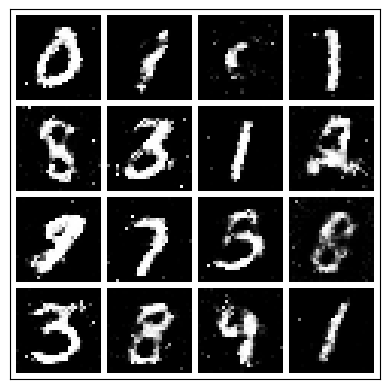

-------------------------------------
                Epoch 19: 
                Step: 1500 | 
                D_real Loss: 0.5971 | 
                D_fake Loss: 0.4001 | 
                D_total Loss: 0.9972 | 
                G_Loss: 1.673 |
                Real_score 0.621 | 
                Fake_score 0.292 
            


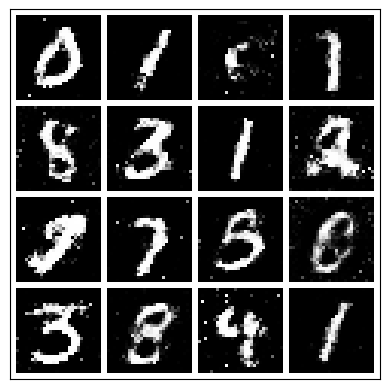

-------------------------------------
                Epoch 19: 
                Step: 2000 | 
                D_real Loss: 0.9219 | 
                D_fake Loss: 0.3106 | 
                D_total Loss: 1.2325 | 
                G_Loss: 1.187 |
                Real_score 0.495 | 
                Fake_score 0.251 
            


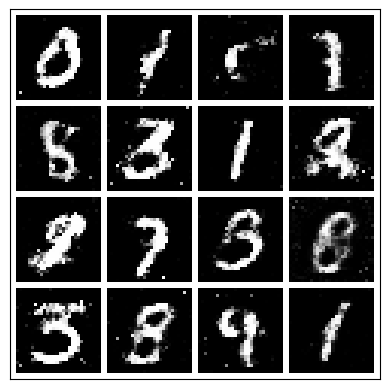

-------------------------------------
                Epoch 19: 
                Step: 2500 | 
                D_real Loss: 0.4873 | 
                D_fake Loss: 0.5103 | 
                D_total Loss: 0.9976 | 
                G_Loss: 0.895 |
                Real_score 0.663 | 
                Fake_score 0.380 
            


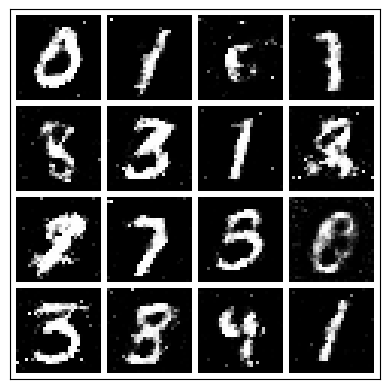

-------------------------------------
                Epoch 19: 
                Step: 3000 | 
                D_real Loss: 0.5636 | 
                D_fake Loss: 0.3763 | 
                D_total Loss: 0.9399 | 
                G_Loss: 1.314 |
                Real_score 0.622 | 
                Fake_score 0.304 
            


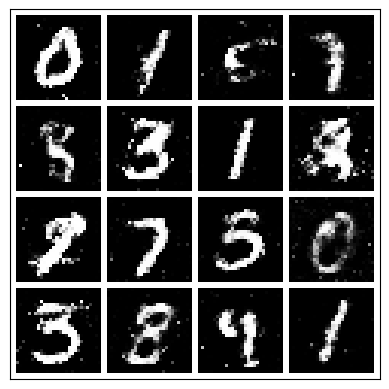

-------------------------------------
                Epoch 19: 
                Step: 3500 | 
                D_real Loss: 0.5345 | 
                D_fake Loss: 0.6224 | 
                D_total Loss: 1.1568 | 
                G_Loss: 1.209 |
                Real_score 0.659 | 
                Fake_score 0.400 
            


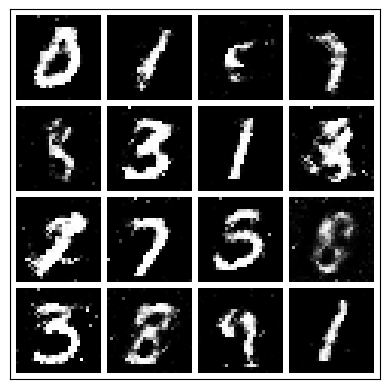

 38%|████████████████▎                          | 19/50 [29:46<53:02, 102.67s/it]

-------------------------------------
                Epoch 20: 
                Step: 0 | 
                D_real Loss: 0.5337 | 
                D_fake Loss: 0.5048 | 
                D_total Loss: 1.0385 | 
                G_Loss: 1.091 |
                Real_score 0.631 | 
                Fake_score 0.360 
            


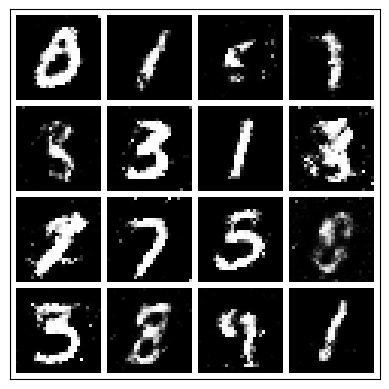

-------------------------------------
                Epoch 20: 
                Step: 500 | 
                D_real Loss: 0.7281 | 
                D_fake Loss: 0.3040 | 
                D_total Loss: 1.0322 | 
                G_Loss: 1.398 |
                Real_score 0.566 | 
                Fake_score 0.248 
            


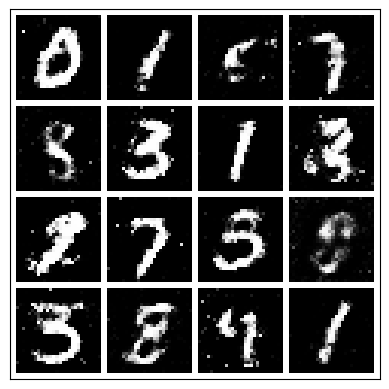

-------------------------------------
                Epoch 20: 
                Step: 1000 | 
                D_real Loss: 0.5569 | 
                D_fake Loss: 0.3642 | 
                D_total Loss: 0.9211 | 
                G_Loss: 1.664 |
                Real_score 0.611 | 
                Fake_score 0.270 
            


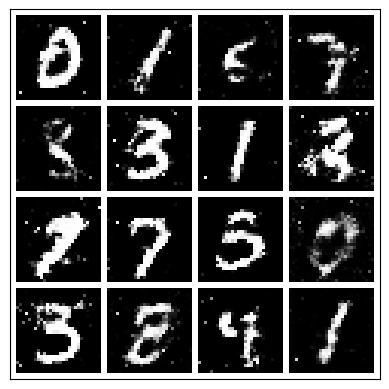

-------------------------------------
                Epoch 20: 
                Step: 1500 | 
                D_real Loss: 0.7385 | 
                D_fake Loss: 0.3832 | 
                D_total Loss: 1.1217 | 
                G_Loss: 1.147 |
                Real_score 0.523 | 
                Fake_score 0.310 
            


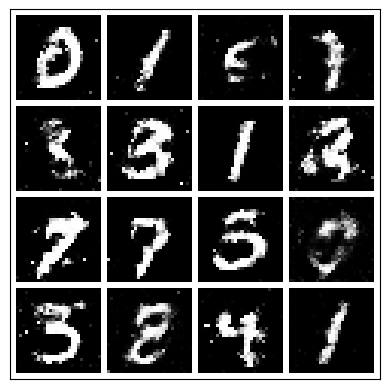

-------------------------------------
                Epoch 20: 
                Step: 2000 | 
                D_real Loss: 0.4412 | 
                D_fake Loss: 0.3131 | 
                D_total Loss: 0.7543 | 
                G_Loss: 1.468 |
                Real_score 0.701 | 
                Fake_score 0.255 
            


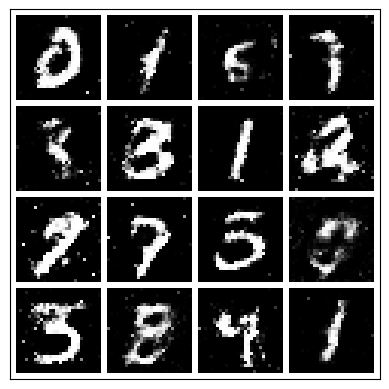

-------------------------------------
                Epoch 20: 
                Step: 2500 | 
                D_real Loss: 0.4064 | 
                D_fake Loss: 0.5508 | 
                D_total Loss: 0.9571 | 
                G_Loss: 1.256 |
                Real_score 0.711 | 
                Fake_score 0.387 
            


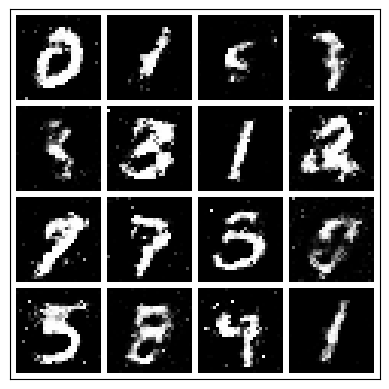

-------------------------------------
                Epoch 20: 
                Step: 3000 | 
                D_real Loss: 0.5071 | 
                D_fake Loss: 0.4580 | 
                D_total Loss: 0.9651 | 
                G_Loss: 1.105 |
                Real_score 0.651 | 
                Fake_score 0.346 
            


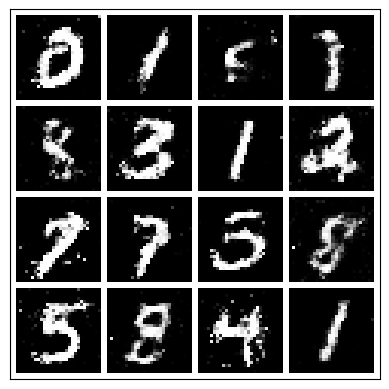

-------------------------------------
                Epoch 20: 
                Step: 3500 | 
                D_real Loss: 0.4316 | 
                D_fake Loss: 0.4968 | 
                D_total Loss: 0.9284 | 
                G_Loss: 0.990 |
                Real_score 0.700 | 
                Fake_score 0.376 
            


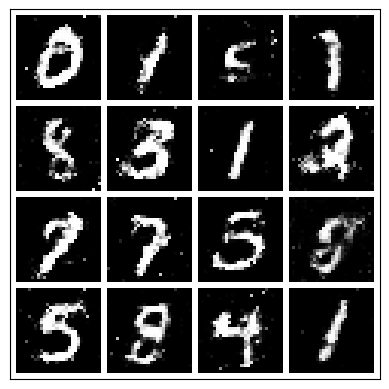

 40%|█████████████████▌                          | 20/50 [30:56<46:22, 92.74s/it]

-------------------------------------
                Epoch 21: 
                Step: 0 | 
                D_real Loss: 0.6579 | 
                D_fake Loss: 0.6842 | 
                D_total Loss: 1.3421 | 
                G_Loss: 1.268 |
                Real_score 0.565 | 
                Fake_score 0.426 
            


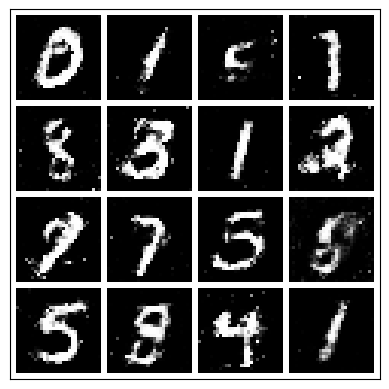

-------------------------------------
                Epoch 21: 
                Step: 500 | 
                D_real Loss: 0.5495 | 
                D_fake Loss: 0.5957 | 
                D_total Loss: 1.1452 | 
                G_Loss: 1.245 |
                Real_score 0.636 | 
                Fake_score 0.372 
            


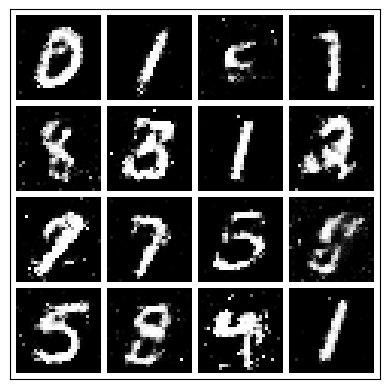

-------------------------------------
                Epoch 21: 
                Step: 1000 | 
                D_real Loss: 0.6326 | 
                D_fake Loss: 0.3730 | 
                D_total Loss: 1.0055 | 
                G_Loss: 1.440 |
                Real_score 0.583 | 
                Fake_score 0.296 
            


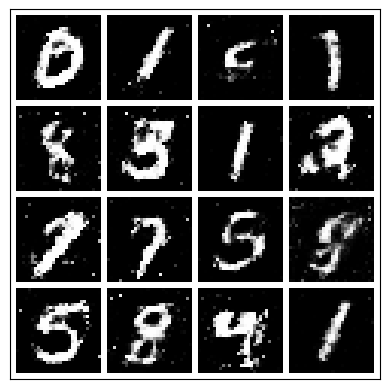

-------------------------------------
                Epoch 21: 
                Step: 1500 | 
                D_real Loss: 0.7881 | 
                D_fake Loss: 0.3550 | 
                D_total Loss: 1.1432 | 
                G_Loss: 1.652 |
                Real_score 0.492 | 
                Fake_score 0.275 
            


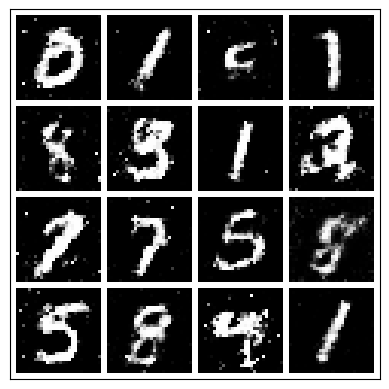

-------------------------------------
                Epoch 21: 
                Step: 2000 | 
                D_real Loss: 0.6405 | 
                D_fake Loss: 0.6180 | 
                D_total Loss: 1.2585 | 
                G_Loss: 1.070 |
                Real_score 0.577 | 
                Fake_score 0.433 
            


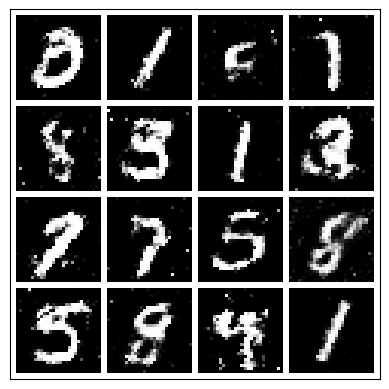

-------------------------------------
                Epoch 21: 
                Step: 2500 | 
                D_real Loss: 0.5288 | 
                D_fake Loss: 0.4736 | 
                D_total Loss: 1.0024 | 
                G_Loss: 1.050 |
                Real_score 0.652 | 
                Fake_score 0.359 
            


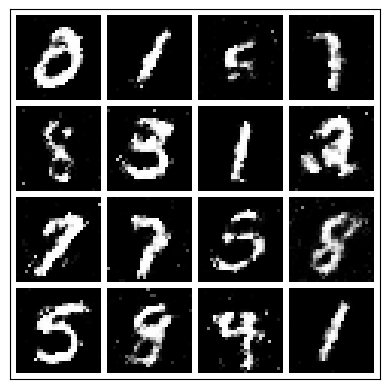

-------------------------------------
                Epoch 21: 
                Step: 3000 | 
                D_real Loss: 0.6880 | 
                D_fake Loss: 0.5709 | 
                D_total Loss: 1.2589 | 
                G_Loss: 1.055 |
                Real_score 0.573 | 
                Fake_score 0.401 
            


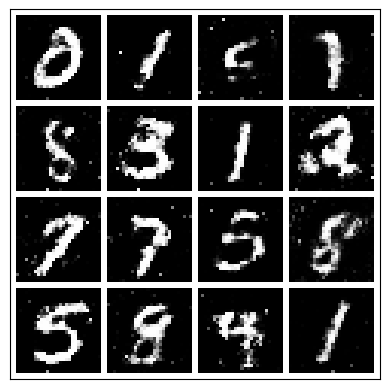

-------------------------------------
                Epoch 21: 
                Step: 3500 | 
                D_real Loss: 0.3719 | 
                D_fake Loss: 0.3775 | 
                D_total Loss: 0.7494 | 
                G_Loss: 1.340 |
                Real_score 0.715 | 
                Fake_score 0.299 
            


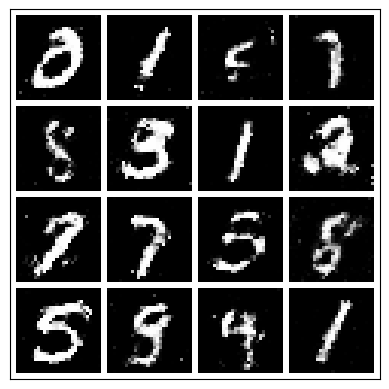

 42%|██████████████████▍                         | 21/50 [32:36<45:59, 95.17s/it]

-------------------------------------
                Epoch 22: 
                Step: 0 | 
                D_real Loss: 0.4984 | 
                D_fake Loss: 0.6379 | 
                D_total Loss: 1.1363 | 
                G_Loss: 1.103 |
                Real_score 0.659 | 
                Fake_score 0.439 
            


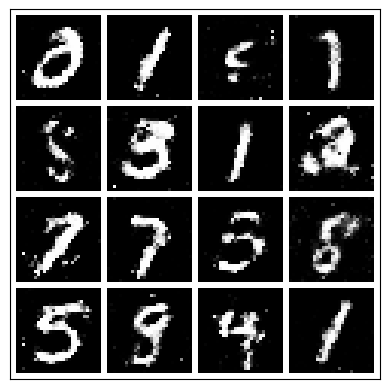

-------------------------------------
                Epoch 22: 
                Step: 500 | 
                D_real Loss: 0.5800 | 
                D_fake Loss: 0.6310 | 
                D_total Loss: 1.2110 | 
                G_Loss: 1.140 |
                Real_score 0.612 | 
                Fake_score 0.408 
            


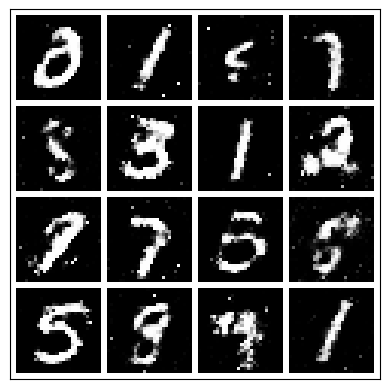

-------------------------------------
                Epoch 22: 
                Step: 1000 | 
                D_real Loss: 0.4308 | 
                D_fake Loss: 0.6763 | 
                D_total Loss: 1.1071 | 
                G_Loss: 1.007 |
                Real_score 0.715 | 
                Fake_score 0.437 
            


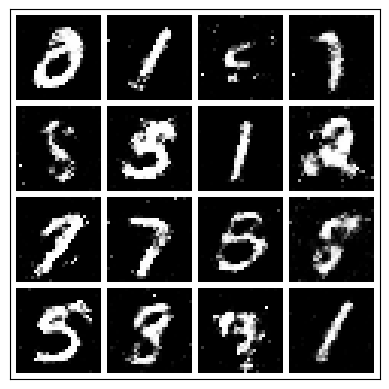

-------------------------------------
                Epoch 22: 
                Step: 1500 | 
                D_real Loss: 0.4702 | 
                D_fake Loss: 0.3420 | 
                D_total Loss: 0.8122 | 
                G_Loss: 1.470 |
                Real_score 0.689 | 
                Fake_score 0.269 
            


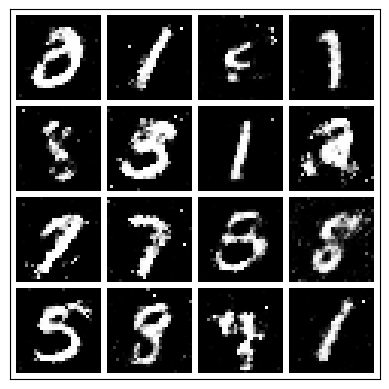

-------------------------------------
                Epoch 22: 
                Step: 2000 | 
                D_real Loss: 0.5797 | 
                D_fake Loss: 0.4561 | 
                D_total Loss: 1.0358 | 
                G_Loss: 1.001 |
                Real_score 0.622 | 
                Fake_score 0.350 
            


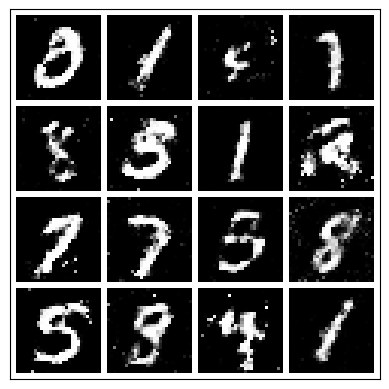

-------------------------------------
                Epoch 22: 
                Step: 2500 | 
                D_real Loss: 0.5292 | 
                D_fake Loss: 0.4185 | 
                D_total Loss: 0.9477 | 
                G_Loss: 1.151 |
                Real_score 0.633 | 
                Fake_score 0.312 
            


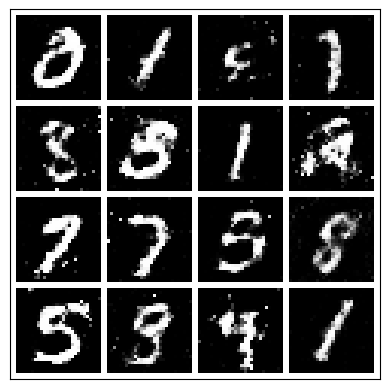

-------------------------------------
                Epoch 22: 
                Step: 3000 | 
                D_real Loss: 0.5626 | 
                D_fake Loss: 0.3757 | 
                D_total Loss: 0.9383 | 
                G_Loss: 1.339 |
                Real_score 0.621 | 
                Fake_score 0.304 
            


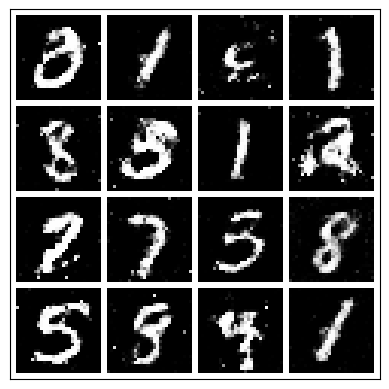

-------------------------------------
                Epoch 22: 
                Step: 3500 | 
                D_real Loss: 0.5031 | 
                D_fake Loss: 0.4724 | 
                D_total Loss: 0.9755 | 
                G_Loss: 1.212 |
                Real_score 0.648 | 
                Fake_score 0.349 
            


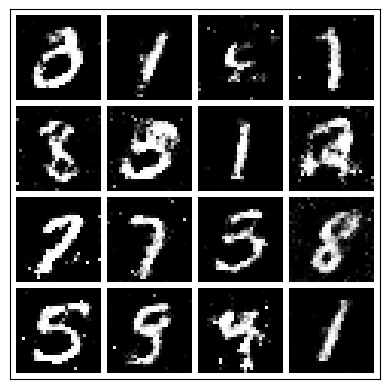

 44%|███████████████████▎                        | 22/50 [33:36<39:27, 84.54s/it]

-------------------------------------
                Epoch 23: 
                Step: 0 | 
                D_real Loss: 0.3541 | 
                D_fake Loss: 0.5669 | 
                D_total Loss: 0.9211 | 
                G_Loss: 1.291 |
                Real_score 0.731 | 
                Fake_score 0.392 
            


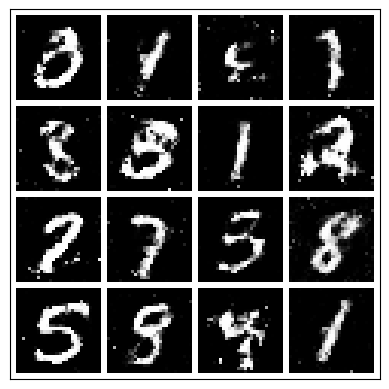

-------------------------------------
                Epoch 23: 
                Step: 500 | 
                D_real Loss: 0.3661 | 
                D_fake Loss: 0.7991 | 
                D_total Loss: 1.1652 | 
                G_Loss: 0.812 |
                Real_score 0.744 | 
                Fake_score 0.521 
            


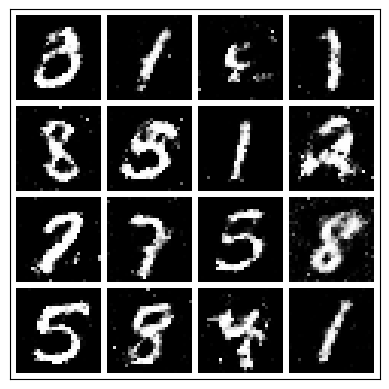

-------------------------------------
                Epoch 23: 
                Step: 1000 | 
                D_real Loss: 0.7340 | 
                D_fake Loss: 0.4556 | 
                D_total Loss: 1.1895 | 
                G_Loss: 1.297 |
                Real_score 0.544 | 
                Fake_score 0.348 
            


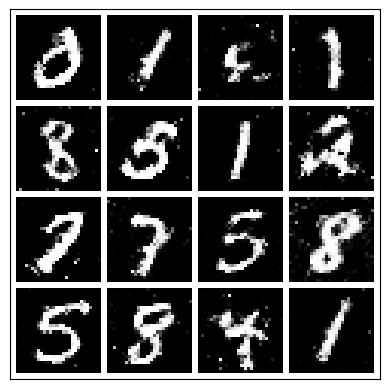

-------------------------------------
                Epoch 23: 
                Step: 1500 | 
                D_real Loss: 0.8519 | 
                D_fake Loss: 0.3346 | 
                D_total Loss: 1.1865 | 
                G_Loss: 1.230 |
                Real_score 0.503 | 
                Fake_score 0.261 
            


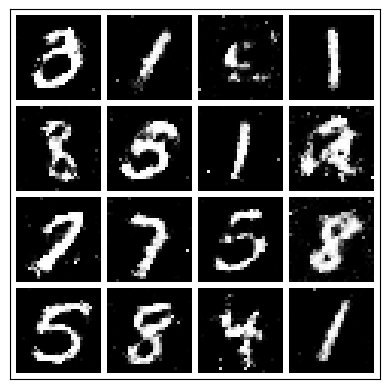

-------------------------------------
                Epoch 23: 
                Step: 2000 | 
                D_real Loss: 0.6525 | 
                D_fake Loss: 0.7262 | 
                D_total Loss: 1.3787 | 
                G_Loss: 1.366 |
                Real_score 0.586 | 
                Fake_score 0.446 
            


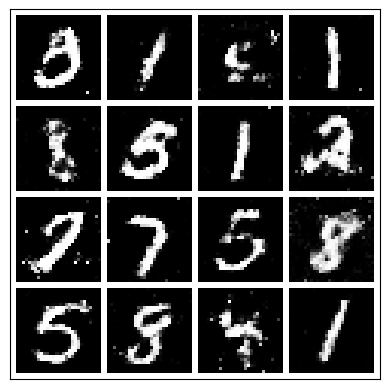

-------------------------------------
                Epoch 23: 
                Step: 2500 | 
                D_real Loss: 0.5702 | 
                D_fake Loss: 0.3554 | 
                D_total Loss: 0.9255 | 
                G_Loss: 1.257 |
                Real_score 0.616 | 
                Fake_score 0.288 
            


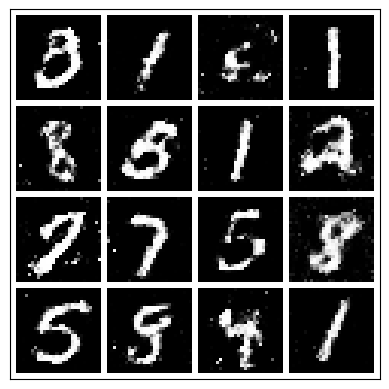

-------------------------------------
                Epoch 23: 
                Step: 3000 | 
                D_real Loss: 0.2639 | 
                D_fake Loss: 0.8014 | 
                D_total Loss: 1.0653 | 
                G_Loss: 0.950 |
                Real_score 0.790 | 
                Fake_score 0.491 
            


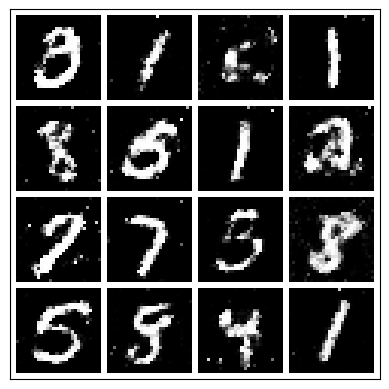

-------------------------------------
                Epoch 23: 
                Step: 3500 | 
                D_real Loss: 0.7293 | 
                D_fake Loss: 0.5837 | 
                D_total Loss: 1.3130 | 
                G_Loss: 1.217 |
                Real_score 0.547 | 
                Fake_score 0.382 
            


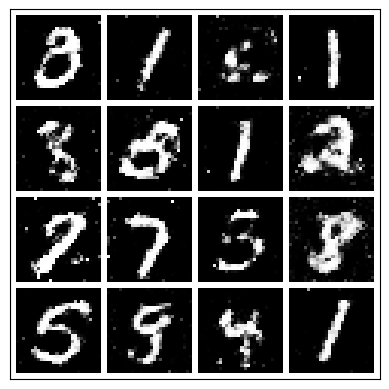

 46%|████████████████████▏                       | 23/50 [34:46<36:03, 80.14s/it]

-------------------------------------
                Epoch 24: 
                Step: 0 | 
                D_real Loss: 0.8745 | 
                D_fake Loss: 0.4348 | 
                D_total Loss: 1.3093 | 
                G_Loss: 1.431 |
                Real_score 0.485 | 
                Fake_score 0.301 
            


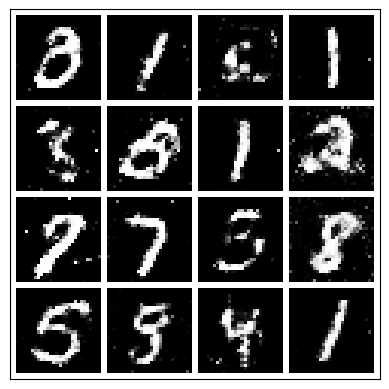

-------------------------------------
                Epoch 24: 
                Step: 500 | 
                D_real Loss: 0.7334 | 
                D_fake Loss: 0.6344 | 
                D_total Loss: 1.3678 | 
                G_Loss: 1.000 |
                Real_score 0.545 | 
                Fake_score 0.422 
            


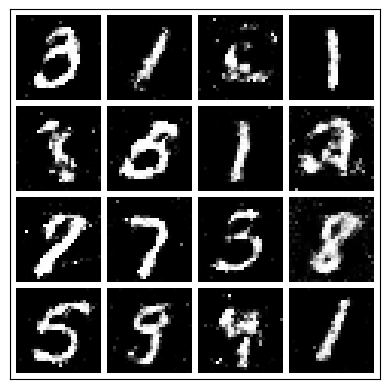

-------------------------------------
                Epoch 24: 
                Step: 1000 | 
                D_real Loss: 0.5271 | 
                D_fake Loss: 0.4516 | 
                D_total Loss: 0.9788 | 
                G_Loss: 1.260 |
                Real_score 0.645 | 
                Fake_score 0.334 
            


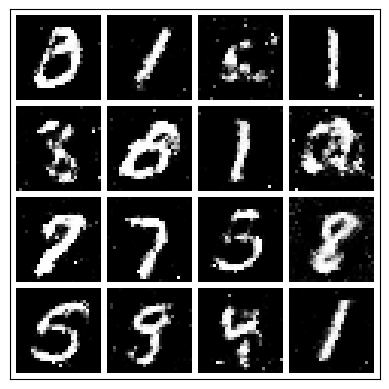

-------------------------------------
                Epoch 24: 
                Step: 1500 | 
                D_real Loss: 0.5982 | 
                D_fake Loss: 0.5368 | 
                D_total Loss: 1.1350 | 
                G_Loss: 0.916 |
                Real_score 0.629 | 
                Fake_score 0.392 
            


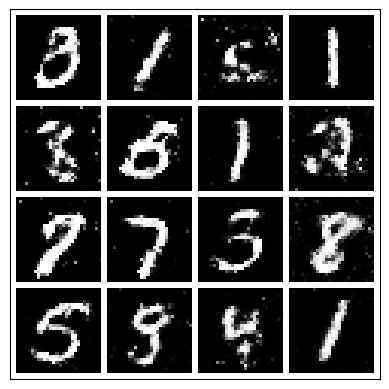

-------------------------------------
                Epoch 24: 
                Step: 2000 | 
                D_real Loss: 0.7978 | 
                D_fake Loss: 0.6926 | 
                D_total Loss: 1.4904 | 
                G_Loss: 0.998 |
                Real_score 0.490 | 
                Fake_score 0.418 
            


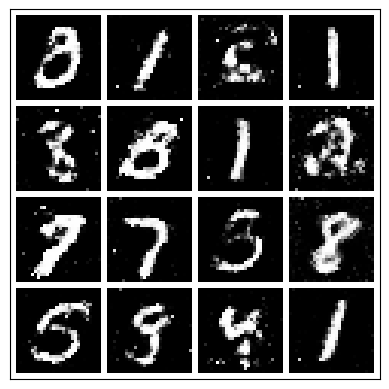

-------------------------------------
                Epoch 24: 
                Step: 2500 | 
                D_real Loss: 0.6913 | 
                D_fake Loss: 0.5577 | 
                D_total Loss: 1.2490 | 
                G_Loss: 1.028 |
                Real_score 0.540 | 
                Fake_score 0.410 
            


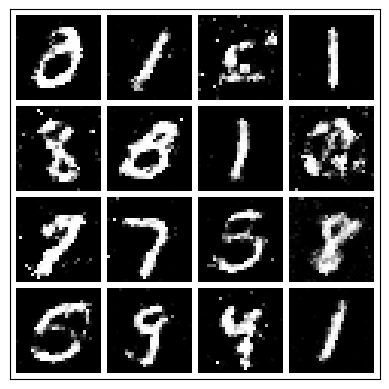

-------------------------------------
                Epoch 24: 
                Step: 3000 | 
                D_real Loss: 0.5507 | 
                D_fake Loss: 0.5156 | 
                D_total Loss: 1.0663 | 
                G_Loss: 0.845 |
                Real_score 0.621 | 
                Fake_score 0.386 
            


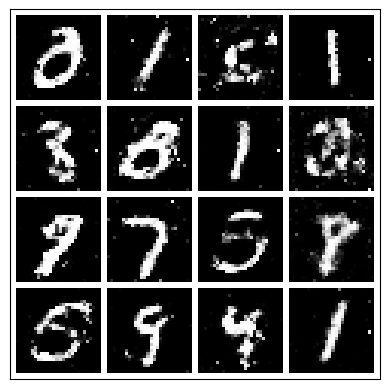

-------------------------------------
                Epoch 24: 
                Step: 3500 | 
                D_real Loss: 0.5141 | 
                D_fake Loss: 0.4993 | 
                D_total Loss: 1.0133 | 
                G_Loss: 1.010 |
                Real_score 0.661 | 
                Fake_score 0.369 
            


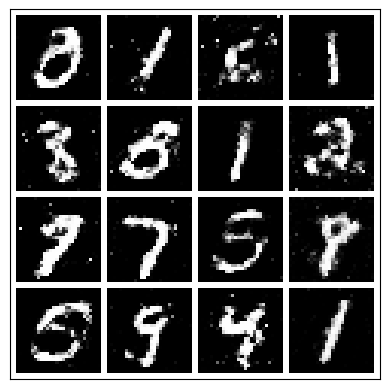

 48%|█████████████████████                       | 24/50 [36:10<35:14, 81.31s/it]

-------------------------------------
                Epoch 25: 
                Step: 0 | 
                D_real Loss: 0.6743 | 
                D_fake Loss: 0.4150 | 
                D_total Loss: 1.0893 | 
                G_Loss: 1.318 |
                Real_score 0.538 | 
                Fake_score 0.298 
            


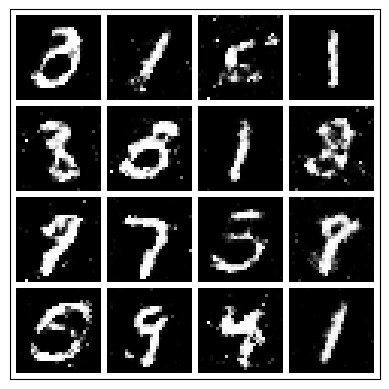

-------------------------------------
                Epoch 25: 
                Step: 500 | 
                D_real Loss: 0.8975 | 
                D_fake Loss: 0.6750 | 
                D_total Loss: 1.5725 | 
                G_Loss: 1.249 |
                Real_score 0.564 | 
                Fake_score 0.424 
            


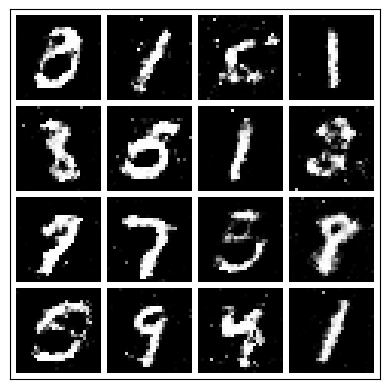

-------------------------------------
                Epoch 25: 
                Step: 1000 | 
                D_real Loss: 0.6101 | 
                D_fake Loss: 0.3878 | 
                D_total Loss: 0.9979 | 
                G_Loss: 1.231 |
                Real_score 0.606 | 
                Fake_score 0.295 
            


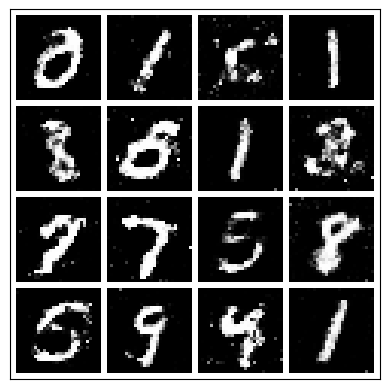

-------------------------------------
                Epoch 25: 
                Step: 1500 | 
                D_real Loss: 0.4880 | 
                D_fake Loss: 0.4435 | 
                D_total Loss: 0.9314 | 
                G_Loss: 1.204 |
                Real_score 0.637 | 
                Fake_score 0.309 
            


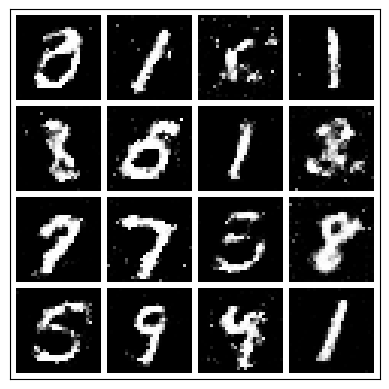

-------------------------------------
                Epoch 25: 
                Step: 2000 | 
                D_real Loss: 0.6407 | 
                D_fake Loss: 0.5975 | 
                D_total Loss: 1.2382 | 
                G_Loss: 1.037 |
                Real_score 0.568 | 
                Fake_score 0.384 
            


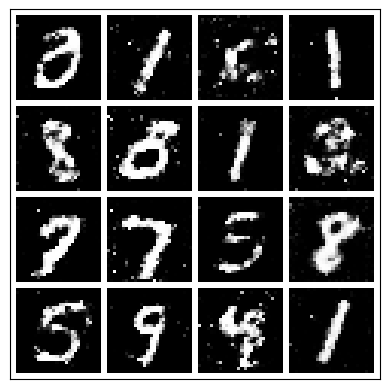

-------------------------------------
                Epoch 25: 
                Step: 2500 | 
                D_real Loss: 0.5664 | 
                D_fake Loss: 0.5545 | 
                D_total Loss: 1.1209 | 
                G_Loss: 1.173 |
                Real_score 0.630 | 
                Fake_score 0.384 
            


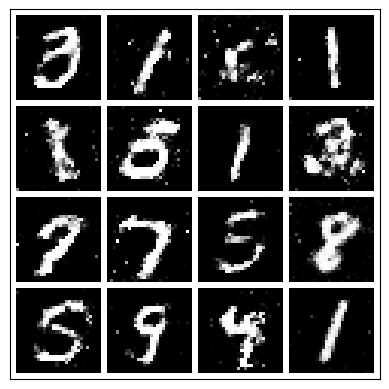

-------------------------------------
                Epoch 25: 
                Step: 3000 | 
                D_real Loss: 0.4937 | 
                D_fake Loss: 0.3928 | 
                D_total Loss: 0.8865 | 
                G_Loss: 1.101 |
                Real_score 0.650 | 
                Fake_score 0.308 
            


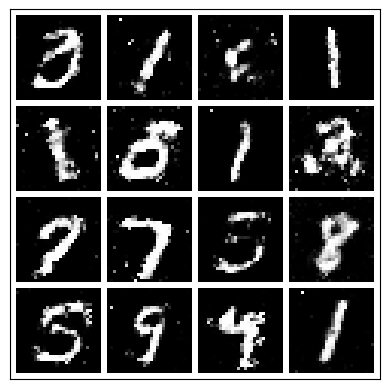

-------------------------------------
                Epoch 25: 
                Step: 3500 | 
                D_real Loss: 0.7399 | 
                D_fake Loss: 0.4087 | 
                D_total Loss: 1.1486 | 
                G_Loss: 1.244 |
                Real_score 0.539 | 
                Fake_score 0.320 
            


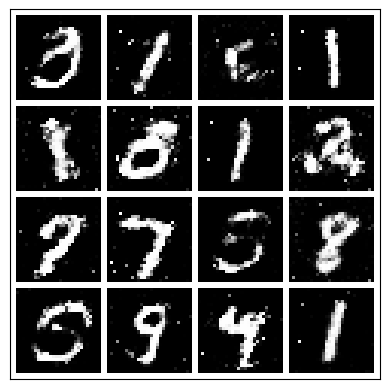

 50%|██████████████████████                      | 25/50 [37:55<36:48, 88.33s/it]

-------------------------------------
                Epoch 26: 
                Step: 0 | 
                D_real Loss: 0.4442 | 
                D_fake Loss: 0.5637 | 
                D_total Loss: 1.0079 | 
                G_Loss: 1.113 |
                Real_score 0.675 | 
                Fake_score 0.399 
            


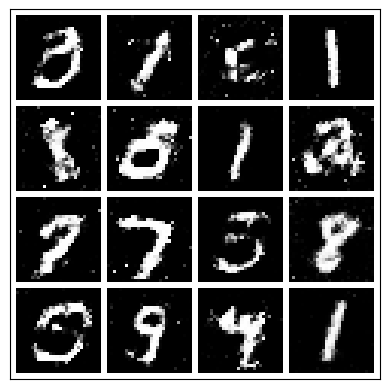

-------------------------------------
                Epoch 26: 
                Step: 500 | 
                D_real Loss: 0.4456 | 
                D_fake Loss: 0.4045 | 
                D_total Loss: 0.8501 | 
                G_Loss: 1.248 |
                Real_score 0.682 | 
                Fake_score 0.320 
            


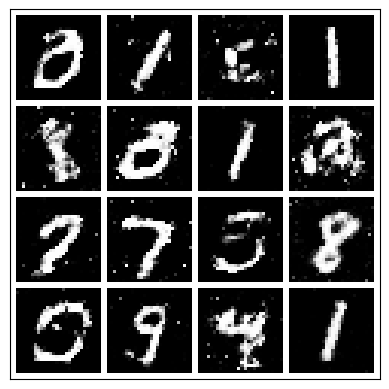

-------------------------------------
                Epoch 26: 
                Step: 1000 | 
                D_real Loss: 0.5661 | 
                D_fake Loss: 0.4056 | 
                D_total Loss: 0.9717 | 
                G_Loss: 1.205 |
                Real_score 0.595 | 
                Fake_score 0.316 
            


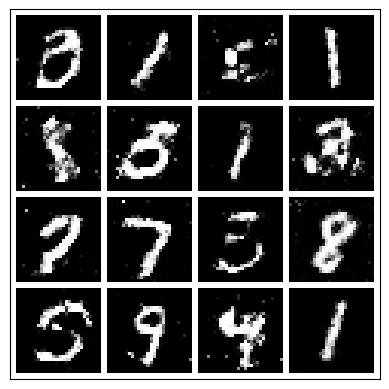

-------------------------------------
                Epoch 26: 
                Step: 1500 | 
                D_real Loss: 0.7712 | 
                D_fake Loss: 0.4786 | 
                D_total Loss: 1.2498 | 
                G_Loss: 1.209 |
                Real_score 0.507 | 
                Fake_score 0.360 
            


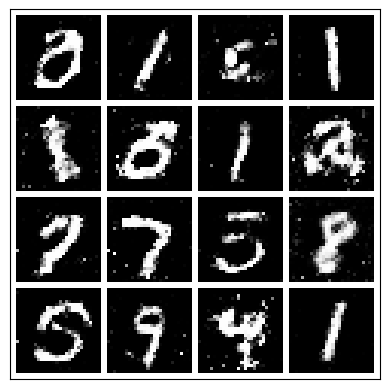

-------------------------------------
                Epoch 26: 
                Step: 2000 | 
                D_real Loss: 0.7635 | 
                D_fake Loss: 0.7247 | 
                D_total Loss: 1.4882 | 
                G_Loss: 1.030 |
                Real_score 0.530 | 
                Fake_score 0.457 
            


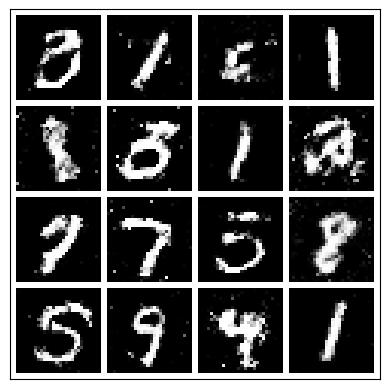

-------------------------------------
                Epoch 26: 
                Step: 2500 | 
                D_real Loss: 0.5308 | 
                D_fake Loss: 0.4514 | 
                D_total Loss: 0.9822 | 
                G_Loss: 1.330 |
                Real_score 0.639 | 
                Fake_score 0.337 
            


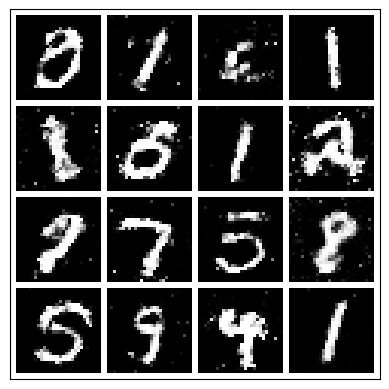

-------------------------------------
                Epoch 26: 
                Step: 3000 | 
                D_real Loss: 0.6953 | 
                D_fake Loss: 0.4828 | 
                D_total Loss: 1.1781 | 
                G_Loss: 1.531 |
                Real_score 0.569 | 
                Fake_score 0.346 
            


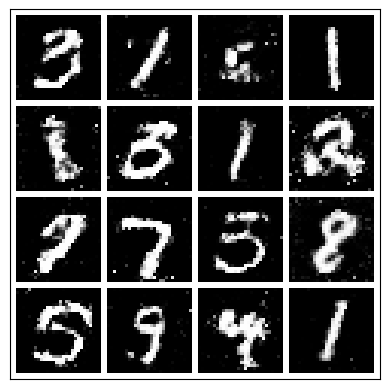

-------------------------------------
                Epoch 26: 
                Step: 3500 | 
                D_real Loss: 0.4342 | 
                D_fake Loss: 0.4602 | 
                D_total Loss: 0.8943 | 
                G_Loss: 1.294 |
                Real_score 0.686 | 
                Fake_score 0.345 
            


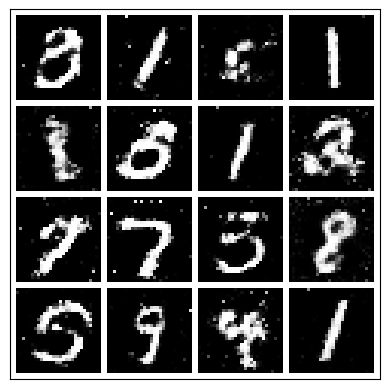

 52%|██████████████████████▉                     | 26/50 [39:12<33:56, 84.87s/it]

-------------------------------------
                Epoch 27: 
                Step: 0 | 
                D_real Loss: 0.5741 | 
                D_fake Loss: 0.8206 | 
                D_total Loss: 1.3947 | 
                G_Loss: 1.000 |
                Real_score 0.600 | 
                Fake_score 0.463 
            


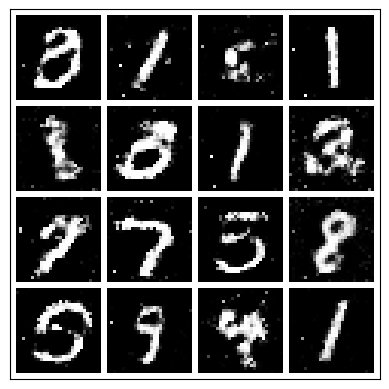

-------------------------------------
                Epoch 27: 
                Step: 500 | 
                D_real Loss: 0.6707 | 
                D_fake Loss: 0.6308 | 
                D_total Loss: 1.3015 | 
                G_Loss: 0.956 |
                Real_score 0.567 | 
                Fake_score 0.404 
            


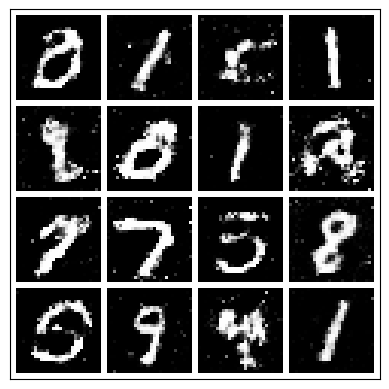

-------------------------------------
                Epoch 27: 
                Step: 1000 | 
                D_real Loss: 0.7883 | 
                D_fake Loss: 0.6680 | 
                D_total Loss: 1.4564 | 
                G_Loss: 0.987 |
                Real_score 0.487 | 
                Fake_score 0.421 
            


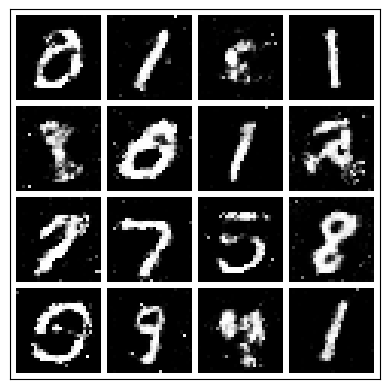

-------------------------------------
                Epoch 27: 
                Step: 1500 | 
                D_real Loss: 0.5218 | 
                D_fake Loss: 0.7014 | 
                D_total Loss: 1.2233 | 
                G_Loss: 1.040 |
                Real_score 0.629 | 
                Fake_score 0.445 
            


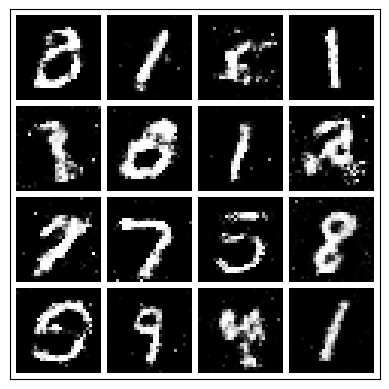

-------------------------------------
                Epoch 27: 
                Step: 2000 | 
                D_real Loss: 0.5848 | 
                D_fake Loss: 0.4173 | 
                D_total Loss: 1.0021 | 
                G_Loss: 1.150 |
                Real_score 0.623 | 
                Fake_score 0.328 
            


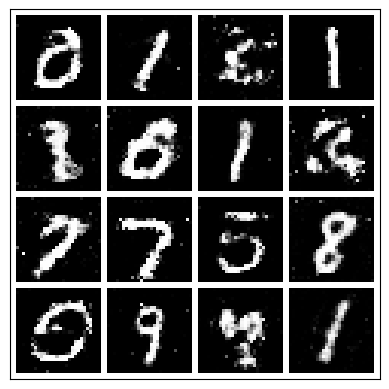

-------------------------------------
                Epoch 27: 
                Step: 2500 | 
                D_real Loss: 0.4870 | 
                D_fake Loss: 0.8934 | 
                D_total Loss: 1.3803 | 
                G_Loss: 0.742 |
                Real_score 0.665 | 
                Fake_score 0.561 
            


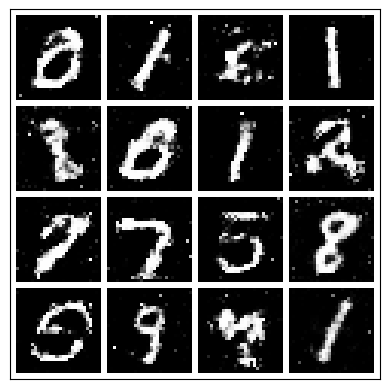

-------------------------------------
                Epoch 27: 
                Step: 3000 | 
                D_real Loss: 0.4135 | 
                D_fake Loss: 0.2932 | 
                D_total Loss: 0.7068 | 
                G_Loss: 1.509 |
                Real_score 0.700 | 
                Fake_score 0.246 
            


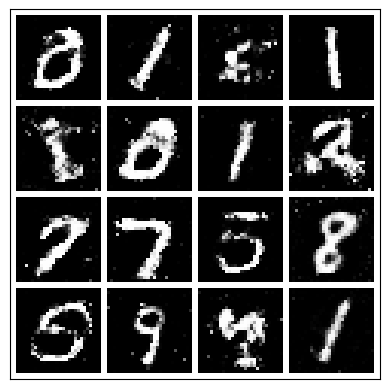

-------------------------------------
                Epoch 27: 
                Step: 3500 | 
                D_real Loss: 0.5508 | 
                D_fake Loss: 0.5982 | 
                D_total Loss: 1.1490 | 
                G_Loss: 0.977 |
                Real_score 0.613 | 
                Fake_score 0.418 
            


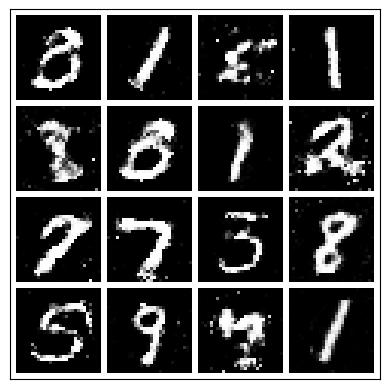

 54%|███████████████████████▊                    | 27/50 [40:33<32:09, 83.88s/it]

-------------------------------------
                Epoch 28: 
                Step: 0 | 
                D_real Loss: 0.5610 | 
                D_fake Loss: 0.3700 | 
                D_total Loss: 0.9310 | 
                G_Loss: 1.534 |
                Real_score 0.630 | 
                Fake_score 0.302 
            


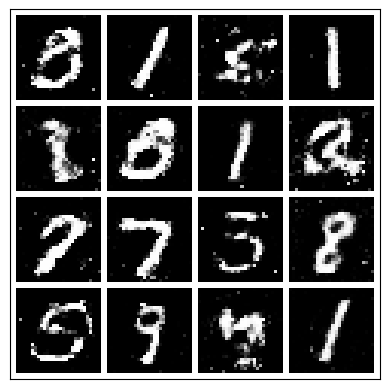

-------------------------------------
                Epoch 28: 
                Step: 500 | 
                D_real Loss: 0.4323 | 
                D_fake Loss: 0.6000 | 
                D_total Loss: 1.0324 | 
                G_Loss: 0.956 |
                Real_score 0.707 | 
                Fake_score 0.410 
            


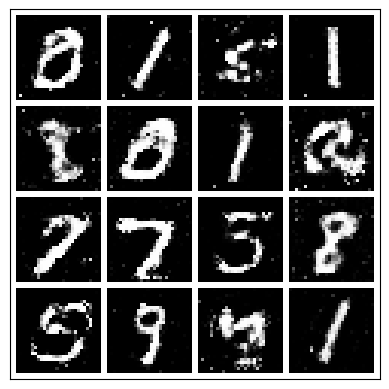

-------------------------------------
                Epoch 28: 
                Step: 1000 | 
                D_real Loss: 0.4090 | 
                D_fake Loss: 0.6904 | 
                D_total Loss: 1.0994 | 
                G_Loss: 1.087 |
                Real_score 0.715 | 
                Fake_score 0.452 
            


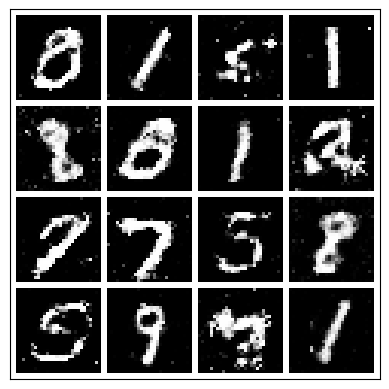

-------------------------------------
                Epoch 28: 
                Step: 1500 | 
                D_real Loss: 0.6024 | 
                D_fake Loss: 0.7739 | 
                D_total Loss: 1.3762 | 
                G_Loss: 0.905 |
                Real_score 0.632 | 
                Fake_score 0.477 
            


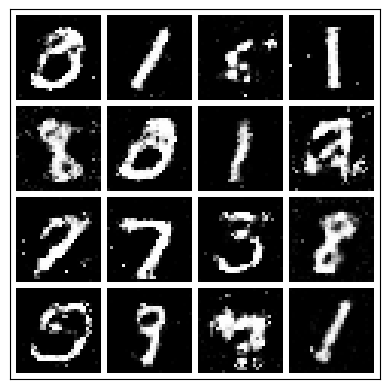

-------------------------------------
                Epoch 28: 
                Step: 2000 | 
                D_real Loss: 0.5576 | 
                D_fake Loss: 0.4933 | 
                D_total Loss: 1.0508 | 
                G_Loss: 1.176 |
                Real_score 0.617 | 
                Fake_score 0.361 
            


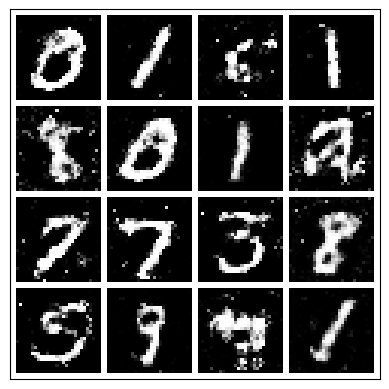

-------------------------------------
                Epoch 28: 
                Step: 2500 | 
                D_real Loss: 0.5186 | 
                D_fake Loss: 0.5470 | 
                D_total Loss: 1.0657 | 
                G_Loss: 1.205 |
                Real_score 0.657 | 
                Fake_score 0.392 
            


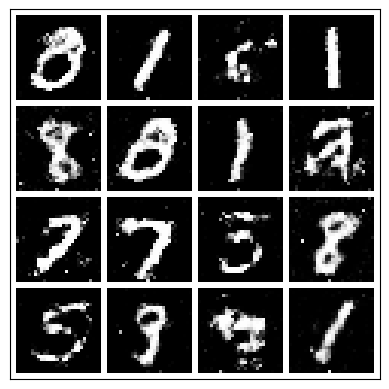

-------------------------------------
                Epoch 28: 
                Step: 3000 | 
                D_real Loss: 0.4222 | 
                D_fake Loss: 0.7012 | 
                D_total Loss: 1.1234 | 
                G_Loss: 1.324 |
                Real_score 0.694 | 
                Fake_score 0.451 
            


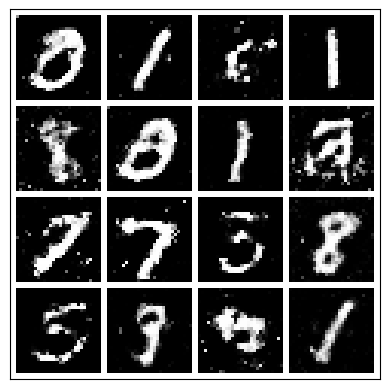

-------------------------------------
                Epoch 28: 
                Step: 3500 | 
                D_real Loss: 0.4075 | 
                D_fake Loss: 0.6868 | 
                D_total Loss: 1.0943 | 
                G_Loss: 0.971 |
                Real_score 0.684 | 
                Fake_score 0.475 
            


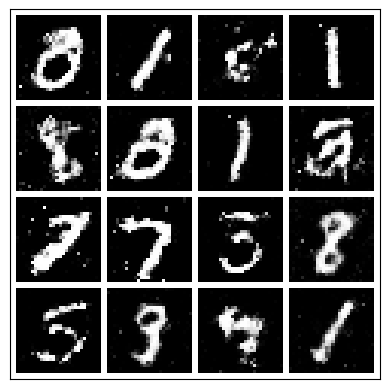

 56%|████████████████████████▋                   | 28/50 [41:42<29:09, 79.51s/it]

-------------------------------------
                Epoch 29: 
                Step: 0 | 
                D_real Loss: 0.6555 | 
                D_fake Loss: 0.4741 | 
                D_total Loss: 1.1297 | 
                G_Loss: 1.066 |
                Real_score 0.555 | 
                Fake_score 0.354 
            


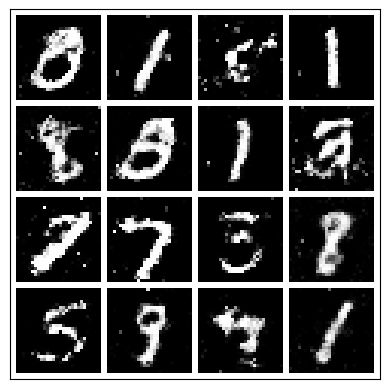

-------------------------------------
                Epoch 29: 
                Step: 500 | 
                D_real Loss: 0.4866 | 
                D_fake Loss: 0.4391 | 
                D_total Loss: 0.9257 | 
                G_Loss: 1.087 |
                Real_score 0.656 | 
                Fake_score 0.341 
            


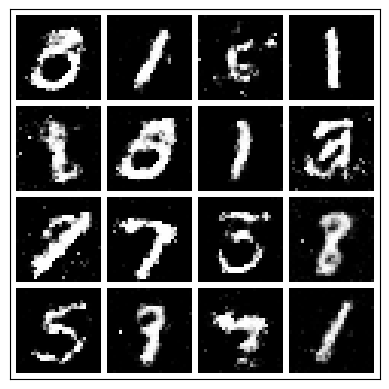

-------------------------------------
                Epoch 29: 
                Step: 1000 | 
                D_real Loss: 0.4683 | 
                D_fake Loss: 0.6767 | 
                D_total Loss: 1.1451 | 
                G_Loss: 0.693 |
                Real_score 0.658 | 
                Fake_score 0.468 
            


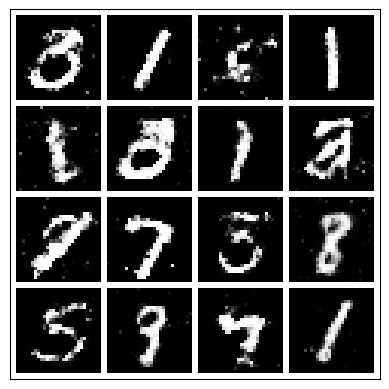

-------------------------------------
                Epoch 29: 
                Step: 1500 | 
                D_real Loss: 0.6984 | 
                D_fake Loss: 0.5625 | 
                D_total Loss: 1.2609 | 
                G_Loss: 0.948 |
                Real_score 0.566 | 
                Fake_score 0.406 
            


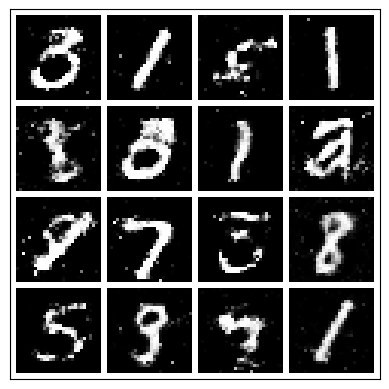

-------------------------------------
                Epoch 29: 
                Step: 2000 | 
                D_real Loss: 0.4730 | 
                D_fake Loss: 0.7535 | 
                D_total Loss: 1.2265 | 
                G_Loss: 1.034 |
                Real_score 0.664 | 
                Fake_score 0.434 
            


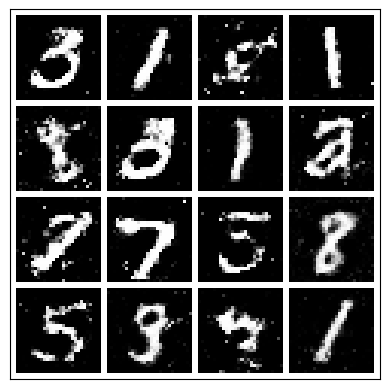

-------------------------------------
                Epoch 29: 
                Step: 2500 | 
                D_real Loss: 0.4196 | 
                D_fake Loss: 0.4143 | 
                D_total Loss: 0.8339 | 
                G_Loss: 1.100 |
                Real_score 0.679 | 
                Fake_score 0.330 
            


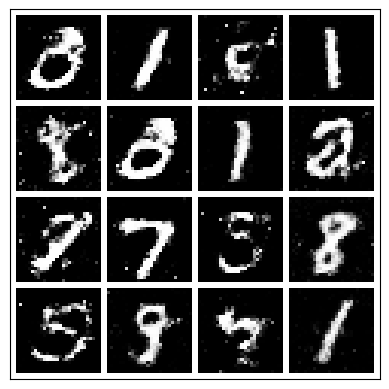

-------------------------------------
                Epoch 29: 
                Step: 3000 | 
                D_real Loss: 0.5267 | 
                D_fake Loss: 0.4574 | 
                D_total Loss: 0.9841 | 
                G_Loss: 1.056 |
                Real_score 0.625 | 
                Fake_score 0.357 
            


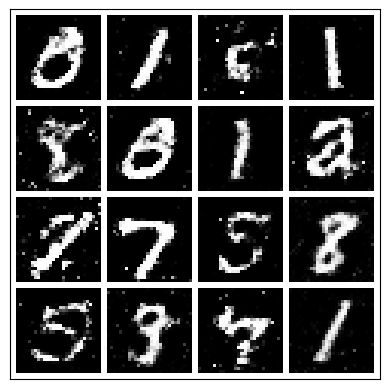

-------------------------------------
                Epoch 29: 
                Step: 3500 | 
                D_real Loss: 0.3983 | 
                D_fake Loss: 0.3083 | 
                D_total Loss: 0.7066 | 
                G_Loss: 1.355 |
                Real_score 0.729 | 
                Fake_score 0.257 
            


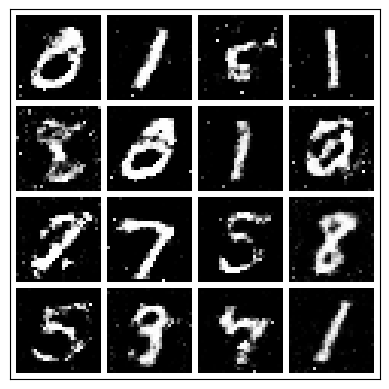

 58%|█████████████████████████▌                  | 29/50 [42:55<27:07, 77.51s/it]

-------------------------------------
                Epoch 30: 
                Step: 0 | 
                D_real Loss: 0.5551 | 
                D_fake Loss: 0.6225 | 
                D_total Loss: 1.1775 | 
                G_Loss: 0.961 |
                Real_score 0.644 | 
                Fake_score 0.415 
            


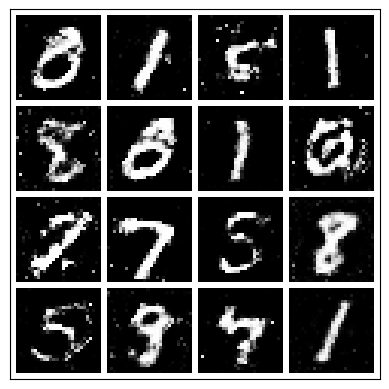

-------------------------------------
                Epoch 30: 
                Step: 500 | 
                D_real Loss: 0.5613 | 
                D_fake Loss: 0.5518 | 
                D_total Loss: 1.1131 | 
                G_Loss: 1.067 |
                Real_score 0.619 | 
                Fake_score 0.360 
            


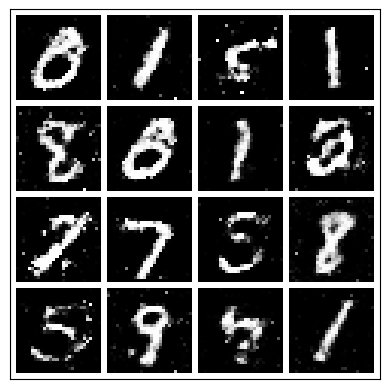

-------------------------------------
                Epoch 30: 
                Step: 1000 | 
                D_real Loss: 0.5778 | 
                D_fake Loss: 0.5564 | 
                D_total Loss: 1.1342 | 
                G_Loss: 1.088 |
                Real_score 0.635 | 
                Fake_score 0.381 
            


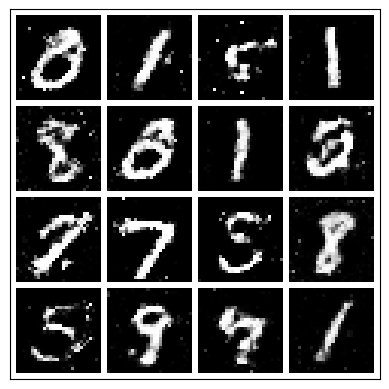

-------------------------------------
                Epoch 30: 
                Step: 1500 | 
                D_real Loss: 0.4659 | 
                D_fake Loss: 0.5105 | 
                D_total Loss: 0.9764 | 
                G_Loss: 1.312 |
                Real_score 0.662 | 
                Fake_score 0.365 
            


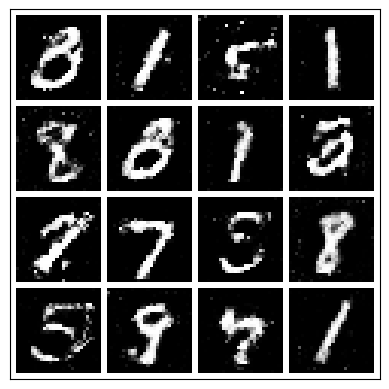

-------------------------------------
                Epoch 30: 
                Step: 2000 | 
                D_real Loss: 0.8928 | 
                D_fake Loss: 0.3427 | 
                D_total Loss: 1.2355 | 
                G_Loss: 1.405 |
                Real_score 0.488 | 
                Fake_score 0.279 
            


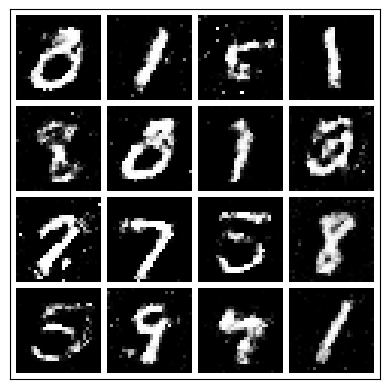

-------------------------------------
                Epoch 30: 
                Step: 2500 | 
                D_real Loss: 0.4657 | 
                D_fake Loss: 0.4736 | 
                D_total Loss: 0.9393 | 
                G_Loss: 1.223 |
                Real_score 0.680 | 
                Fake_score 0.360 
            


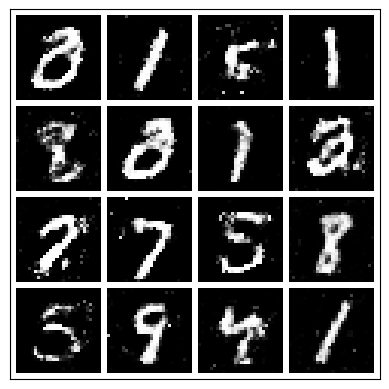

-------------------------------------
                Epoch 30: 
                Step: 3000 | 
                D_real Loss: 0.2582 | 
                D_fake Loss: 0.4890 | 
                D_total Loss: 0.7472 | 
                G_Loss: 1.186 |
                Real_score 0.791 | 
                Fake_score 0.348 
            


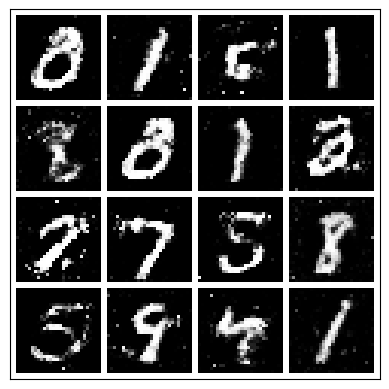

-------------------------------------
                Epoch 30: 
                Step: 3500 | 
                D_real Loss: 0.5763 | 
                D_fake Loss: 0.4334 | 
                D_total Loss: 1.0098 | 
                G_Loss: 1.130 |
                Real_score 0.612 | 
                Fake_score 0.347 
            


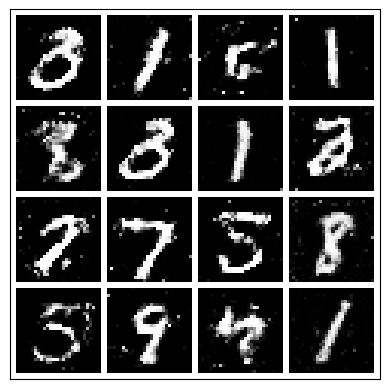

 60%|██████████████████████████▍                 | 30/50 [44:09<25:25, 76.27s/it]

-------------------------------------
                Epoch 31: 
                Step: 0 | 
                D_real Loss: 0.5612 | 
                D_fake Loss: 0.6226 | 
                D_total Loss: 1.1838 | 
                G_Loss: 1.254 |
                Real_score 0.611 | 
                Fake_score 0.367 
            


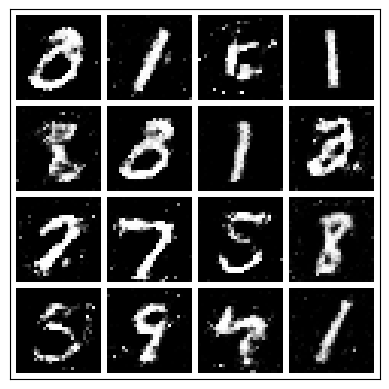

-------------------------------------
                Epoch 31: 
                Step: 500 | 
                D_real Loss: 0.6380 | 
                D_fake Loss: 0.6216 | 
                D_total Loss: 1.2596 | 
                G_Loss: 1.078 |
                Real_score 0.569 | 
                Fake_score 0.438 
            


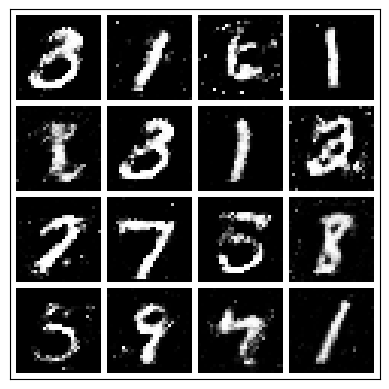

-------------------------------------
                Epoch 31: 
                Step: 1000 | 
                D_real Loss: 0.6235 | 
                D_fake Loss: 0.3482 | 
                D_total Loss: 0.9717 | 
                G_Loss: 1.608 |
                Real_score 0.576 | 
                Fake_score 0.270 
            


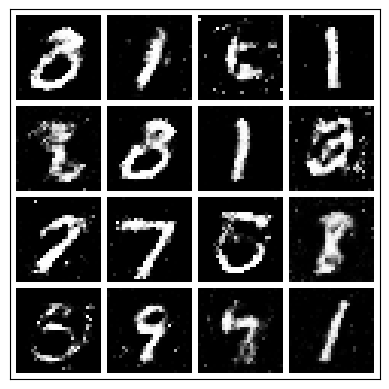

-------------------------------------
                Epoch 31: 
                Step: 1500 | 
                D_real Loss: 0.5939 | 
                D_fake Loss: 0.6454 | 
                D_total Loss: 1.2393 | 
                G_Loss: 1.639 |
                Real_score 0.605 | 
                Fake_score 0.403 
            


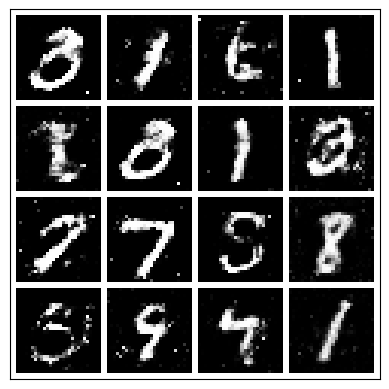

-------------------------------------
                Epoch 31: 
                Step: 2000 | 
                D_real Loss: 0.6821 | 
                D_fake Loss: 0.4759 | 
                D_total Loss: 1.1580 | 
                G_Loss: 1.051 |
                Real_score 0.530 | 
                Fake_score 0.355 
            


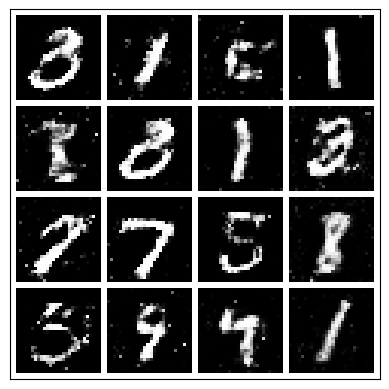

-------------------------------------
                Epoch 31: 
                Step: 2500 | 
                D_real Loss: 0.5361 | 
                D_fake Loss: 0.4158 | 
                D_total Loss: 0.9519 | 
                G_Loss: 1.259 |
                Real_score 0.624 | 
                Fake_score 0.326 
            


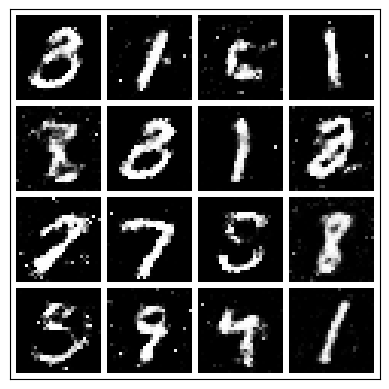

-------------------------------------
                Epoch 31: 
                Step: 3000 | 
                D_real Loss: 0.4252 | 
                D_fake Loss: 0.5183 | 
                D_total Loss: 0.9435 | 
                G_Loss: 1.139 |
                Real_score 0.697 | 
                Fake_score 0.376 
            


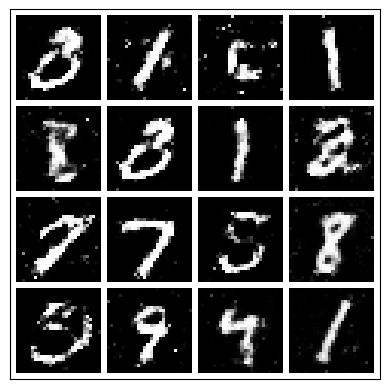

-------------------------------------
                Epoch 31: 
                Step: 3500 | 
                D_real Loss: 0.6204 | 
                D_fake Loss: 0.4634 | 
                D_total Loss: 1.0839 | 
                G_Loss: 1.257 |
                Real_score 0.637 | 
                Fake_score 0.352 
            


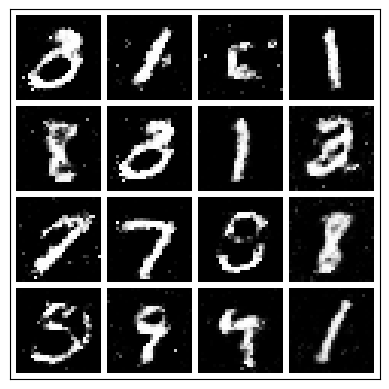

 62%|███████████████████████████▎                | 31/50 [46:03<27:43, 87.57s/it]

-------------------------------------
                Epoch 32: 
                Step: 0 | 
                D_real Loss: 0.4215 | 
                D_fake Loss: 0.5379 | 
                D_total Loss: 0.9594 | 
                G_Loss: 1.062 |
                Real_score 0.719 | 
                Fake_score 0.389 
            


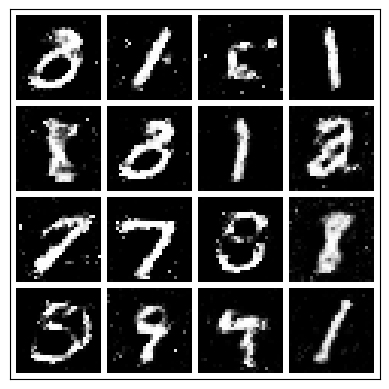

-------------------------------------
                Epoch 32: 
                Step: 500 | 
                D_real Loss: 0.5248 | 
                D_fake Loss: 0.7178 | 
                D_total Loss: 1.2425 | 
                G_Loss: 0.907 |
                Real_score 0.634 | 
                Fake_score 0.472 
            


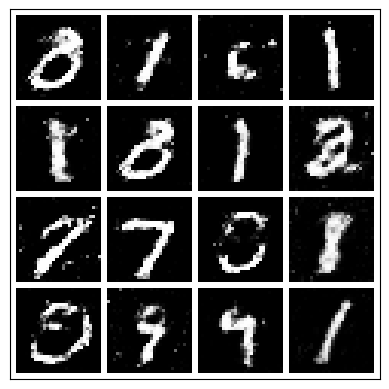

-------------------------------------
                Epoch 32: 
                Step: 1000 | 
                D_real Loss: 0.8520 | 
                D_fake Loss: 0.4064 | 
                D_total Loss: 1.2585 | 
                G_Loss: 1.177 |
                Real_score 0.459 | 
                Fake_score 0.311 
            


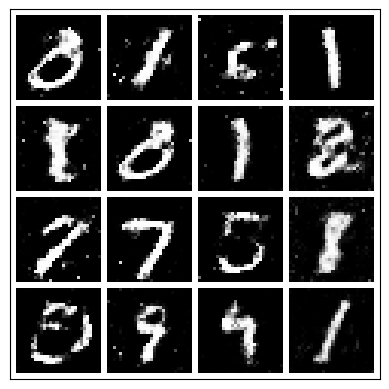

-------------------------------------
                Epoch 32: 
                Step: 1500 | 
                D_real Loss: 0.5983 | 
                D_fake Loss: 0.4506 | 
                D_total Loss: 1.0489 | 
                G_Loss: 1.070 |
                Real_score 0.623 | 
                Fake_score 0.347 
            


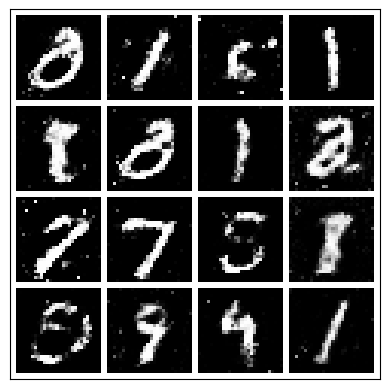

-------------------------------------
                Epoch 32: 
                Step: 2000 | 
                D_real Loss: 0.4828 | 
                D_fake Loss: 0.6542 | 
                D_total Loss: 1.1370 | 
                G_Loss: 0.980 |
                Real_score 0.658 | 
                Fake_score 0.457 
            


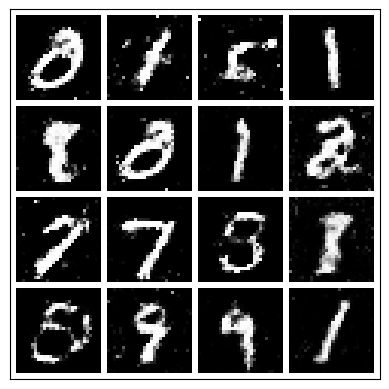

-------------------------------------
                Epoch 32: 
                Step: 2500 | 
                D_real Loss: 0.4277 | 
                D_fake Loss: 0.5946 | 
                D_total Loss: 1.0223 | 
                G_Loss: 0.980 |
                Real_score 0.698 | 
                Fake_score 0.427 
            


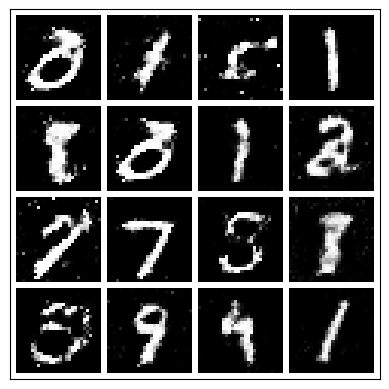

-------------------------------------
                Epoch 32: 
                Step: 3000 | 
                D_real Loss: 0.6860 | 
                D_fake Loss: 0.3486 | 
                D_total Loss: 1.0346 | 
                G_Loss: 1.488 |
                Real_score 0.563 | 
                Fake_score 0.263 
            


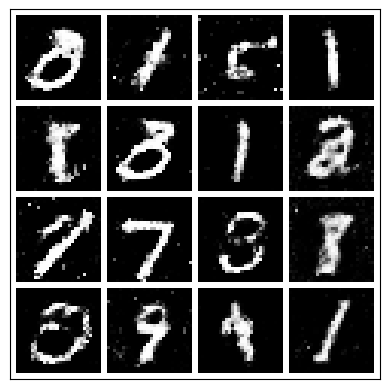

-------------------------------------
                Epoch 32: 
                Step: 3500 | 
                D_real Loss: 0.3916 | 
                D_fake Loss: 0.7284 | 
                D_total Loss: 1.1200 | 
                G_Loss: 1.003 |
                Real_score 0.711 | 
                Fake_score 0.473 
            


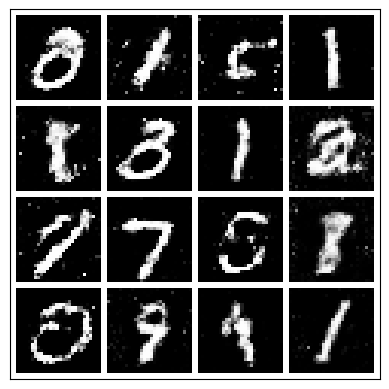

 64%|████████████████████████████▏               | 32/50 [47:20<25:23, 84.66s/it]

-------------------------------------
                Epoch 33: 
                Step: 0 | 
                D_real Loss: 0.4807 | 
                D_fake Loss: 0.6012 | 
                D_total Loss: 1.0819 | 
                G_Loss: 1.042 |
                Real_score 0.667 | 
                Fake_score 0.389 
            


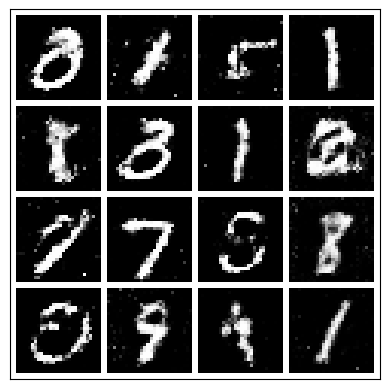

-------------------------------------
                Epoch 33: 
                Step: 500 | 
                D_real Loss: 0.5633 | 
                D_fake Loss: 0.5115 | 
                D_total Loss: 1.0748 | 
                G_Loss: 1.064 |
                Real_score 0.616 | 
                Fake_score 0.357 
            


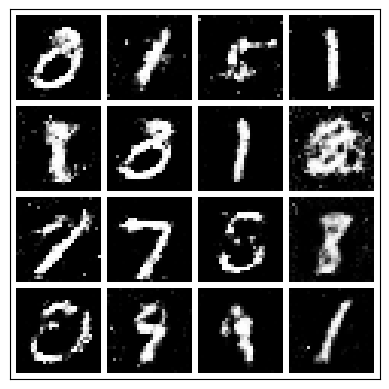

-------------------------------------
                Epoch 33: 
                Step: 1000 | 
                D_real Loss: 0.5639 | 
                D_fake Loss: 0.4316 | 
                D_total Loss: 0.9955 | 
                G_Loss: 1.282 |
                Real_score 0.647 | 
                Fake_score 0.337 
            


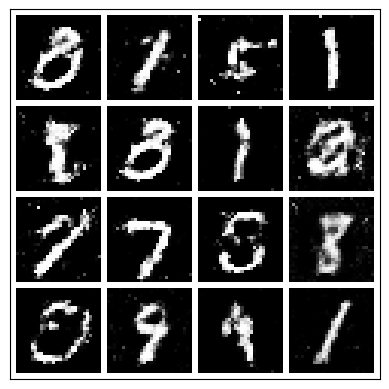

-------------------------------------
                Epoch 33: 
                Step: 1500 | 
                D_real Loss: 0.6414 | 
                D_fake Loss: 0.4961 | 
                D_total Loss: 1.1375 | 
                G_Loss: 1.202 |
                Real_score 0.587 | 
                Fake_score 0.360 
            


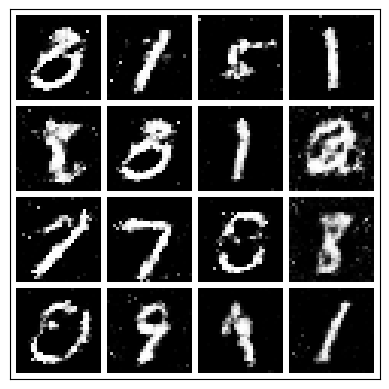

-------------------------------------
                Epoch 33: 
                Step: 2000 | 
                D_real Loss: 0.6667 | 
                D_fake Loss: 0.5488 | 
                D_total Loss: 1.2155 | 
                G_Loss: 0.931 |
                Real_score 0.561 | 
                Fake_score 0.394 
            


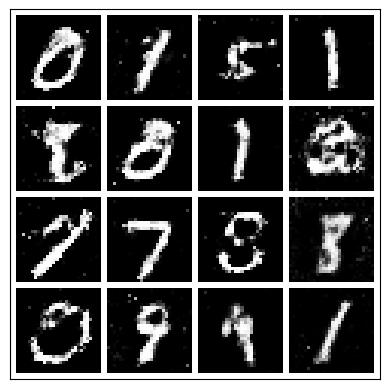

-------------------------------------
                Epoch 33: 
                Step: 2500 | 
                D_real Loss: 0.5058 | 
                D_fake Loss: 0.9006 | 
                D_total Loss: 1.4064 | 
                G_Loss: 0.897 |
                Real_score 0.638 | 
                Fake_score 0.489 
            


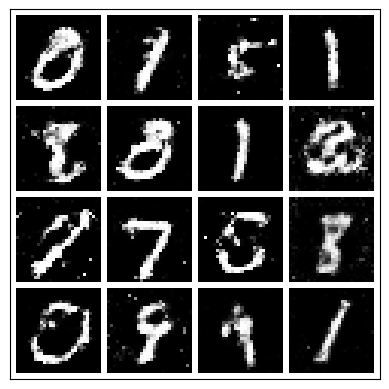

-------------------------------------
                Epoch 33: 
                Step: 3000 | 
                D_real Loss: 0.6590 | 
                D_fake Loss: 0.5953 | 
                D_total Loss: 1.2544 | 
                G_Loss: 1.007 |
                Real_score 0.580 | 
                Fake_score 0.413 
            


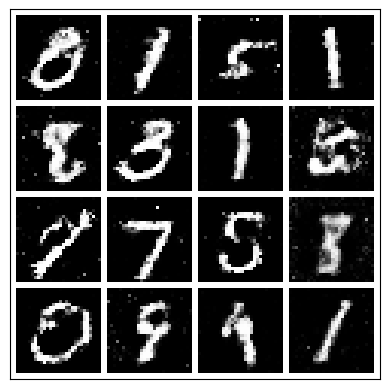

-------------------------------------
                Epoch 33: 
                Step: 3500 | 
                D_real Loss: 0.2665 | 
                D_fake Loss: 0.5349 | 
                D_total Loss: 0.8014 | 
                G_Loss: 0.946 |
                Real_score 0.799 | 
                Fake_score 0.387 
            


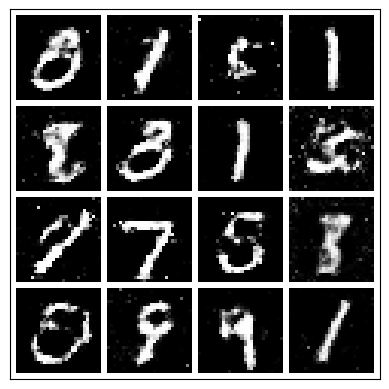

 66%|█████████████████████████████               | 33/50 [48:45<23:57, 84.54s/it]

-------------------------------------
                Epoch 34: 
                Step: 0 | 
                D_real Loss: 0.5558 | 
                D_fake Loss: 0.7772 | 
                D_total Loss: 1.3330 | 
                G_Loss: 0.765 |
                Real_score 0.616 | 
                Fake_score 0.514 
            


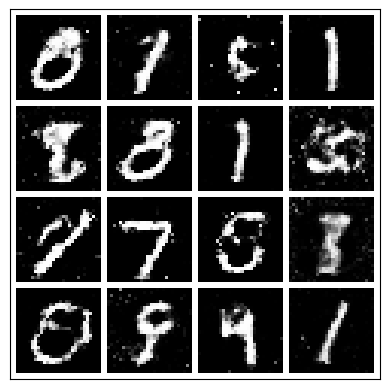

-------------------------------------
                Epoch 34: 
                Step: 500 | 
                D_real Loss: 0.4850 | 
                D_fake Loss: 0.6035 | 
                D_total Loss: 1.0885 | 
                G_Loss: 1.124 |
                Real_score 0.646 | 
                Fake_score 0.435 
            


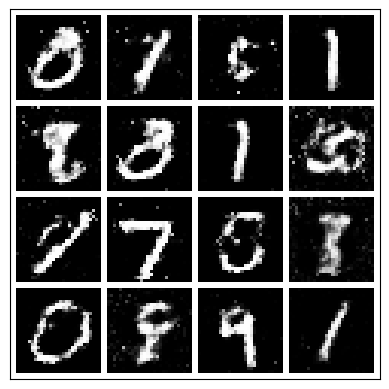

-------------------------------------
                Epoch 34: 
                Step: 1000 | 
                D_real Loss: 0.6729 | 
                D_fake Loss: 0.5990 | 
                D_total Loss: 1.2719 | 
                G_Loss: 0.677 |
                Real_score 0.565 | 
                Fake_score 0.397 
            


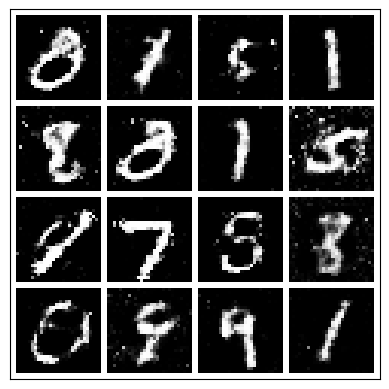

-------------------------------------
                Epoch 34: 
                Step: 1500 | 
                D_real Loss: 0.6777 | 
                D_fake Loss: 0.7109 | 
                D_total Loss: 1.3886 | 
                G_Loss: 1.205 |
                Real_score 0.548 | 
                Fake_score 0.447 
            


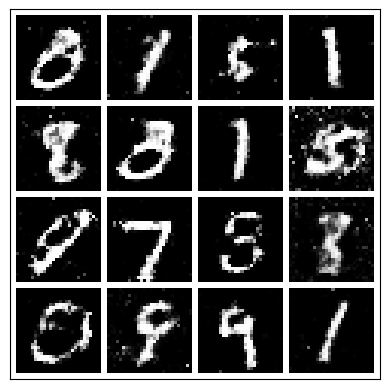

-------------------------------------
                Epoch 34: 
                Step: 2000 | 
                D_real Loss: 0.6539 | 
                D_fake Loss: 0.4548 | 
                D_total Loss: 1.1087 | 
                G_Loss: 1.106 |
                Real_score 0.577 | 
                Fake_score 0.332 
            


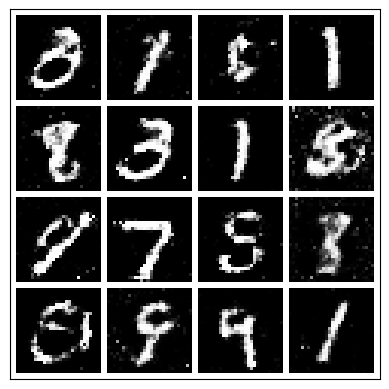

-------------------------------------
                Epoch 34: 
                Step: 2500 | 
                D_real Loss: 0.6422 | 
                D_fake Loss: 0.5211 | 
                D_total Loss: 1.1633 | 
                G_Loss: 1.065 |
                Real_score 0.570 | 
                Fake_score 0.393 
            


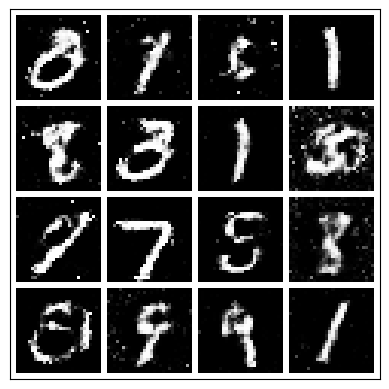

-------------------------------------
                Epoch 34: 
                Step: 3000 | 
                D_real Loss: 0.6002 | 
                D_fake Loss: 0.7789 | 
                D_total Loss: 1.3792 | 
                G_Loss: 0.971 |
                Real_score 0.594 | 
                Fake_score 0.463 
            


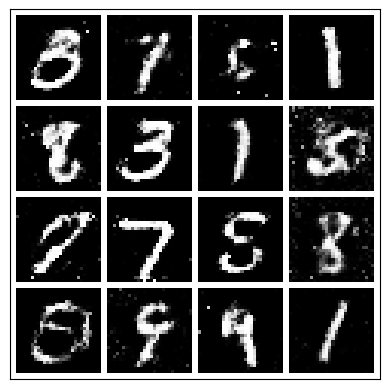

-------------------------------------
                Epoch 34: 
                Step: 3500 | 
                D_real Loss: 0.6454 | 
                D_fake Loss: 0.5850 | 
                D_total Loss: 1.2304 | 
                G_Loss: 0.904 |
                Real_score 0.565 | 
                Fake_score 0.412 
            


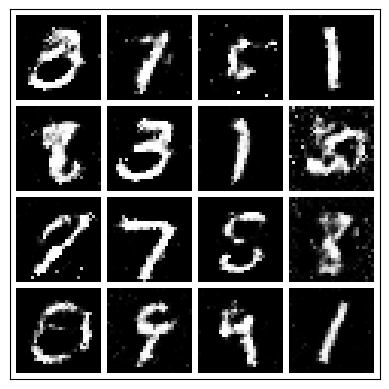

 68%|█████████████████████████████▉              | 34/50 [49:56<21:30, 80.64s/it]

-------------------------------------
                Epoch 35: 
                Step: 0 | 
                D_real Loss: 0.7539 | 
                D_fake Loss: 0.6844 | 
                D_total Loss: 1.4384 | 
                G_Loss: 0.766 |
                Real_score 0.533 | 
                Fake_score 0.471 
            


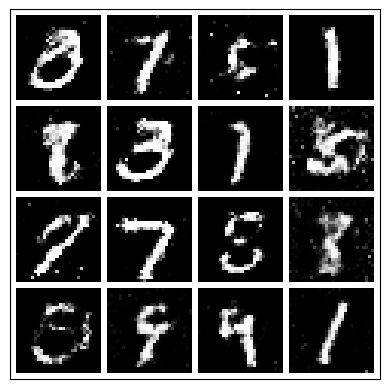

-------------------------------------
                Epoch 35: 
                Step: 500 | 
                D_real Loss: 0.4964 | 
                D_fake Loss: 0.6914 | 
                D_total Loss: 1.1878 | 
                G_Loss: 0.959 |
                Real_score 0.633 | 
                Fake_score 0.414 
            


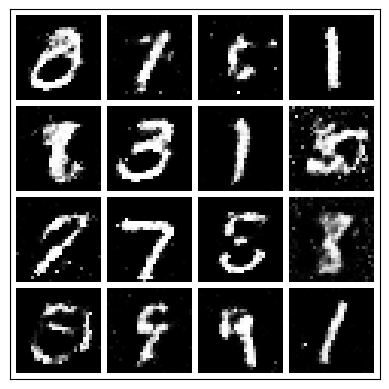

-------------------------------------
                Epoch 35: 
                Step: 1000 | 
                D_real Loss: 0.4867 | 
                D_fake Loss: 0.4976 | 
                D_total Loss: 0.9843 | 
                G_Loss: 0.940 |
                Real_score 0.642 | 
                Fake_score 0.365 
            


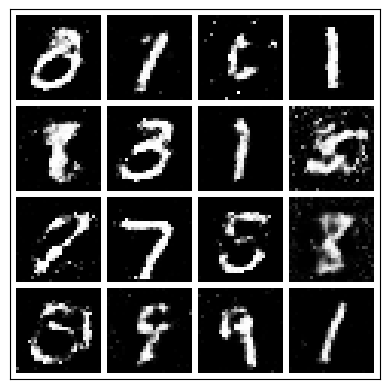

-------------------------------------
                Epoch 35: 
                Step: 1500 | 
                D_real Loss: 0.6786 | 
                D_fake Loss: 0.6576 | 
                D_total Loss: 1.3362 | 
                G_Loss: 0.933 |
                Real_score 0.572 | 
                Fake_score 0.458 
            


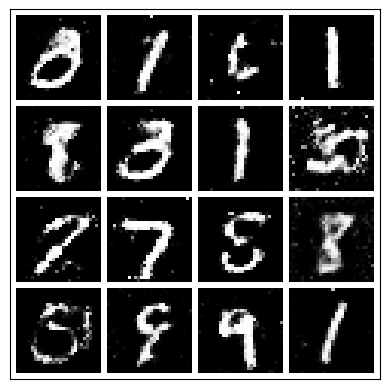

-------------------------------------
                Epoch 35: 
                Step: 2000 | 
                D_real Loss: 0.4689 | 
                D_fake Loss: 0.5992 | 
                D_total Loss: 1.0681 | 
                G_Loss: 0.895 |
                Real_score 0.673 | 
                Fake_score 0.424 
            


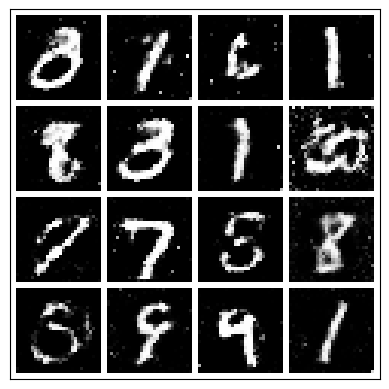

-------------------------------------
                Epoch 35: 
                Step: 2500 | 
                D_real Loss: 0.7714 | 
                D_fake Loss: 0.6127 | 
                D_total Loss: 1.3841 | 
                G_Loss: 1.022 |
                Real_score 0.512 | 
                Fake_score 0.430 
            


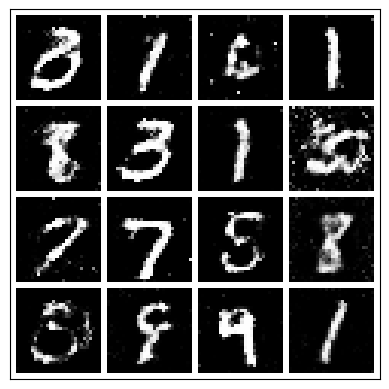

-------------------------------------
                Epoch 35: 
                Step: 3000 | 
                D_real Loss: 0.6311 | 
                D_fake Loss: 0.3076 | 
                D_total Loss: 0.9388 | 
                G_Loss: 1.263 |
                Real_score 0.579 | 
                Fake_score 0.258 
            


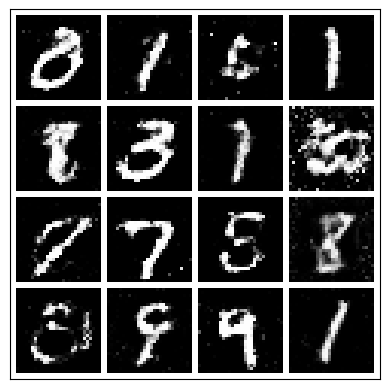

-------------------------------------
                Epoch 35: 
                Step: 3500 | 
                D_real Loss: 0.6728 | 
                D_fake Loss: 0.5039 | 
                D_total Loss: 1.1767 | 
                G_Loss: 1.106 |
                Real_score 0.570 | 
                Fake_score 0.374 
            


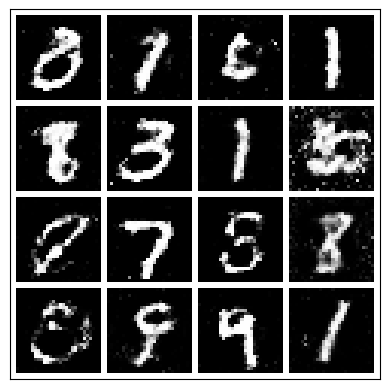

 70%|██████████████████████████████▊             | 35/50 [51:12<19:47, 79.19s/it]

-------------------------------------
                Epoch 36: 
                Step: 0 | 
                D_real Loss: 0.6673 | 
                D_fake Loss: 0.5770 | 
                D_total Loss: 1.2443 | 
                G_Loss: 1.133 |
                Real_score 0.542 | 
                Fake_score 0.401 
            


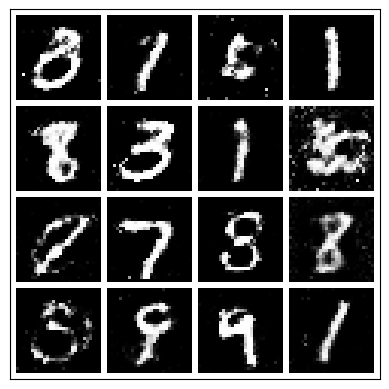

-------------------------------------
                Epoch 36: 
                Step: 500 | 
                D_real Loss: 0.6571 | 
                D_fake Loss: 0.3894 | 
                D_total Loss: 1.0465 | 
                G_Loss: 1.245 |
                Real_score 0.576 | 
                Fake_score 0.307 
            


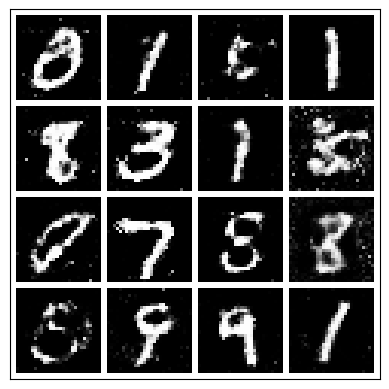

-------------------------------------
                Epoch 36: 
                Step: 1000 | 
                D_real Loss: 0.5169 | 
                D_fake Loss: 0.4126 | 
                D_total Loss: 0.9295 | 
                G_Loss: 1.091 |
                Real_score 0.625 | 
                Fake_score 0.326 
            


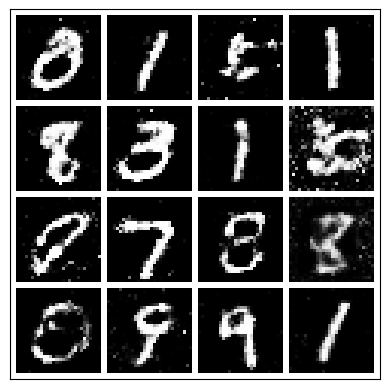

-------------------------------------
                Epoch 36: 
                Step: 1500 | 
                D_real Loss: 0.6386 | 
                D_fake Loss: 0.5034 | 
                D_total Loss: 1.1420 | 
                G_Loss: 0.955 |
                Real_score 0.568 | 
                Fake_score 0.385 
            


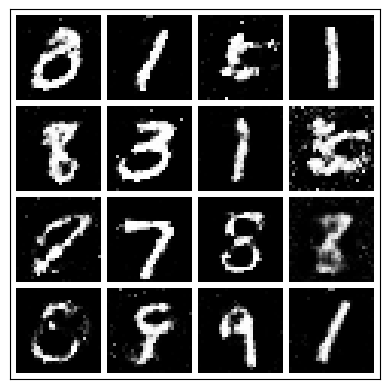

-------------------------------------
                Epoch 36: 
                Step: 2000 | 
                D_real Loss: 0.5060 | 
                D_fake Loss: 0.5318 | 
                D_total Loss: 1.0378 | 
                G_Loss: 0.948 |
                Real_score 0.631 | 
                Fake_score 0.391 
            


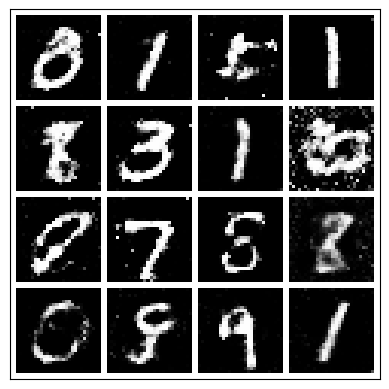

-------------------------------------
                Epoch 36: 
                Step: 2500 | 
                D_real Loss: 0.4950 | 
                D_fake Loss: 0.5961 | 
                D_total Loss: 1.0911 | 
                G_Loss: 1.138 |
                Real_score 0.656 | 
                Fake_score 0.431 
            


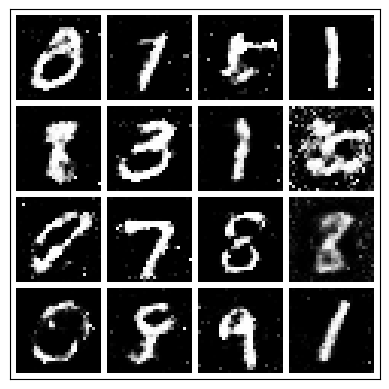

-------------------------------------
                Epoch 36: 
                Step: 3000 | 
                D_real Loss: 0.6380 | 
                D_fake Loss: 0.5044 | 
                D_total Loss: 1.1423 | 
                G_Loss: 1.100 |
                Real_score 0.559 | 
                Fake_score 0.377 
            


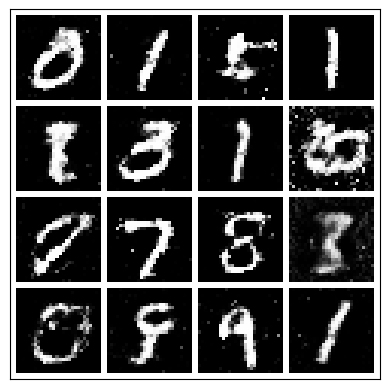

-------------------------------------
                Epoch 36: 
                Step: 3500 | 
                D_real Loss: 0.6526 | 
                D_fake Loss: 0.7471 | 
                D_total Loss: 1.3997 | 
                G_Loss: 0.844 |
                Real_score 0.559 | 
                Fake_score 0.479 
            


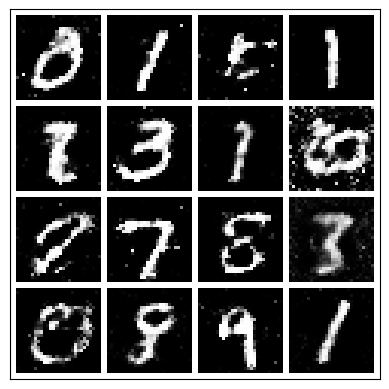

 72%|███████████████████████████████▋            | 36/50 [52:30<18:24, 78.92s/it]

-------------------------------------
                Epoch 37: 
                Step: 0 | 
                D_real Loss: 0.7021 | 
                D_fake Loss: 0.5038 | 
                D_total Loss: 1.2059 | 
                G_Loss: 1.288 |
                Real_score 0.551 | 
                Fake_score 0.357 
            


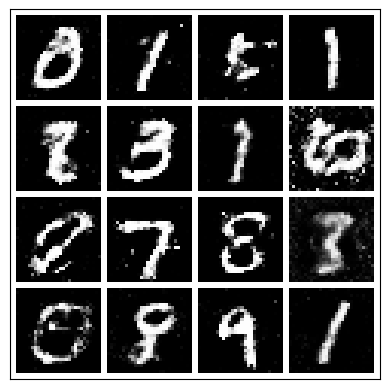

-------------------------------------
                Epoch 37: 
                Step: 500 | 
                D_real Loss: 0.5926 | 
                D_fake Loss: 0.5186 | 
                D_total Loss: 1.1111 | 
                G_Loss: 1.032 |
                Real_score 0.622 | 
                Fake_score 0.361 
            


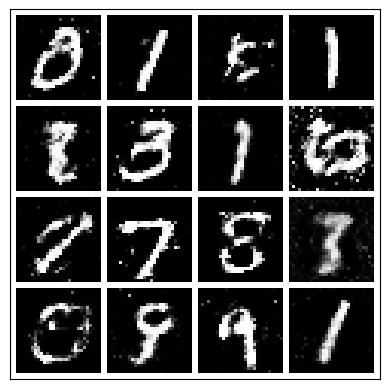

-------------------------------------
                Epoch 37: 
                Step: 1000 | 
                D_real Loss: 0.6009 | 
                D_fake Loss: 0.7634 | 
                D_total Loss: 1.3643 | 
                G_Loss: 0.869 |
                Real_score 0.603 | 
                Fake_score 0.446 
            


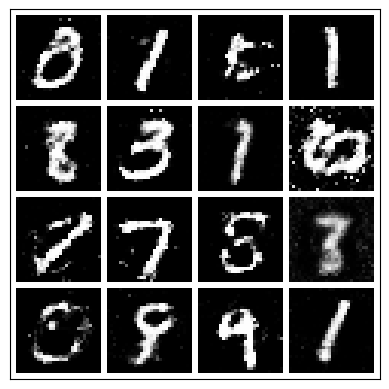

-------------------------------------
                Epoch 37: 
                Step: 1500 | 
                D_real Loss: 0.6056 | 
                D_fake Loss: 0.4986 | 
                D_total Loss: 1.1042 | 
                G_Loss: 1.006 |
                Real_score 0.610 | 
                Fake_score 0.373 
            


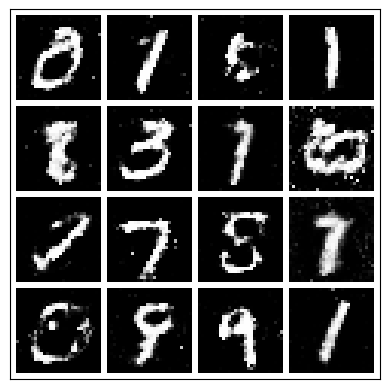

-------------------------------------
                Epoch 37: 
                Step: 2000 | 
                D_real Loss: 0.5407 | 
                D_fake Loss: 0.7640 | 
                D_total Loss: 1.3047 | 
                G_Loss: 1.008 |
                Real_score 0.639 | 
                Fake_score 0.500 
            


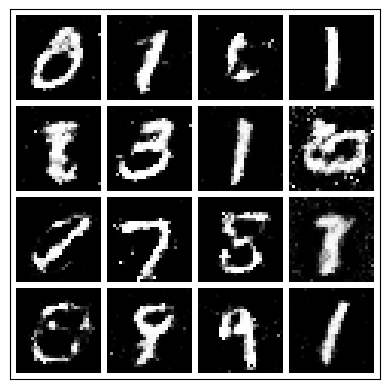

-------------------------------------
                Epoch 37: 
                Step: 2500 | 
                D_real Loss: 0.5746 | 
                D_fake Loss: 0.4622 | 
                D_total Loss: 1.0368 | 
                G_Loss: 0.937 |
                Real_score 0.606 | 
                Fake_score 0.336 
            


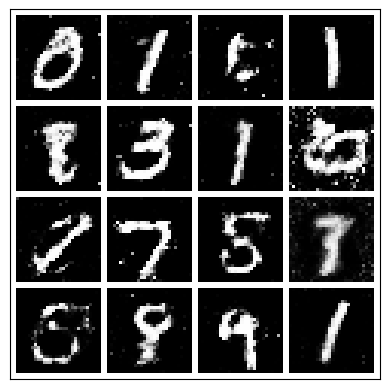

-------------------------------------
                Epoch 37: 
                Step: 3000 | 
                D_real Loss: 0.6687 | 
                D_fake Loss: 0.4622 | 
                D_total Loss: 1.1309 | 
                G_Loss: 1.183 |
                Real_score 0.546 | 
                Fake_score 0.342 
            


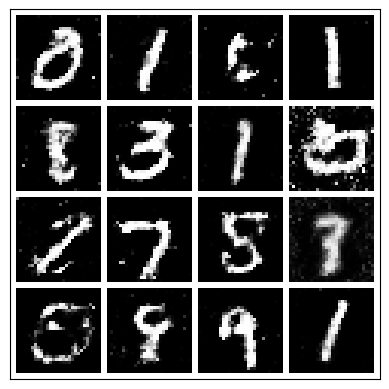

-------------------------------------
                Epoch 37: 
                Step: 3500 | 
                D_real Loss: 0.3958 | 
                D_fake Loss: 0.6807 | 
                D_total Loss: 1.0764 | 
                G_Loss: 0.910 |
                Real_score 0.702 | 
                Fake_score 0.468 
            


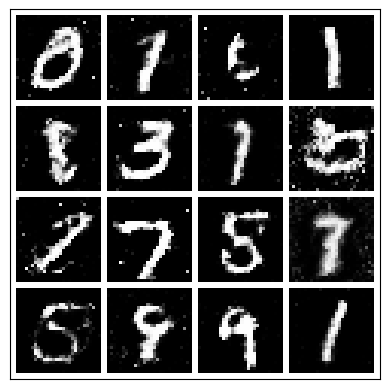

 74%|████████████████████████████████▌           | 37/50 [53:57<17:35, 81.23s/it]

-------------------------------------
                Epoch 38: 
                Step: 0 | 
                D_real Loss: 0.7158 | 
                D_fake Loss: 0.4708 | 
                D_total Loss: 1.1866 | 
                G_Loss: 1.265 |
                Real_score 0.533 | 
                Fake_score 0.339 
            


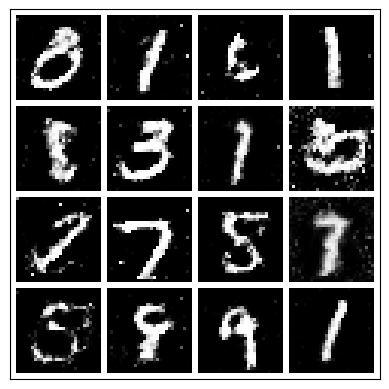

-------------------------------------
                Epoch 38: 
                Step: 500 | 
                D_real Loss: 0.3457 | 
                D_fake Loss: 0.6266 | 
                D_total Loss: 0.9722 | 
                G_Loss: 1.163 |
                Real_score 0.745 | 
                Fake_score 0.400 
            


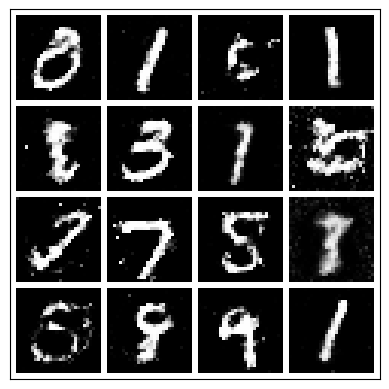

-------------------------------------
                Epoch 38: 
                Step: 1000 | 
                D_real Loss: 0.7189 | 
                D_fake Loss: 0.5410 | 
                D_total Loss: 1.2599 | 
                G_Loss: 0.958 |
                Real_score 0.531 | 
                Fake_score 0.393 
            


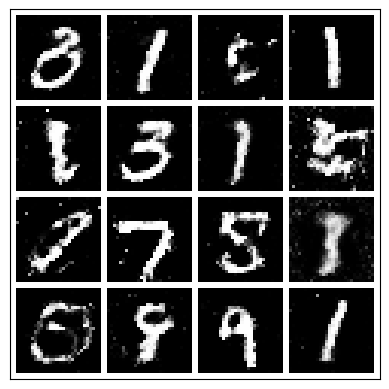

-------------------------------------
                Epoch 38: 
                Step: 1500 | 
                D_real Loss: 0.4807 | 
                D_fake Loss: 0.5209 | 
                D_total Loss: 1.0016 | 
                G_Loss: 1.238 |
                Real_score 0.651 | 
                Fake_score 0.371 
            


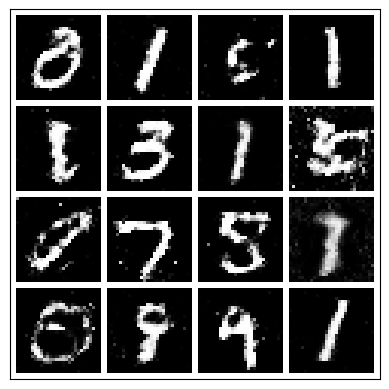

-------------------------------------
                Epoch 38: 
                Step: 2000 | 
                D_real Loss: 0.6781 | 
                D_fake Loss: 0.4111 | 
                D_total Loss: 1.0892 | 
                G_Loss: 1.194 |
                Real_score 0.526 | 
                Fake_score 0.327 
            


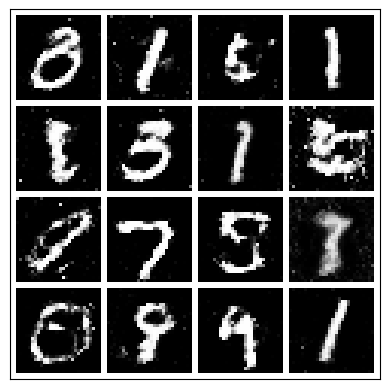

-------------------------------------
                Epoch 38: 
                Step: 2500 | 
                D_real Loss: 0.7870 | 
                D_fake Loss: 0.4156 | 
                D_total Loss: 1.2026 | 
                G_Loss: 0.964 |
                Real_score 0.492 | 
                Fake_score 0.332 
            


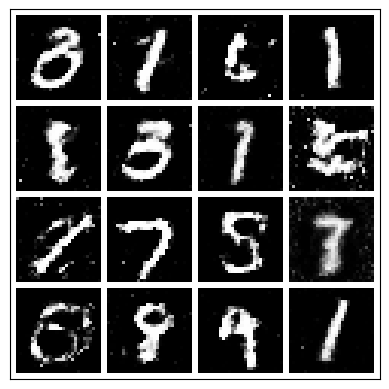

-------------------------------------
                Epoch 38: 
                Step: 3000 | 
                D_real Loss: 0.6651 | 
                D_fake Loss: 0.5818 | 
                D_total Loss: 1.2469 | 
                G_Loss: 1.072 |
                Real_score 0.548 | 
                Fake_score 0.407 
            


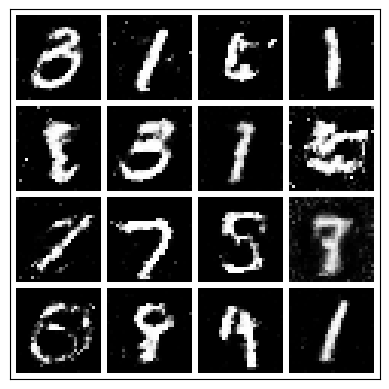

-------------------------------------
                Epoch 38: 
                Step: 3500 | 
                D_real Loss: 0.4370 | 
                D_fake Loss: 0.5889 | 
                D_total Loss: 1.0259 | 
                G_Loss: 0.830 |
                Real_score 0.670 | 
                Fake_score 0.430 
            


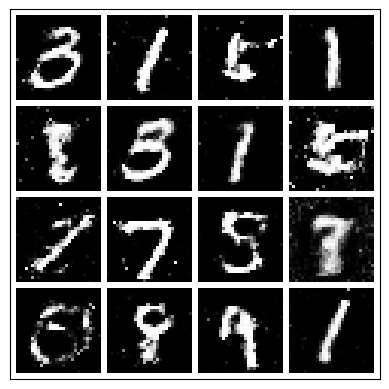

 76%|█████████████████████████████████▍          | 38/50 [55:36<17:19, 86.65s/it]

-------------------------------------
                Epoch 39: 
                Step: 0 | 
                D_real Loss: 0.5820 | 
                D_fake Loss: 0.5427 | 
                D_total Loss: 1.1247 | 
                G_Loss: 1.030 |
                Real_score 0.593 | 
                Fake_score 0.402 
            


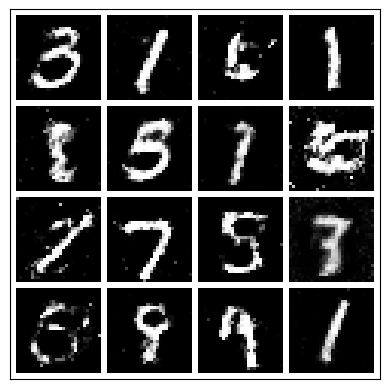

-------------------------------------
                Epoch 39: 
                Step: 500 | 
                D_real Loss: 0.7231 | 
                D_fake Loss: 0.6789 | 
                D_total Loss: 1.4020 | 
                G_Loss: 0.856 |
                Real_score 0.566 | 
                Fake_score 0.464 
            


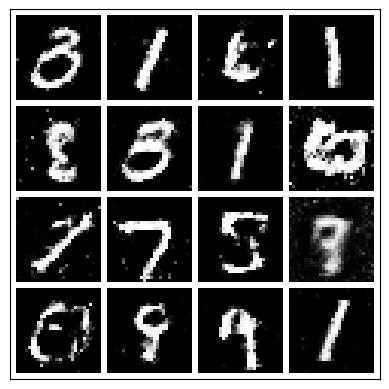

-------------------------------------
                Epoch 39: 
                Step: 1000 | 
                D_real Loss: 0.6493 | 
                D_fake Loss: 0.5748 | 
                D_total Loss: 1.2241 | 
                G_Loss: 1.000 |
                Real_score 0.566 | 
                Fake_score 0.400 
            


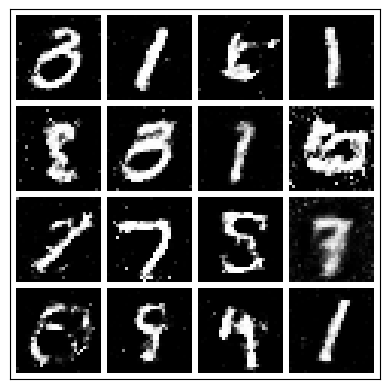

-------------------------------------
                Epoch 39: 
                Step: 1500 | 
                D_real Loss: 0.6593 | 
                D_fake Loss: 0.6437 | 
                D_total Loss: 1.3030 | 
                G_Loss: 0.937 |
                Real_score 0.551 | 
                Fake_score 0.460 
            


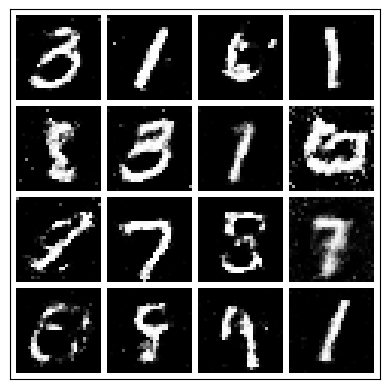

-------------------------------------
                Epoch 39: 
                Step: 2000 | 
                D_real Loss: 0.5306 | 
                D_fake Loss: 0.4585 | 
                D_total Loss: 0.9891 | 
                G_Loss: 1.242 |
                Real_score 0.618 | 
                Fake_score 0.341 
            


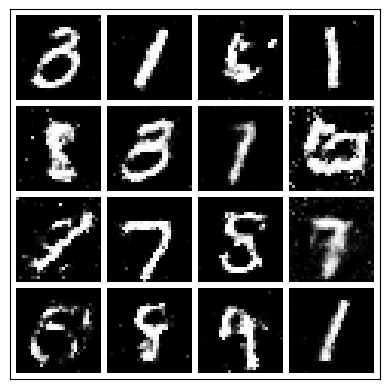

-------------------------------------
                Epoch 39: 
                Step: 2500 | 
                D_real Loss: 0.6443 | 
                D_fake Loss: 0.5730 | 
                D_total Loss: 1.2173 | 
                G_Loss: 0.919 |
                Real_score 0.566 | 
                Fake_score 0.404 
            


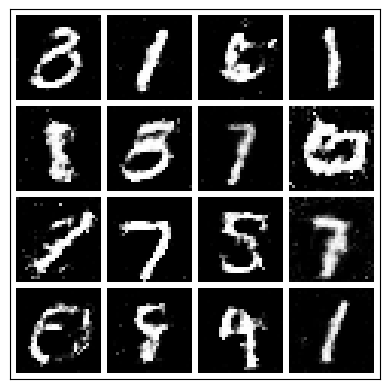

-------------------------------------
                Epoch 39: 
                Step: 3000 | 
                D_real Loss: 0.4604 | 
                D_fake Loss: 0.5303 | 
                D_total Loss: 0.9908 | 
                G_Loss: 1.122 |
                Real_score 0.663 | 
                Fake_score 0.391 
            


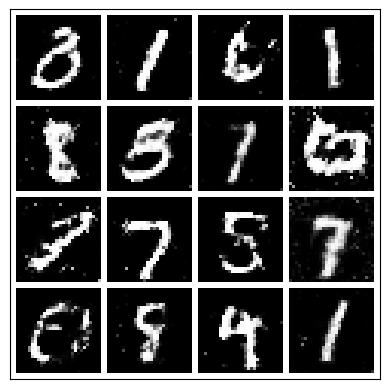

-------------------------------------
                Epoch 39: 
                Step: 3500 | 
                D_real Loss: 0.5629 | 
                D_fake Loss: 0.5911 | 
                D_total Loss: 1.1540 | 
                G_Loss: 0.853 |
                Real_score 0.622 | 
                Fake_score 0.419 
            


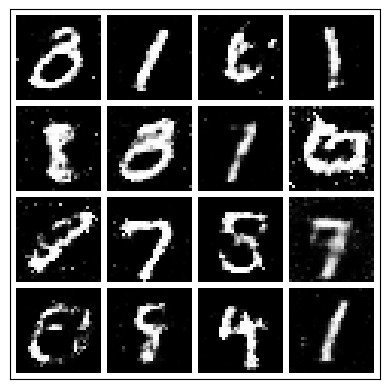

 78%|██████████████████████████████████▎         | 39/50 [56:57<15:33, 84.82s/it]

-------------------------------------
                Epoch 40: 
                Step: 0 | 
                D_real Loss: 0.5756 | 
                D_fake Loss: 0.7066 | 
                D_total Loss: 1.2822 | 
                G_Loss: 0.888 |
                Real_score 0.602 | 
                Fake_score 0.479 
            


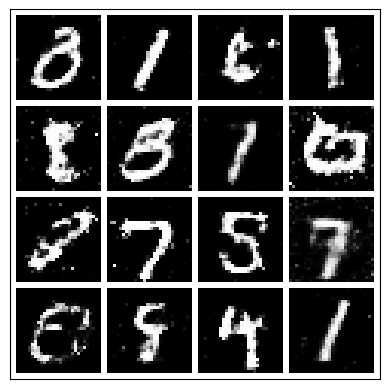

-------------------------------------
                Epoch 40: 
                Step: 500 | 
                D_real Loss: 0.4978 | 
                D_fake Loss: 0.5881 | 
                D_total Loss: 1.0860 | 
                G_Loss: 1.216 |
                Real_score 0.667 | 
                Fake_score 0.416 
            


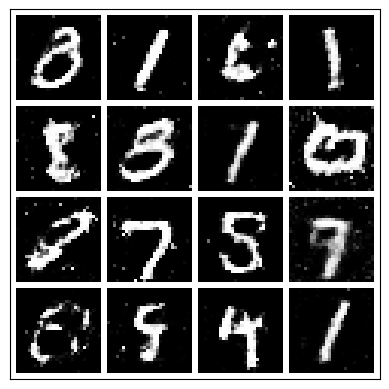

-------------------------------------
                Epoch 40: 
                Step: 1000 | 
                D_real Loss: 0.7167 | 
                D_fake Loss: 0.6864 | 
                D_total Loss: 1.4031 | 
                G_Loss: 0.926 |
                Real_score 0.525 | 
                Fake_score 0.474 
            


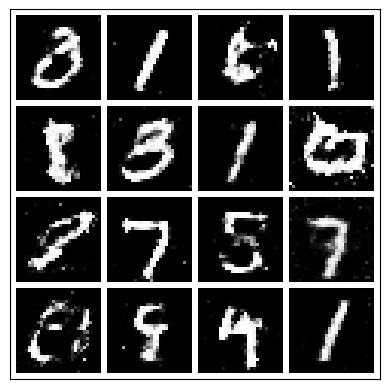

-------------------------------------
                Epoch 40: 
                Step: 1500 | 
                D_real Loss: 0.5562 | 
                D_fake Loss: 0.4697 | 
                D_total Loss: 1.0259 | 
                G_Loss: 1.037 |
                Real_score 0.654 | 
                Fake_score 0.361 
            


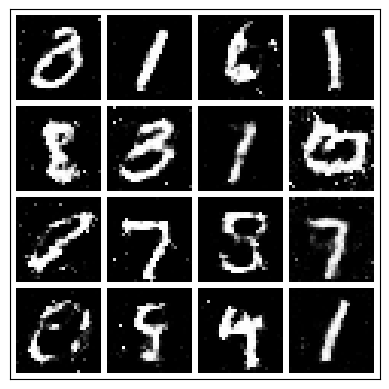

-------------------------------------
                Epoch 40: 
                Step: 2000 | 
                D_real Loss: 0.5570 | 
                D_fake Loss: 0.6539 | 
                D_total Loss: 1.2110 | 
                G_Loss: 0.806 |
                Real_score 0.599 | 
                Fake_score 0.451 
            


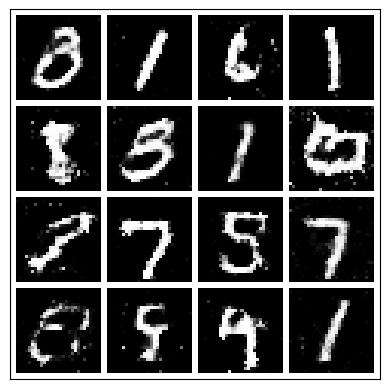

-------------------------------------
                Epoch 40: 
                Step: 2500 | 
                D_real Loss: 0.6603 | 
                D_fake Loss: 0.7150 | 
                D_total Loss: 1.3753 | 
                G_Loss: 0.777 |
                Real_score 0.538 | 
                Fake_score 0.479 
            


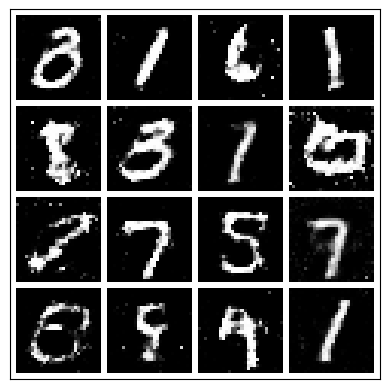

-------------------------------------
                Epoch 40: 
                Step: 3000 | 
                D_real Loss: 0.5852 | 
                D_fake Loss: 0.5829 | 
                D_total Loss: 1.1681 | 
                G_Loss: 0.894 |
                Real_score 0.594 | 
                Fake_score 0.419 
            


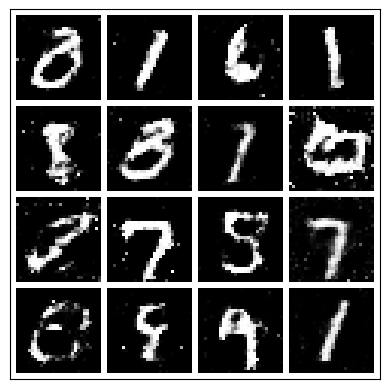

-------------------------------------
                Epoch 40: 
                Step: 3500 | 
                D_real Loss: 0.6538 | 
                D_fake Loss: 0.3649 | 
                D_total Loss: 1.0187 | 
                G_Loss: 1.184 |
                Real_score 0.552 | 
                Fake_score 0.294 
            


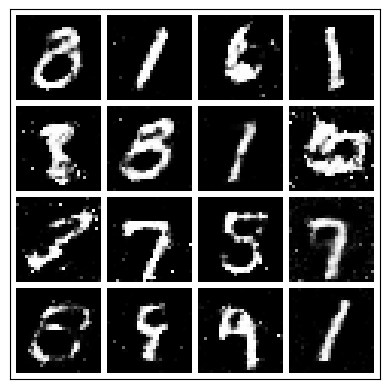

 80%|███████████████████████████████████▏        | 40/50 [58:33<14:43, 88.30s/it]

-------------------------------------
                Epoch 41: 
                Step: 0 | 
                D_real Loss: 0.4868 | 
                D_fake Loss: 0.6016 | 
                D_total Loss: 1.0885 | 
                G_Loss: 0.927 |
                Real_score 0.690 | 
                Fake_score 0.434 
            


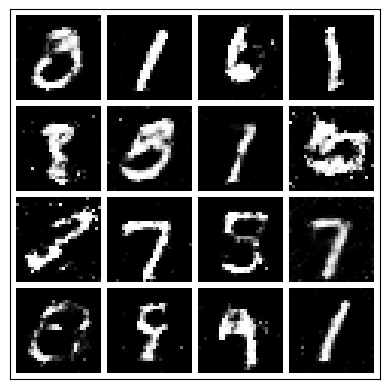

-------------------------------------
                Epoch 41: 
                Step: 500 | 
                D_real Loss: 0.5799 | 
                D_fake Loss: 0.9680 | 
                D_total Loss: 1.5479 | 
                G_Loss: 0.552 |
                Real_score 0.595 | 
                Fake_score 0.546 
            


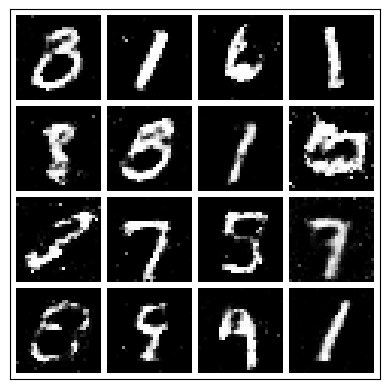

-------------------------------------
                Epoch 41: 
                Step: 1000 | 
                D_real Loss: 0.4717 | 
                D_fake Loss: 0.4519 | 
                D_total Loss: 0.9236 | 
                G_Loss: 0.872 |
                Real_score 0.668 | 
                Fake_score 0.356 
            


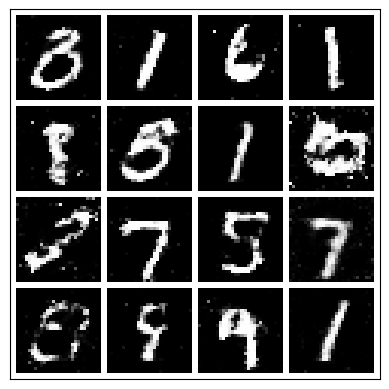

-------------------------------------
                Epoch 41: 
                Step: 1500 | 
                D_real Loss: 0.6570 | 
                D_fake Loss: 0.6836 | 
                D_total Loss: 1.3406 | 
                G_Loss: 0.770 |
                Real_score 0.557 | 
                Fake_score 0.453 
            


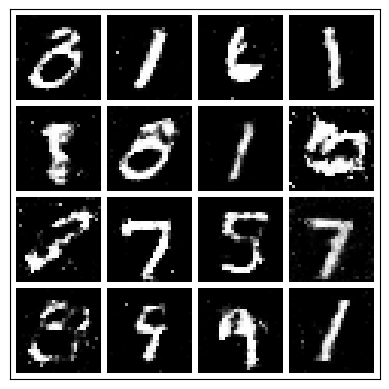

-------------------------------------
                Epoch 41: 
                Step: 2000 | 
                D_real Loss: 0.6887 | 
                D_fake Loss: 0.6899 | 
                D_total Loss: 1.3786 | 
                G_Loss: 1.078 |
                Real_score 0.570 | 
                Fake_score 0.470 
            


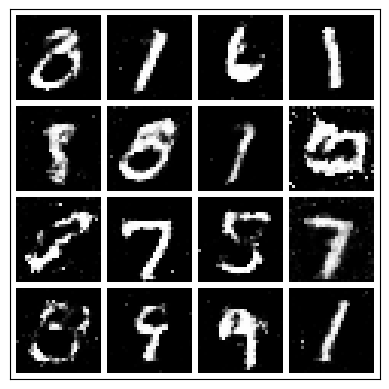

-------------------------------------
                Epoch 41: 
                Step: 2500 | 
                D_real Loss: 0.6711 | 
                D_fake Loss: 0.6939 | 
                D_total Loss: 1.3649 | 
                G_Loss: 0.803 |
                Real_score 0.564 | 
                Fake_score 0.442 
            


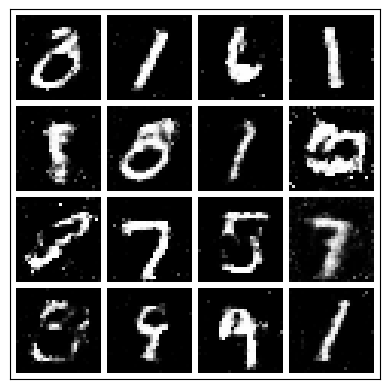

-------------------------------------
                Epoch 41: 
                Step: 3000 | 
                D_real Loss: 0.6097 | 
                D_fake Loss: 0.7040 | 
                D_total Loss: 1.3136 | 
                G_Loss: 0.877 |
                Real_score 0.568 | 
                Fake_score 0.487 
            


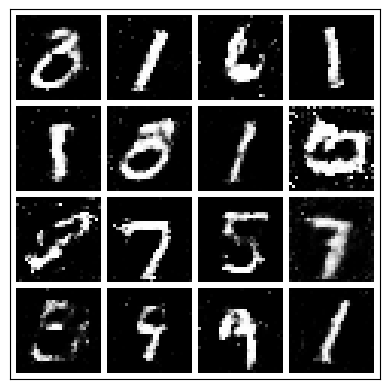

-------------------------------------
                Epoch 41: 
                Step: 3500 | 
                D_real Loss: 0.6053 | 
                D_fake Loss: 0.5584 | 
                D_total Loss: 1.1637 | 
                G_Loss: 1.015 |
                Real_score 0.594 | 
                Fake_score 0.393 
            


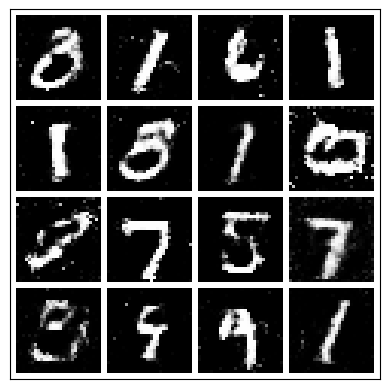

 82%|████████████████████████████████████        | 41/50 [59:54<12:54, 86.02s/it]

-------------------------------------
                Epoch 42: 
                Step: 0 | 
                D_real Loss: 0.4036 | 
                D_fake Loss: 0.5913 | 
                D_total Loss: 0.9949 | 
                G_Loss: 0.918 |
                Real_score 0.692 | 
                Fake_score 0.422 
            


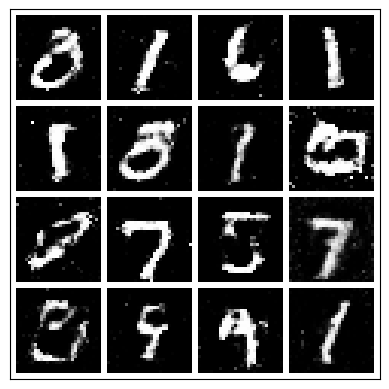

-------------------------------------
                Epoch 42: 
                Step: 500 | 
                D_real Loss: 0.6368 | 
                D_fake Loss: 0.4793 | 
                D_total Loss: 1.1161 | 
                G_Loss: 0.979 |
                Real_score 0.554 | 
                Fake_score 0.367 
            


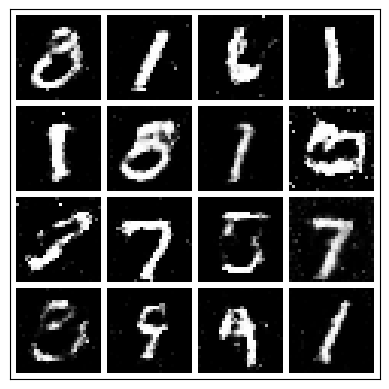

-------------------------------------
                Epoch 42: 
                Step: 1000 | 
                D_real Loss: 0.6813 | 
                D_fake Loss: 0.6467 | 
                D_total Loss: 1.3280 | 
                G_Loss: 1.054 |
                Real_score 0.546 | 
                Fake_score 0.424 
            


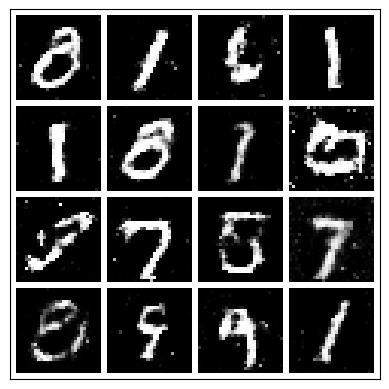

-------------------------------------
                Epoch 42: 
                Step: 1500 | 
                D_real Loss: 0.6880 | 
                D_fake Loss: 0.7168 | 
                D_total Loss: 1.4048 | 
                G_Loss: 1.000 |
                Real_score 0.546 | 
                Fake_score 0.478 
            


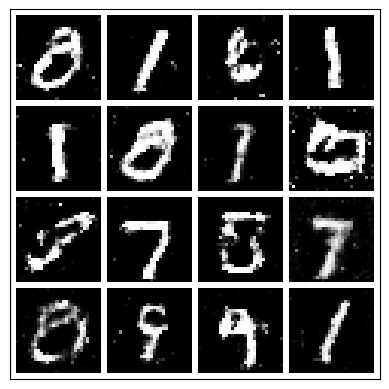

-------------------------------------
                Epoch 42: 
                Step: 2000 | 
                D_real Loss: 0.5635 | 
                D_fake Loss: 0.6490 | 
                D_total Loss: 1.2125 | 
                G_Loss: 0.971 |
                Real_score 0.613 | 
                Fake_score 0.444 
            


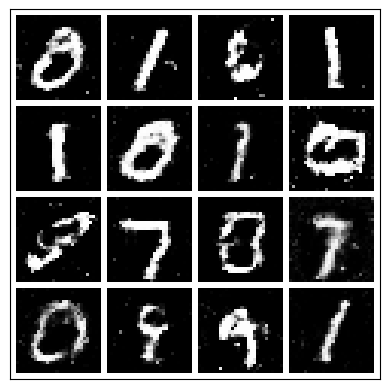

-------------------------------------
                Epoch 42: 
                Step: 2500 | 
                D_real Loss: 0.5401 | 
                D_fake Loss: 0.5899 | 
                D_total Loss: 1.1300 | 
                G_Loss: 1.009 |
                Real_score 0.631 | 
                Fake_score 0.431 
            


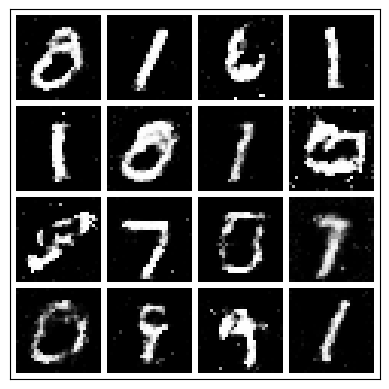

-------------------------------------
                Epoch 42: 
                Step: 3000 | 
                D_real Loss: 0.4040 | 
                D_fake Loss: 0.5366 | 
                D_total Loss: 0.9406 | 
                G_Loss: 0.941 |
                Real_score 0.690 | 
                Fake_score 0.396 
            


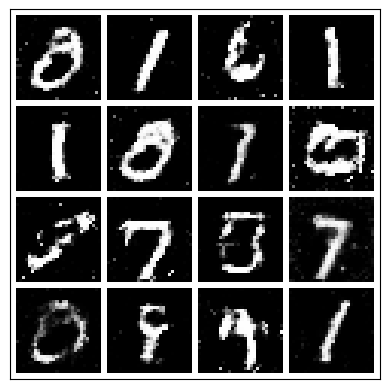

-------------------------------------
                Epoch 42: 
                Step: 3500 | 
                D_real Loss: 0.6570 | 
                D_fake Loss: 0.5793 | 
                D_total Loss: 1.2363 | 
                G_Loss: 1.029 |
                Real_score 0.550 | 
                Fake_score 0.380 
            


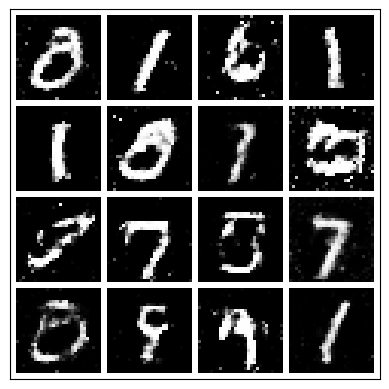

 84%|███████████████████████████████████▎      | 42/50 [1:01:09<11:01, 82.65s/it]

-------------------------------------
                Epoch 43: 
                Step: 0 | 
                D_real Loss: 0.7386 | 
                D_fake Loss: 0.5528 | 
                D_total Loss: 1.2914 | 
                G_Loss: 0.917 |
                Real_score 0.511 | 
                Fake_score 0.409 
            


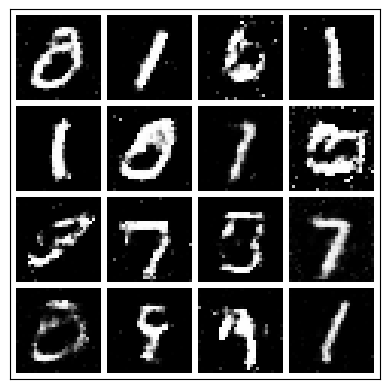

-------------------------------------
                Epoch 43: 
                Step: 500 | 
                D_real Loss: 0.5955 | 
                D_fake Loss: 0.5668 | 
                D_total Loss: 1.1623 | 
                G_Loss: 0.838 |
                Real_score 0.579 | 
                Fake_score 0.401 
            


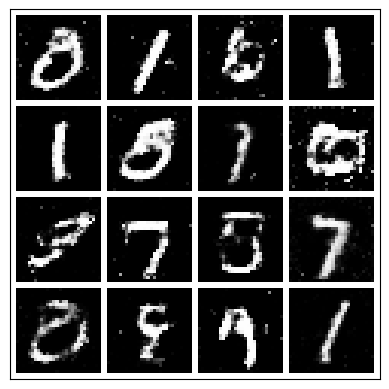

-------------------------------------
                Epoch 43: 
                Step: 1000 | 
                D_real Loss: 0.6722 | 
                D_fake Loss: 0.5155 | 
                D_total Loss: 1.1877 | 
                G_Loss: 1.161 |
                Real_score 0.547 | 
                Fake_score 0.383 
            


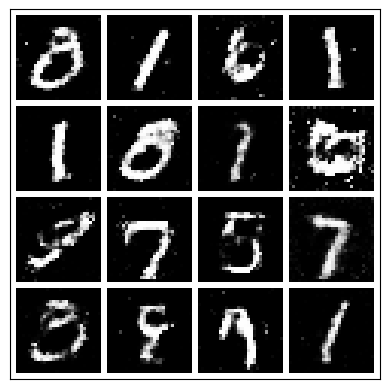

-------------------------------------
                Epoch 43: 
                Step: 1500 | 
                D_real Loss: 0.7563 | 
                D_fake Loss: 0.5100 | 
                D_total Loss: 1.2663 | 
                G_Loss: 1.082 |
                Real_score 0.502 | 
                Fake_score 0.383 
            


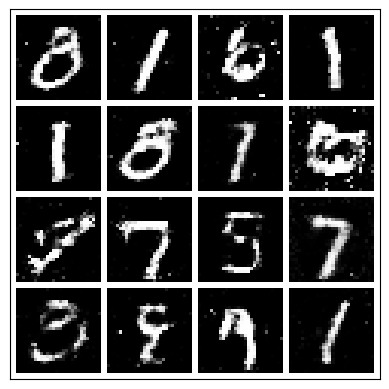

-------------------------------------
                Epoch 43: 
                Step: 2000 | 
                D_real Loss: 0.4938 | 
                D_fake Loss: 0.4759 | 
                D_total Loss: 0.9697 | 
                G_Loss: 1.227 |
                Real_score 0.656 | 
                Fake_score 0.362 
            


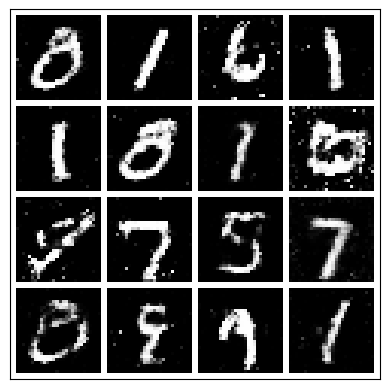

-------------------------------------
                Epoch 43: 
                Step: 2500 | 
                D_real Loss: 0.6516 | 
                D_fake Loss: 0.5466 | 
                D_total Loss: 1.1982 | 
                G_Loss: 0.946 |
                Real_score 0.555 | 
                Fake_score 0.400 
            


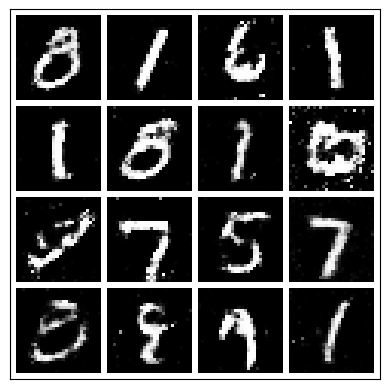

-------------------------------------
                Epoch 43: 
                Step: 3000 | 
                D_real Loss: 0.6355 | 
                D_fake Loss: 0.6584 | 
                D_total Loss: 1.2939 | 
                G_Loss: 0.858 |
                Real_score 0.557 | 
                Fake_score 0.451 
            


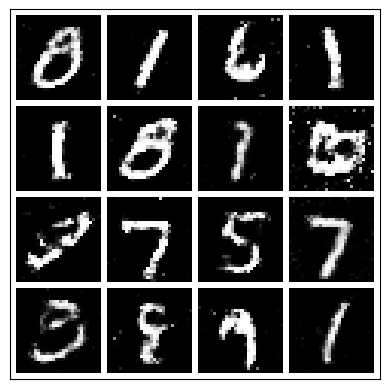

-------------------------------------
                Epoch 43: 
                Step: 3500 | 
                D_real Loss: 0.8220 | 
                D_fake Loss: 0.5015 | 
                D_total Loss: 1.3235 | 
                G_Loss: 0.911 |
                Real_score 0.485 | 
                Fake_score 0.372 
            


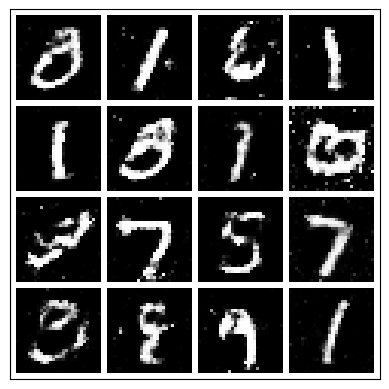

 86%|████████████████████████████████████      | 43/50 [1:02:38<09:52, 84.62s/it]

-------------------------------------
                Epoch 44: 
                Step: 0 | 
                D_real Loss: 0.9331 | 
                D_fake Loss: 0.3837 | 
                D_total Loss: 1.3168 | 
                G_Loss: 1.236 |
                Real_score 0.431 | 
                Fake_score 0.304 
            


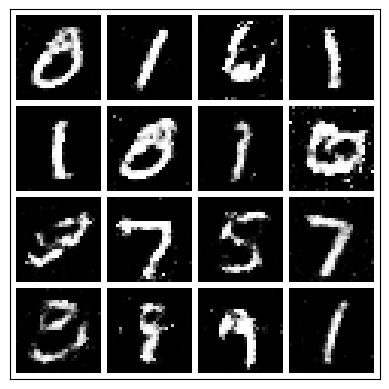

-------------------------------------
                Epoch 44: 
                Step: 500 | 
                D_real Loss: 0.7433 | 
                D_fake Loss: 0.5716 | 
                D_total Loss: 1.3149 | 
                G_Loss: 1.007 |
                Real_score 0.525 | 
                Fake_score 0.422 
            


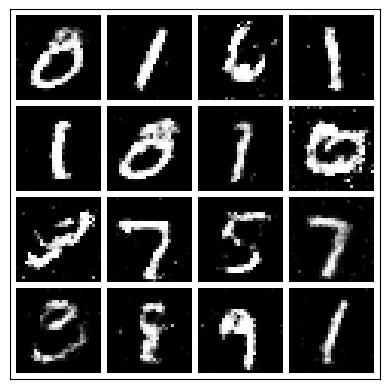

-------------------------------------
                Epoch 44: 
                Step: 1000 | 
                D_real Loss: 0.6226 | 
                D_fake Loss: 0.5329 | 
                D_total Loss: 1.1555 | 
                G_Loss: 0.813 |
                Real_score 0.577 | 
                Fake_score 0.378 
            


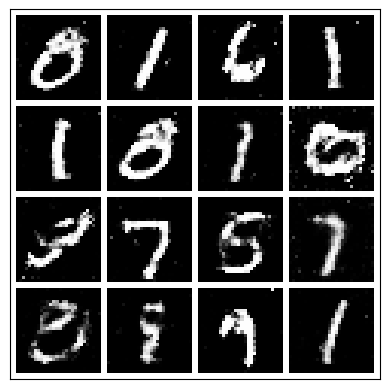

-------------------------------------
                Epoch 44: 
                Step: 1500 | 
                D_real Loss: 0.5793 | 
                D_fake Loss: 0.5175 | 
                D_total Loss: 1.0968 | 
                G_Loss: 1.063 |
                Real_score 0.608 | 
                Fake_score 0.387 
            


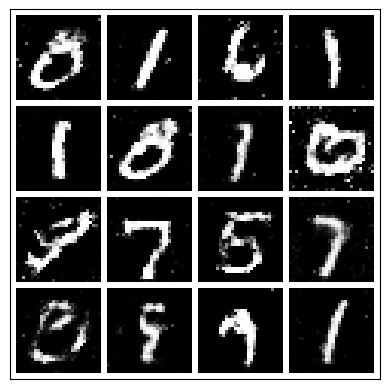

-------------------------------------
                Epoch 44: 
                Step: 2000 | 
                D_real Loss: 0.6000 | 
                D_fake Loss: 0.6497 | 
                D_total Loss: 1.2497 | 
                G_Loss: 0.979 |
                Real_score 0.582 | 
                Fake_score 0.451 
            


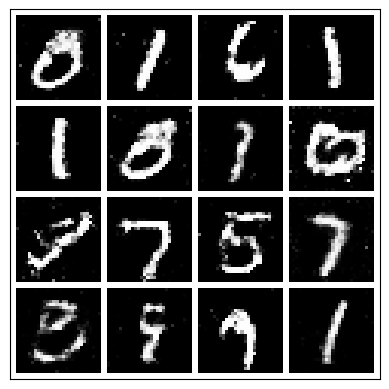

-------------------------------------
                Epoch 44: 
                Step: 2500 | 
                D_real Loss: 0.7656 | 
                D_fake Loss: 0.5734 | 
                D_total Loss: 1.3390 | 
                G_Loss: 0.927 |
                Real_score 0.512 | 
                Fake_score 0.407 
            


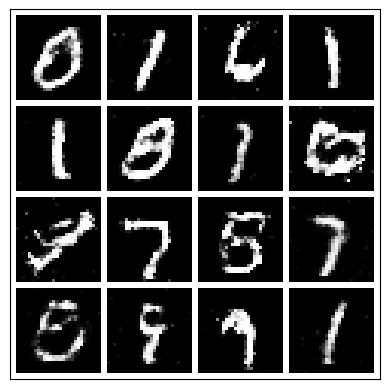

-------------------------------------
                Epoch 44: 
                Step: 3000 | 
                D_real Loss: 0.6719 | 
                D_fake Loss: 0.6881 | 
                D_total Loss: 1.3600 | 
                G_Loss: 0.946 |
                Real_score 0.541 | 
                Fake_score 0.459 
            


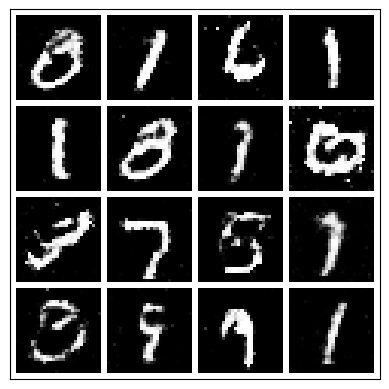

-------------------------------------
                Epoch 44: 
                Step: 3500 | 
                D_real Loss: 0.6328 | 
                D_fake Loss: 0.5967 | 
                D_total Loss: 1.2295 | 
                G_Loss: 0.901 |
                Real_score 0.578 | 
                Fake_score 0.430 
            


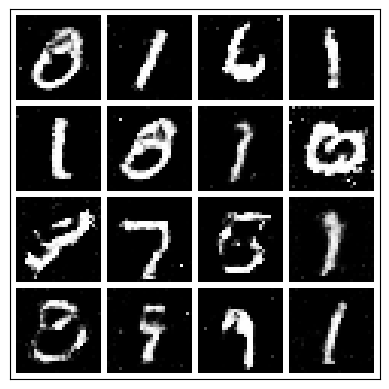

 88%|████████████████████████████████████▉     | 44/50 [1:03:52<08:07, 81.30s/it]

-------------------------------------
                Epoch 45: 
                Step: 0 | 
                D_real Loss: 0.4162 | 
                D_fake Loss: 0.6431 | 
                D_total Loss: 1.0593 | 
                G_Loss: 0.904 |
                Real_score 0.684 | 
                Fake_score 0.448 
            


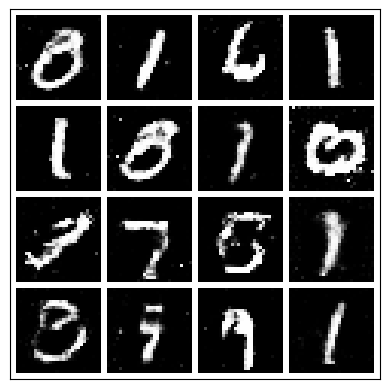

-------------------------------------
                Epoch 45: 
                Step: 500 | 
                D_real Loss: 0.7028 | 
                D_fake Loss: 0.5713 | 
                D_total Loss: 1.2741 | 
                G_Loss: 1.031 |
                Real_score 0.522 | 
                Fake_score 0.400 
            


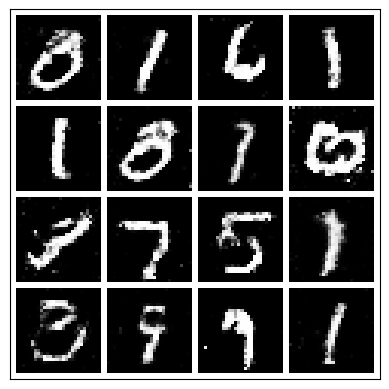

-------------------------------------
                Epoch 45: 
                Step: 1000 | 
                D_real Loss: 0.5159 | 
                D_fake Loss: 0.5419 | 
                D_total Loss: 1.0578 | 
                G_Loss: 1.189 |
                Real_score 0.658 | 
                Fake_score 0.394 
            


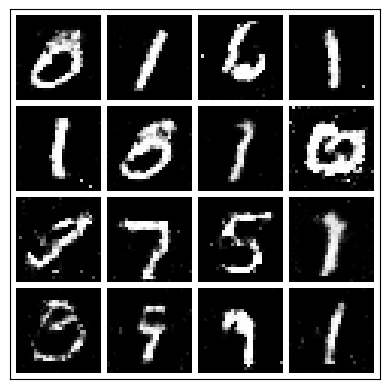

-------------------------------------
                Epoch 45: 
                Step: 1500 | 
                D_real Loss: 0.4788 | 
                D_fake Loss: 0.5465 | 
                D_total Loss: 1.0253 | 
                G_Loss: 0.941 |
                Real_score 0.655 | 
                Fake_score 0.400 
            


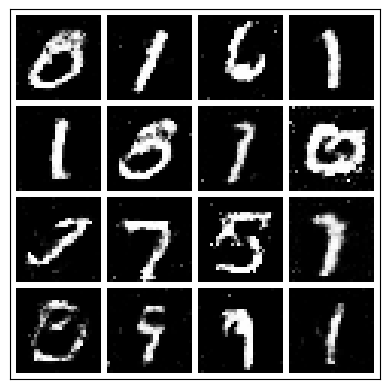

-------------------------------------
                Epoch 45: 
                Step: 2000 | 
                D_real Loss: 0.4582 | 
                D_fake Loss: 0.6223 | 
                D_total Loss: 1.0805 | 
                G_Loss: 0.934 |
                Real_score 0.658 | 
                Fake_score 0.440 
            


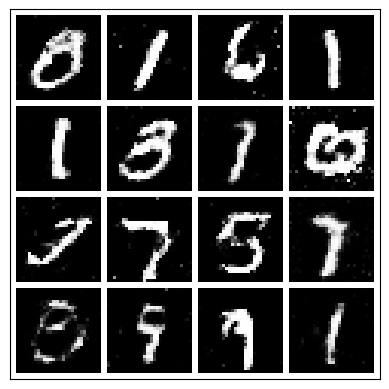

-------------------------------------
                Epoch 45: 
                Step: 2500 | 
                D_real Loss: 0.6117 | 
                D_fake Loss: 0.7193 | 
                D_total Loss: 1.3310 | 
                G_Loss: 0.802 |
                Real_score 0.577 | 
                Fake_score 0.471 
            


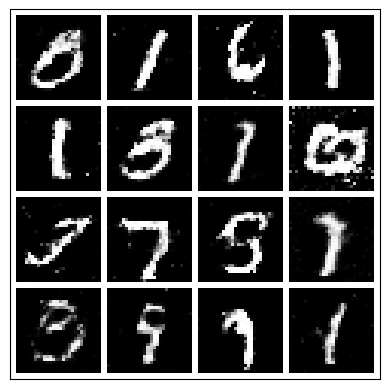

-------------------------------------
                Epoch 45: 
                Step: 3000 | 
                D_real Loss: 0.8630 | 
                D_fake Loss: 0.5327 | 
                D_total Loss: 1.3958 | 
                G_Loss: 1.043 |
                Real_score 0.472 | 
                Fake_score 0.384 
            


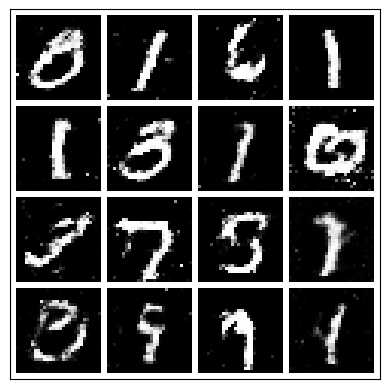

-------------------------------------
                Epoch 45: 
                Step: 3500 | 
                D_real Loss: 0.5525 | 
                D_fake Loss: 0.4585 | 
                D_total Loss: 1.0110 | 
                G_Loss: 1.068 |
                Real_score 0.602 | 
                Fake_score 0.353 
            


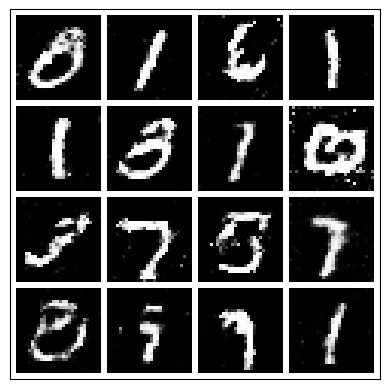

 90%|█████████████████████████████████████▊    | 45/50 [1:05:01<06:29, 77.83s/it]

-------------------------------------
                Epoch 46: 
                Step: 0 | 
                D_real Loss: 0.5645 | 
                D_fake Loss: 0.6962 | 
                D_total Loss: 1.2607 | 
                G_Loss: 0.815 |
                Real_score 0.605 | 
                Fake_score 0.483 
            


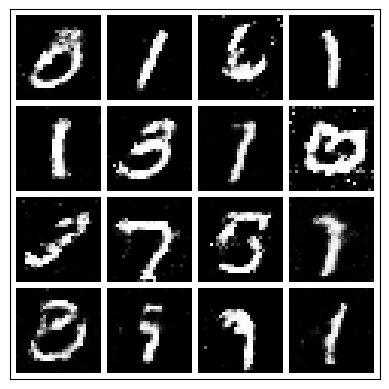

-------------------------------------
                Epoch 46: 
                Step: 500 | 
                D_real Loss: 0.4356 | 
                D_fake Loss: 0.5956 | 
                D_total Loss: 1.0312 | 
                G_Loss: 0.998 |
                Real_score 0.672 | 
                Fake_score 0.428 
            


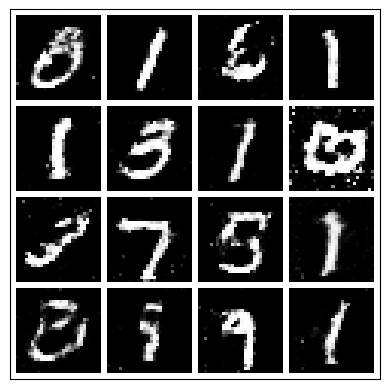

-------------------------------------
                Epoch 46: 
                Step: 1000 | 
                D_real Loss: 0.5406 | 
                D_fake Loss: 0.8168 | 
                D_total Loss: 1.3575 | 
                G_Loss: 0.956 |
                Real_score 0.620 | 
                Fake_score 0.472 
            


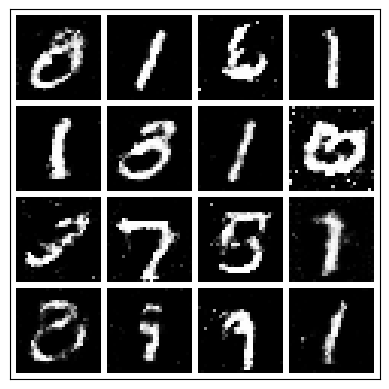

-------------------------------------
                Epoch 46: 
                Step: 1500 | 
                D_real Loss: 0.6417 | 
                D_fake Loss: 0.5678 | 
                D_total Loss: 1.2095 | 
                G_Loss: 0.878 |
                Real_score 0.565 | 
                Fake_score 0.422 
            


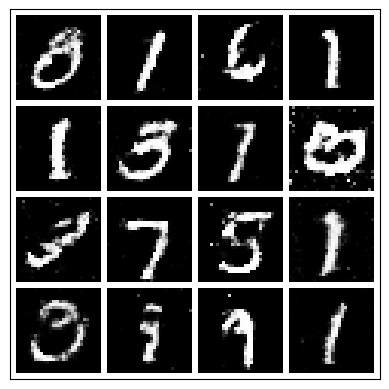

-------------------------------------
                Epoch 46: 
                Step: 2000 | 
                D_real Loss: 0.8103 | 
                D_fake Loss: 0.6027 | 
                D_total Loss: 1.4131 | 
                G_Loss: 1.010 |
                Real_score 0.495 | 
                Fake_score 0.405 
            


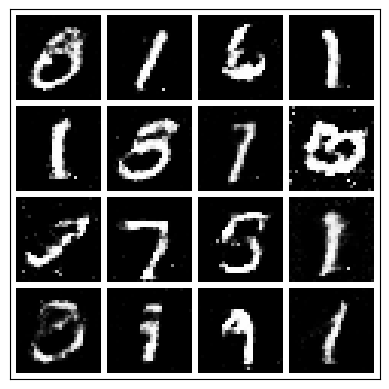

-------------------------------------
                Epoch 46: 
                Step: 2500 | 
                D_real Loss: 0.4459 | 
                D_fake Loss: 0.7500 | 
                D_total Loss: 1.1960 | 
                G_Loss: 0.890 |
                Real_score 0.672 | 
                Fake_score 0.468 
            


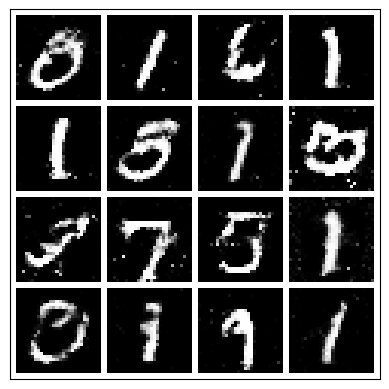

-------------------------------------
                Epoch 46: 
                Step: 3000 | 
                D_real Loss: 0.7644 | 
                D_fake Loss: 0.6948 | 
                D_total Loss: 1.4592 | 
                G_Loss: 0.846 |
                Real_score 0.509 | 
                Fake_score 0.463 
            


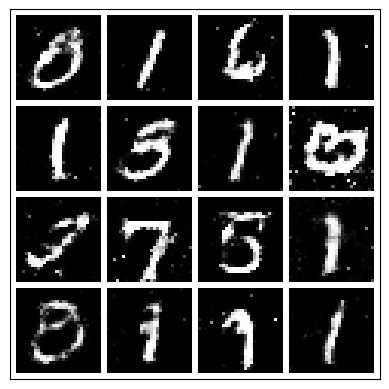

-------------------------------------
                Epoch 46: 
                Step: 3500 | 
                D_real Loss: 0.6211 | 
                D_fake Loss: 0.8637 | 
                D_total Loss: 1.4848 | 
                G_Loss: 0.743 |
                Real_score 0.576 | 
                Fake_score 0.514 
            


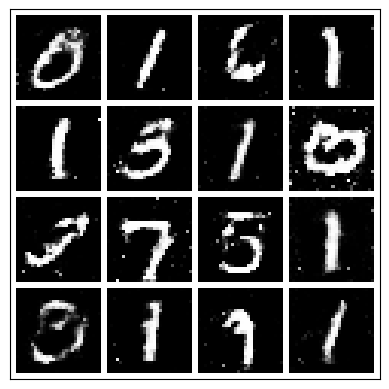

 92%|██████████████████████████████████████▋   | 46/50 [1:06:14<05:05, 76.25s/it]

-------------------------------------
                Epoch 47: 
                Step: 0 | 
                D_real Loss: 0.6224 | 
                D_fake Loss: 0.4074 | 
                D_total Loss: 1.0297 | 
                G_Loss: 0.914 |
                Real_score 0.562 | 
                Fake_score 0.314 
            


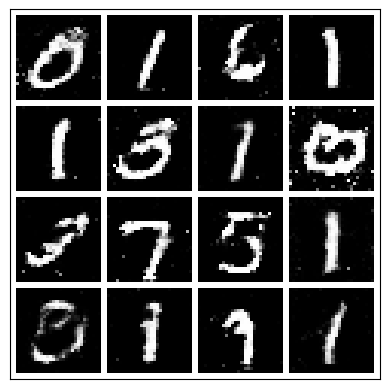

-------------------------------------
                Epoch 47: 
                Step: 500 | 
                D_real Loss: 0.5943 | 
                D_fake Loss: 0.5705 | 
                D_total Loss: 1.1648 | 
                G_Loss: 1.003 |
                Real_score 0.585 | 
                Fake_score 0.412 
            


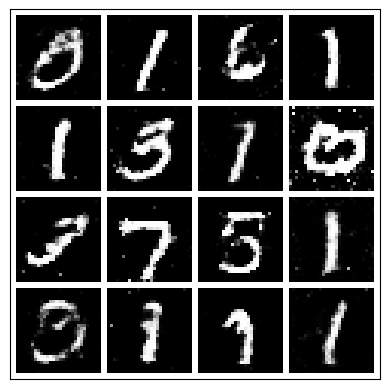

-------------------------------------
                Epoch 47: 
                Step: 1000 | 
                D_real Loss: 0.4735 | 
                D_fake Loss: 0.6114 | 
                D_total Loss: 1.0849 | 
                G_Loss: 0.816 |
                Real_score 0.671 | 
                Fake_score 0.429 
            


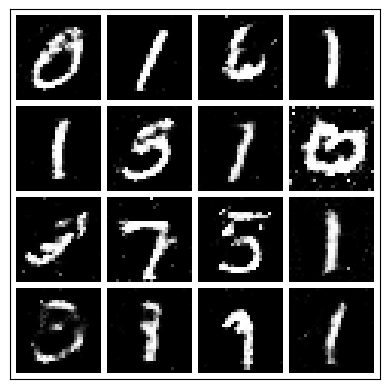

-------------------------------------
                Epoch 47: 
                Step: 1500 | 
                D_real Loss: 0.6015 | 
                D_fake Loss: 0.5134 | 
                D_total Loss: 1.1149 | 
                G_Loss: 1.207 |
                Real_score 0.581 | 
                Fake_score 0.373 
            


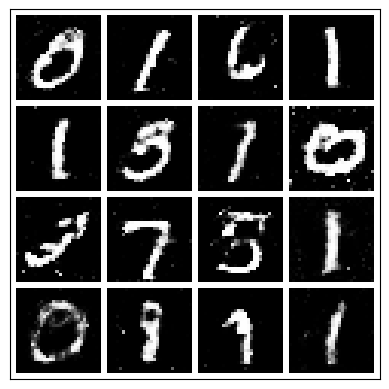

-------------------------------------
                Epoch 47: 
                Step: 2000 | 
                D_real Loss: 0.5867 | 
                D_fake Loss: 0.3880 | 
                D_total Loss: 0.9747 | 
                G_Loss: 1.122 |
                Real_score 0.599 | 
                Fake_score 0.311 
            


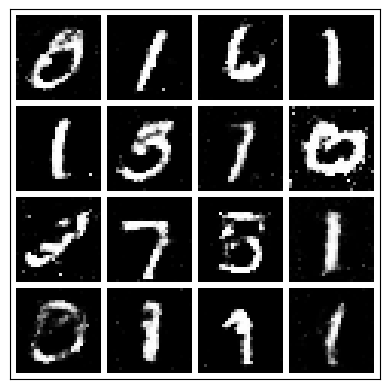

-------------------------------------
                Epoch 47: 
                Step: 2500 | 
                D_real Loss: 0.5047 | 
                D_fake Loss: 0.5791 | 
                D_total Loss: 1.0838 | 
                G_Loss: 0.910 |
                Real_score 0.628 | 
                Fake_score 0.410 
            


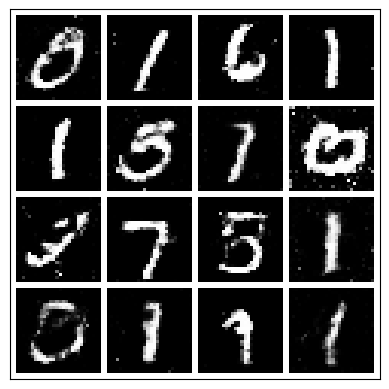

-------------------------------------
                Epoch 47: 
                Step: 3000 | 
                D_real Loss: 0.5819 | 
                D_fake Loss: 0.5898 | 
                D_total Loss: 1.1717 | 
                G_Loss: 0.994 |
                Real_score 0.586 | 
                Fake_score 0.432 
            


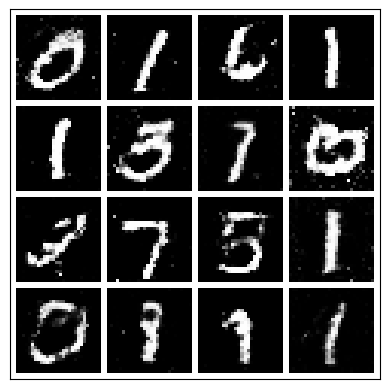

-------------------------------------
                Epoch 47: 
                Step: 3500 | 
                D_real Loss: 0.7051 | 
                D_fake Loss: 0.6171 | 
                D_total Loss: 1.3222 | 
                G_Loss: 0.922 |
                Real_score 0.530 | 
                Fake_score 0.419 
            


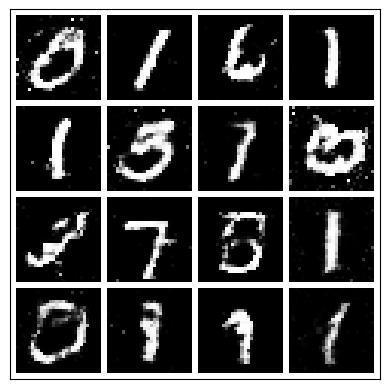

 94%|███████████████████████████████████████▍  | 47/50 [1:07:39<03:56, 78.80s/it]

-------------------------------------
                Epoch 48: 
                Step: 0 | 
                D_real Loss: 0.5407 | 
                D_fake Loss: 0.5745 | 
                D_total Loss: 1.1151 | 
                G_Loss: 1.292 |
                Real_score 0.600 | 
                Fake_score 0.393 
            


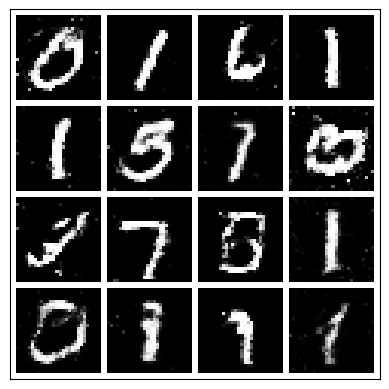

-------------------------------------
                Epoch 48: 
                Step: 500 | 
                D_real Loss: 0.5351 | 
                D_fake Loss: 0.5580 | 
                D_total Loss: 1.0931 | 
                G_Loss: 0.933 |
                Real_score 0.607 | 
                Fake_score 0.383 
            


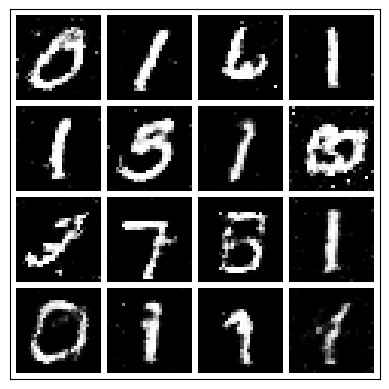

-------------------------------------
                Epoch 48: 
                Step: 1000 | 
                D_real Loss: 0.5639 | 
                D_fake Loss: 0.8731 | 
                D_total Loss: 1.4370 | 
                G_Loss: 0.781 |
                Real_score 0.595 | 
                Fake_score 0.501 
            


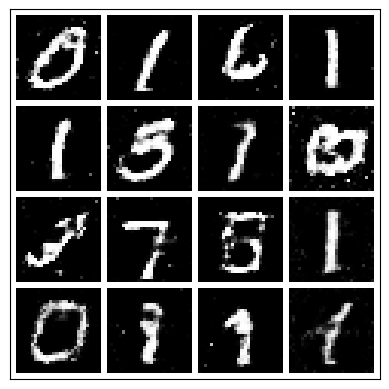

-------------------------------------
                Epoch 48: 
                Step: 1500 | 
                D_real Loss: 0.5317 | 
                D_fake Loss: 0.5691 | 
                D_total Loss: 1.1008 | 
                G_Loss: 0.873 |
                Real_score 0.613 | 
                Fake_score 0.420 
            


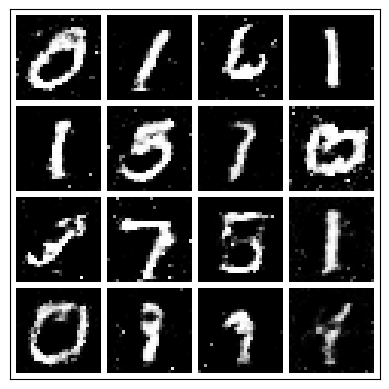

-------------------------------------
                Epoch 48: 
                Step: 2000 | 
                D_real Loss: 0.6118 | 
                D_fake Loss: 0.5461 | 
                D_total Loss: 1.1579 | 
                G_Loss: 1.026 |
                Real_score 0.584 | 
                Fake_score 0.384 
            


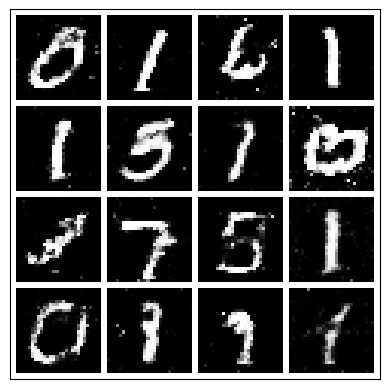

-------------------------------------
                Epoch 48: 
                Step: 2500 | 
                D_real Loss: 0.5857 | 
                D_fake Loss: 0.6841 | 
                D_total Loss: 1.2698 | 
                G_Loss: 1.082 |
                Real_score 0.591 | 
                Fake_score 0.456 
            


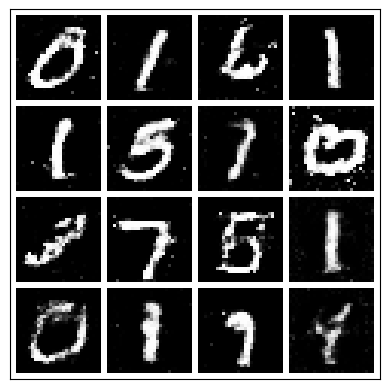

-------------------------------------
                Epoch 48: 
                Step: 3000 | 
                D_real Loss: 0.6045 | 
                D_fake Loss: 0.6076 | 
                D_total Loss: 1.2121 | 
                G_Loss: 0.993 |
                Real_score 0.578 | 
                Fake_score 0.429 
            


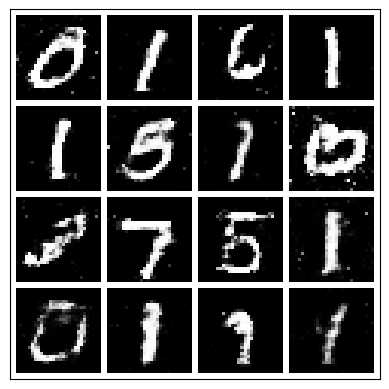

-------------------------------------
                Epoch 48: 
                Step: 3500 | 
                D_real Loss: 0.6742 | 
                D_fake Loss: 0.5429 | 
                D_total Loss: 1.2171 | 
                G_Loss: 1.030 |
                Real_score 0.547 | 
                Fake_score 0.395 
            


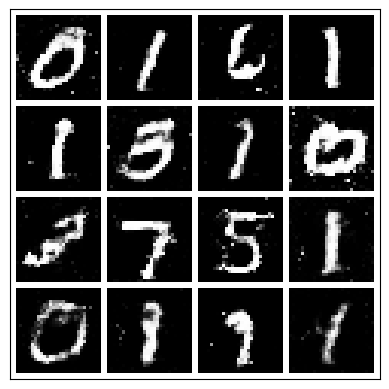

 96%|████████████████████████████████████████▎ | 48/50 [1:08:42<02:28, 74.15s/it]

-------------------------------------
                Epoch 49: 
                Step: 0 | 
                D_real Loss: 0.6240 | 
                D_fake Loss: 0.4764 | 
                D_total Loss: 1.1003 | 
                G_Loss: 1.003 |
                Real_score 0.567 | 
                Fake_score 0.360 
            


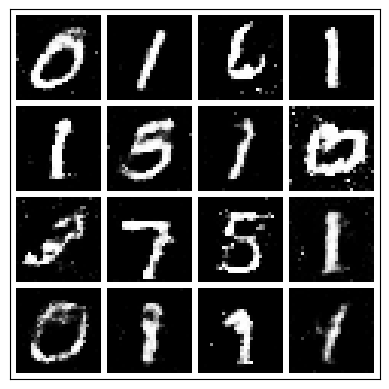

-------------------------------------
                Epoch 49: 
                Step: 500 | 
                D_real Loss: 0.4721 | 
                D_fake Loss: 0.6093 | 
                D_total Loss: 1.0814 | 
                G_Loss: 0.912 |
                Real_score 0.663 | 
                Fake_score 0.446 
            


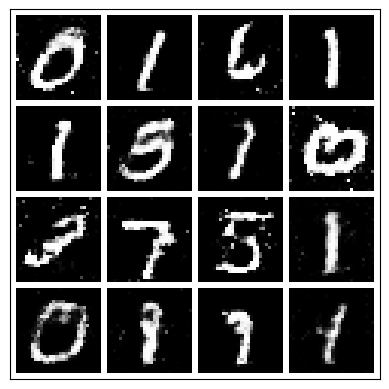

-------------------------------------
                Epoch 49: 
                Step: 1000 | 
                D_real Loss: 0.3117 | 
                D_fake Loss: 0.5204 | 
                D_total Loss: 0.8321 | 
                G_Loss: 1.065 |
                Real_score 0.762 | 
                Fake_score 0.382 
            


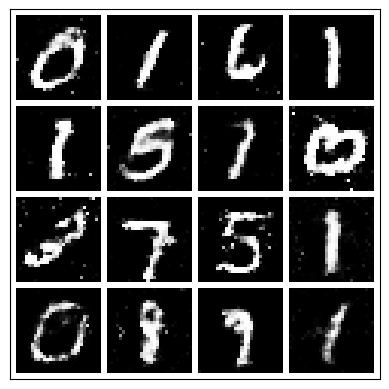

-------------------------------------
                Epoch 49: 
                Step: 1500 | 
                D_real Loss: 0.5547 | 
                D_fake Loss: 0.8847 | 
                D_total Loss: 1.4394 | 
                G_Loss: 0.799 |
                Real_score 0.610 | 
                Fake_score 0.481 
            


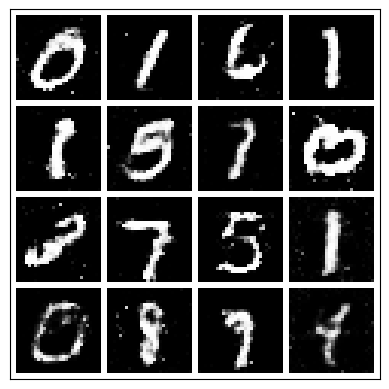

-------------------------------------
                Epoch 49: 
                Step: 2000 | 
                D_real Loss: 0.8389 | 
                D_fake Loss: 0.5469 | 
                D_total Loss: 1.3859 | 
                G_Loss: 0.973 |
                Real_score 0.486 | 
                Fake_score 0.403 
            


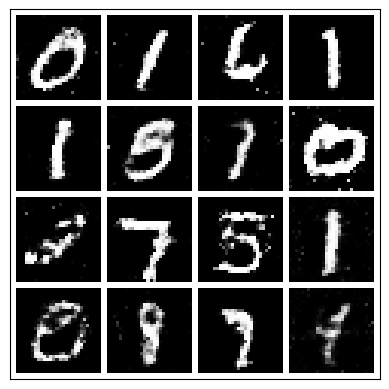

-------------------------------------
                Epoch 49: 
                Step: 2500 | 
                D_real Loss: 0.5633 | 
                D_fake Loss: 0.8345 | 
                D_total Loss: 1.3978 | 
                G_Loss: 0.855 |
                Real_score 0.629 | 
                Fake_score 0.509 
            


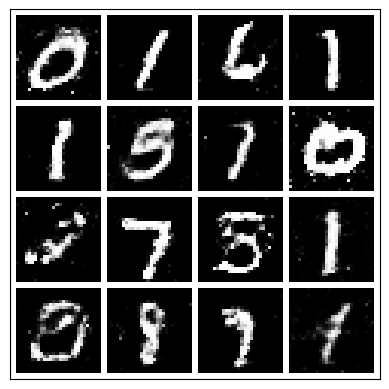

-------------------------------------
                Epoch 49: 
                Step: 3000 | 
                D_real Loss: 0.6772 | 
                D_fake Loss: 0.5867 | 
                D_total Loss: 1.2639 | 
                G_Loss: 0.908 |
                Real_score 0.544 | 
                Fake_score 0.403 
            


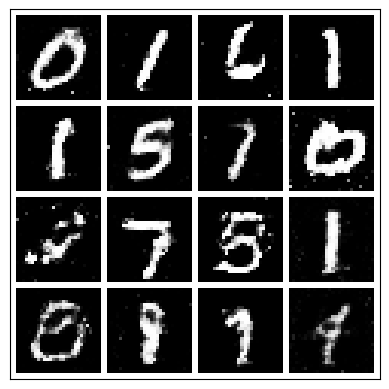

-------------------------------------
                Epoch 49: 
                Step: 3500 | 
                D_real Loss: 0.5112 | 
                D_fake Loss: 0.5553 | 
                D_total Loss: 1.0665 | 
                G_Loss: 0.826 |
                Real_score 0.632 | 
                Fake_score 0.410 
            


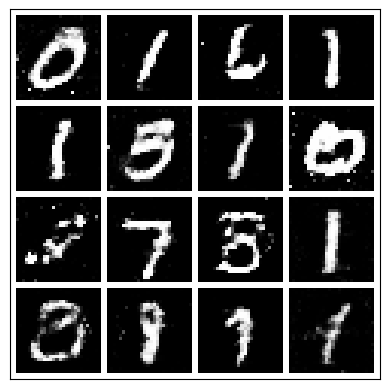

 98%|█████████████████████████████████████████▏| 49/50 [1:10:17<01:20, 80.48s/it]

-------------------------------------
                Epoch 50: 
                Step: 0 | 
                D_real Loss: 0.9304 | 
                D_fake Loss: 0.5261 | 
                D_total Loss: 1.4565 | 
                G_Loss: 1.025 |
                Real_score 0.475 | 
                Fake_score 0.393 
            


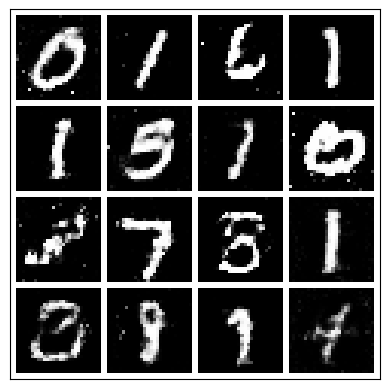

 98%|█████████████████████████████████████████▏| 49/50 [1:10:18<01:26, 86.09s/it]


NameError: name 'emnist_dataloader' is not defined

In [ ]:
losses_G = []
losses_D = []

real_score_list = []
fake_score_list = []

num_epochs = 50

generator.train()
discriminator.train()

for epoch in tqdm(range(num_epochs)):

    # For each batch in the dataloader
    for i, (data, _) in enumerate(mnist_dataloader, 0):

        ##################################################
        # Get output from discriminator and compute losses
        ##################################################

        discriminator.zero_grad()

        # Format batch
        real_images = data.reshape(batch_size, 1, 784)

        # Feed real images through discriminator
        output = discriminator(real_images).view(-1)

        # Calculate loss on real images by comparing with real labels
        real_loss_D = criterion(output, real_image_labels)

        # Compute discriminator gradients
        real_loss_D.backward()

        real_score_D = output.mean().item()

        # Generate fake image batch with generator
        noise = torch.randn(batch_size, latent_noise_size)

        fake_images = generator(noise)

        output = discriminator(fake_images.detach()).view(-1)

        # Calculate loss on fake images by comparing with fake labels
        fake_loss_D = criterion(output, fake_image_labels)

        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        fake_loss_D.backward()

        fake_score_D = output.mean().item()

        # Compute error of discriminator as sum over the fake and the real batches
        total_loss_D = real_loss_D + fake_loss_D

        # Update discriminator parameters
        optimizer_D.step()

        ##################################################
        # Get output from generator and compute losses
        ##################################################

        generator.zero_grad()

        # Feed fake images through discriminator with newly updated weights
        output = discriminator(fake_images).view(-1)

        # Calculate generator's loss based on this output
        loss_G = criterion(output, real_image_labels)

        # Calculate gradients for generator
        loss_G.backward()

        # Update generator parameters
        optimizer_G.step()

        if (i % 500 == 0) or ((epoch == num_epochs - 1) and (i == len(mnist_dataloader) - 1)):
            print(f"""-------------------------------------
                Epoch {epoch + 1}:
                Step: {i} |
                D_real Loss: {real_loss_D:.4f} |
                D_fake Loss: {fake_loss_D:.4f} |
                D_total Loss: {total_loss_D:.4f} |
                G_Loss: {loss_G:.3f} |
                Real_score {real_score_D:.3f} |
                Fake_score {fake_score_D:.3f}
            """)

            with torch.no_grad():
                generated_images = generator(fixed_noise).reshape(batch_size, 1, 28, 28).detach().cpu()
                display(make_grid(generated_images, nrow = 4, pad_value = 1.0))

        losses_G.append(loss_G.item())
        losses_D.append(total_loss_D.item())

        real_score_list.append(real_score_D)
        fake_score_list.append(fake_score_D)

 First, we will see how D and G’s losses changed during training.Discriminator loss is increasing and Generator loss is decreasing Real score and Fake score are converging to 0.5

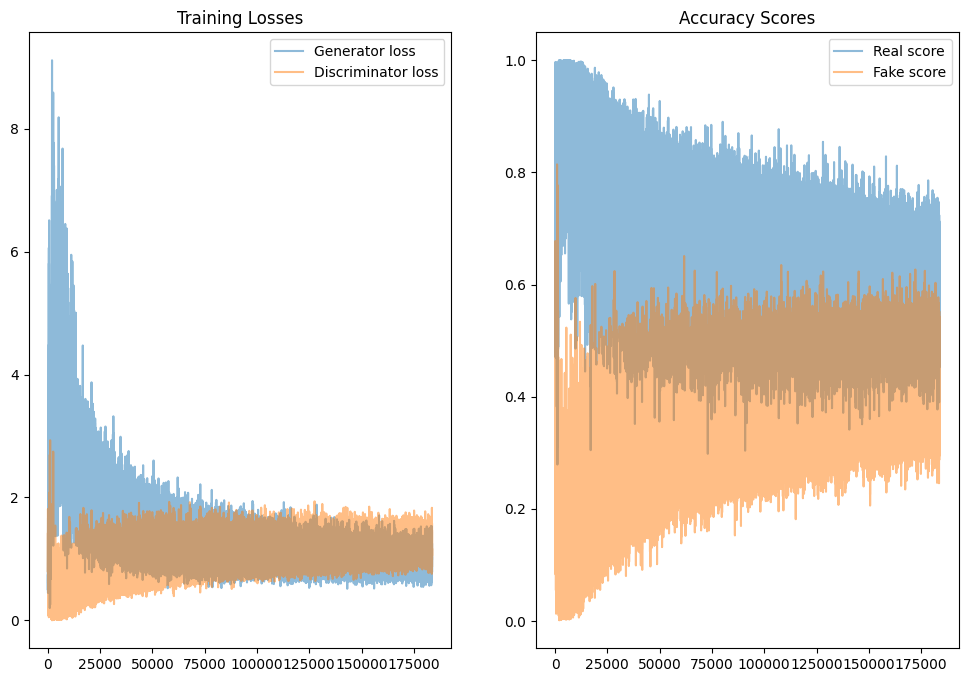

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 8))

ax1.plot(losses_G, label = 'Generator loss', alpha = 0.5)
ax1.plot(losses_D, label = 'Discriminator loss', alpha = 0.5)
ax1.legend()

ax1.set_title('Training Losses')
ax2.plot(real_score_list, label = 'Real score', alpha = 0.5)
ax2.plot(fake_score_list, label = 'Fake score', alpha = 0.5)
ax2.set_title('Accuracy Scores')

ax2.legend()